In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import rasterio
from rasterio.features import rasterize
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### SSB 03175

The script below is used for cleaning raw data from SSB (Table 03175), it has to be downloaded for a single year (2006-2024). 

In [2]:
# Class that takes care of the cleaning (dropping last and forst rows, setting index)

class SSB03175DataCleaner:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    def load_and_clean_data(self):

        self.data = pd.read_excel(self.file_path, header=None)
        self.data = self.data.drop(index=range(4))
        self.data = self.data.drop(index=range(366, 561), errors='ignore') # drop the last rows
        self.data.iloc[0, 0] = "kommunenum"
        self.data.columns = self.data.iloc[0]
        self.data = self.data.drop(self.data.index[0])
        self.data = self.data.reset_index(drop=True)
        self.data = self.data.dropna(how='all')
        
        self.data = self.data[~self.data['kommunenum'].isin([
            'K-21-22 Svalbard and Jan Mayen', 
            'K-23 Continental shelf', 
            'K-Rest Divided municalities and unknown'
        ])]
        
        return self.data

In [3]:
ssb_cleaner = SSB03175DataCleaner("/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_03175/ssb_03175_2024_raw.xlsx")
buildings_data = ssb_cleaner.load_and_clean_data()
buildings_data

4                  kommunenum Detached house House with 2 dwellings  \
0               K-3101 Halden           7703                   1569   
1                 K-3103 Moss           8423                   1255   
2            K-3105 Sarpsborg          12594                   2516   
3          K-3107 Fredrikstad          18170                   3066   
4               K-3110 Hvaler           1978                    138   
..                        ...            ...                    ...   
352      K-5628 Deatnu - Tana           1356                    141   
353           K-5630 Berlevåg            456                     79   
354          K-5632 Båtsfjord            703                     61   
355              K-5634 Vardø            777                    201   
356  K-5636 Unjárga - Nesseby            459                     56   

4   Row house, linked house and house with 3 dwellings or more  \
0                                                 1056           
1                                                 2174           
2                                                 2439           
3                                                 3188           
4                                                   80           
..                                                 ...           
352                                                 46           
353                                                 17           
354                                                 97           
355                                                108           
356                                                 14           

4   Multi-dwelling building Residence for communities  
0                       217                        31  
1                       591                        23  
2                       353                        31  
3                       607                        54  
4                        25                         1  
..                      ...                       ...  
352                       2                         7  
353                       0                         5  
354                      11                         3  
355                       6                         5  
356                       0                         0  

[357 rows x 6 columns]

### SSB 06266

The script below takes care of another table from SSB (Table 06266), it also has to be downloaded for one year (e.g. 2024). 
It is necessary to add a class BuildingDwellingCalculator that would create a new dataset total_dwellings and store the sums per municipality and archetype. Then it is necessary to add the code to create dwellings_per_buildings dataset that would store the results of division of values from total_dwelling by values from building_data. 

In [4]:
class SSB06266DataCleaner:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    def load_and_clean_data(self):
        """
        Load the data from the specified Excel file and perform initial cleaning.
        
        Returns:
            pd.DataFrame: Cleaned dataset.
        """
        self.data = pd.read_excel(self.file_path, header=None)
        self.data.iloc[4, 1] = "kommunenum"
        self.data = self.data.drop(index=self.data.index[:4])  # Drop the first 4 rows
        self.data.columns = self.data.iloc[0]  # Set the column names
        self.data = self.data.drop(self.data.index[0])  # Drop the first row
        self.data = self.data.drop(self.data.columns[0], axis=1)  # Drop the first column
        self.data = self.data.reset_index(drop=True)  # Reset the index of the dataframe
        self.data = self.data.dropna(how='all')  # Drop rows where all values are NaN
        
        exclude_values = [
            'K-21-22 Svalbard and Jan Mayen',
            'K-23 Continental shelf',
            'K-Rest Divided municalities and unknown'
        ]
        self.data = self.data[~self.data['kommunenum'].isin(exclude_values)]  # Exclude specific values
        self.clean_column_names()  # Clean column names
        
        return self.data

    def clean_column_names(self):
        """
        Clean and rename the column names of the dataset.
        
        Returns:
            pd.DataFrame: Dataset with renamed columns.
        """
        # Rename specific columns and replace '-' with '_'
        self.data.columns = self.data.columns.str.replace("2021 and after", "2021-", regex=False)
        self.data.columns = self.data.columns.str.replace('-', '_')
        
        # Add prefixes to column names based on categories
        self.data.columns.values[1:14] = ['Detached house_' + col for col in self.data.columns[1:14]]
        self.data.columns.values[14:27] = ['House with 2 dwellings_' + col for col in self.data.columns[14:27]]
        self.data.columns.values[27:40] = ['Row house, linked house and house with 3 dwellings or more_' + col for col in self.data.columns[27:40]]
        self.data.columns.values[40:53] = ['Multi-dwelling building_' + col for col in self.data.columns[40:53]]
        self.data.columns.values[53:] = ['Residence for communities_' + col for col in self.data.columns[53:]]
        
        return self.data


class BuildingDwellingCalculator:
    def __init__(self, data):
        """
        Initialize the BuildingDwellingCalculator with the dataset.
        
        Args:
            data (pd.DataFrame): The dataset containing dwelling information.
        """
        self.data = data

    def calculate_sums_by_category(self):
        """
        Calculate sums of dwellings within each archetype category.
        
        Returns:
            pd.DataFrame: A new dataset with total sums for each category.
        """
        total_dwellings = pd.DataFrame()
        total_dwellings['kommunenum'] = self.data['kommunenum'].values  # Add municipality codes

        # Calculate sums for each dwelling category/ archetype
        total_dwellings['Detached house'] = self.data.filter(like='Detached house_').sum(axis=1)
        total_dwellings['House with 2 dwellings'] = self.data.filter(like='House with 2 dwellings_').sum(axis=1)
        total_dwellings['Row house, linked house and house with 3 dwellings or more'] = self.data.filter(
            like='Row house, linked house and house with 3 dwellings or more_'
        ).sum(axis=1)
        total_dwellings['Multi-dwelling building'] = self.data.filter(like='Multi-dwelling building_').sum(axis=1)
        total_dwellings['Residence for communities'] = self.data.filter(like='Residence for communities_').sum(axis=1)

        return total_dwellings


class DwellingsPerBuildingsCalculator:
    def __init__(self, total_dwellings, building_data):
        """
        Initialize the DwellingsPerBuildingsCalculator with the datasets.
        
        Args:
            total_dwellings (pd.DataFrame): Dataset with total dwellings per category.
            building_data (pd.DataFrame): Dataset with building counts per category.
        """
        self.total_dwellings = total_dwellings
        self.building_data = building_data

    def calculate_dwellings_per_building(self):
        """
        Calculate dwellings per building for each archetype category.
        
        Returns:
            pd.DataFrame: A new dataset with dwellings per building for each category.
        """
        dwellings_per_buildings = pd.DataFrame()
        dwellings_per_buildings['kommunenum'] = self.total_dwellings['kommunenum'].values  # Add municipality codes
        building_data_nonzero = self.building_data.replace(0, pd.NA) # replace zero values in building_data to avoid division by zero

        for col in self.total_dwellings.columns[1:]:
            dwellings_per_buildings[f'{col}'] = (
                self.total_dwellings[col] / building_data_nonzero[col]
            )

        return dwellings_per_buildings


# Main Program
if __name__ == "__main__":
 
    file_path = "/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_06266/ssb_06266_2024_full.xlsx"
    data_cleaner = SSB06266DataCleaner(file_path)
    dwellings_data = data_cleaner.load_and_clean_data()
    calculator = BuildingDwellingCalculator(dwellings_data)
    total_dwellings = calculator.calculate_sums_by_category()
    dwellings_calculator = DwellingsPerBuildingsCalculator(total_dwellings, buildings_data)
    dwellings_per_buildings = dwellings_calculator.calculate_dwellings_per_building()


dwellings_per_buildings

kommunenum Detached house House with 2 dwellings  \
0               K-3101 Halden       1.054135               1.597833   
1                 K-3103 Moss       1.078713                1.52988   
2            K-3105 Sarpsborg       1.055661               1.438394   
3          K-3107 Fredrikstad       1.045845                1.68591   
4               K-3110 Hvaler       1.032861               1.326087   
..                        ...            ...                    ...   
352      K-5628 Deatnu - Tana       1.082596                1.06383   
353           K-5630 Berlevåg       1.122807               1.468354   
354          K-5632 Båtsfjord       1.174964               1.459016   
355              K-5634 Vardø       1.018018               1.681592   
356  K-5636 Unjárga - Nesseby       1.041394               1.214286   

    Row house, linked house and house with 3 dwellings or more  \
0                                             2.204545           
1                                             2.142134           
2                                             1.679787           
3                                             1.788896           
4                                               1.4125           
..                                                 ...           
352                                           2.108696           
353                                           1.235294           
354                                           1.206186           
355                                           1.407407           
356                                           1.714286           

    Multi-dwelling building Residence for communities  
0                 10.926267                 21.483871  
1                  13.91709                 12.391304  
2                 14.708215                  9.741935  
3                 12.579901                 10.796296  
4                      4.48                      13.0  
..                      ...                       ...  
352                     1.5                  6.142857  
353                    <NA>                       2.8  
354                8.818182                  2.333333  
355                     6.0                       9.6  
356                    <NA>                      <NA>  

[357 rows x 6 columns]

And then it is necessary to divide the values from dwellings_data by values from dwellings_per_buildings and store it in buildings_disaggregated.

In [5]:
class BuildingsDisaggregatedCalculator:
    def __init__(self, dwelling_data, dwellings_per_buildings):

        self.dwelling_data = dwelling_data
        self.dwellings_per_buildings = dwellings_per_buildings

    def calculate_disaggregated_buildings(self):
 
        # Start with the 'kommunenum' column
        buildings_disaggregated = self.dwelling_data[['kommunenum']].copy()

        # Iterate through the columns in dwellings_per_buildings
        for archetype in self.dwellings_per_buildings.columns[1:]:  # Skip 'kommunenum'
            # Identify all dwelling_data columns that start with the archetype
            matching_columns = self.dwelling_data.filter(like=archetype).columns

            if not matching_columns.empty:
                # Divide matching columns by the corresponding value in dwellings_per_buildings
                for col in matching_columns:
                    # Access the dwellings_per_buildings Series for this archetype
                    denominator = self.dwellings_per_buildings[archetype]
                    
                    # Ensure we handle division by zero element-wise
                    buildings_disaggregated[col] = self.dwelling_data[col] / denominator.where(denominator != 0, 1)  # Use 1 where denominator is 0

        # Replace infinite and NaN values with 0 or another default value if necessary
        buildings_disaggregated = buildings_disaggregated.replace([float('inf'), -float('inf')], pd.NA).fillna(0)

        return buildings_disaggregated

if __name__ == "__main__":

    dwellings_per_buildings_calculator = DwellingsPerBuildingsCalculator(total_dwellings, buildings_data)
    dwellings_per_buildings = dwellings_per_buildings_calculator.calculate_dwellings_per_building()
    disaggregated_calculator = BuildingsDisaggregatedCalculator(dwellings_data, dwellings_per_buildings)
    buildings_disaggregated = disaggregated_calculator.calculate_disaggregated_buildings()


buildings_disaggregated


4                  kommunenum  Detached house_1900 and earlier  \
0               K-3101 Halden                       568.238547   
1                 K-3103 Moss                       489.472155   
2            K-3105 Sarpsborg                       720.875066   
3          K-3107 Fredrikstad                      2075.833816   
4               K-3110 Hvaler                       261.409692   
..                        ...                              ...   
352      K-5628 Deatnu - Tana                        11.084469   
353           K-5630 Berlevåg                         0.890625   
354          K-5632 Båtsfjord                         1.702179   
355              K-5634 Vardø                        58.938053   
356  K-5636 Unjárga - Nesseby                        10.562762   

4    Detached house_1901_1920  Detached house_1921_1940  \
0                  398.431034                680.178695   
1                  363.395994                659.118754   
2                  743.609628               1138.622640   
3                 1187.556702               1347.236226   
4                   98.754772                 96.818404   
..                        ...                       ...   
352                 14.779292                 22.168937   
353                  8.906250                  4.453125   
354                  3.404358                 23.830508   
355                 23.575221                 71.707965   
356                  7.682008                  7.682008   

4    Detached house_1941_1945  Detached house_1946_1960  \
0                   25.613424                859.472660   
1                   33.373101               1328.434845   
2                   70.098232               1850.972245   
3                   76.493185               2637.102563   
4                    5.809104                108.436613   
..                        ...                       ...   
352                  2.771117                232.773842   
353                  0.890625                174.562500   
354                  5.106538                141.280872   
355                  2.946903                215.123894   
356                  0.960251                105.627615   

4    Detached house_1961_1970  Detached house_1971_1980  \
0                 1061.534113               1120.350123   
1                 1223.680387               1093.896104   
2                 1922.017751               2274.403460   
3                 2228.820186               2319.655844   
4                  112.309349                214.936858   
..                        ...                       ...   
352                117.310627                252.171662   
353                104.203125                 89.953125   
354                145.536320                175.324455   
355                114.929204                191.548673   
356                 40.330544                111.389121   

4    Detached house_1981_1990  Detached house_1991_2000  ...  \
0                  946.748030                454.401108  ...   
1                 1072.574400                838.962690  ...   
2                 1958.014141                578.784054  ...   
3                 2618.935431               1183.732042  ...   
4                  297.232501                166.527655  ...   
..                        ...                       ...  ...   
352                254.019074                139.479564  ...   
353                 11.578125                  5.343750  ...   
354                 45.107748                 46.809927  ...   
355                 31.433628                 37.327434  ...   
356                 72.979079                 37.449791  ...   

4    Residence for communities_1941_1945  Residence for communities_1946_1960  \
0                                    0.0                             0.000000   
1                                    0.0                             0.564912   
2                                    0.0                            

Now it's necessary to drop the column "Other" that is not going to be used so far, it will be analysed later. 

In [6]:
exclude_substrings = ["Unknown"]

filtered_columns = [
    col for col in buildings_disaggregated.columns 
    if not any(substring in col for substring in exclude_substrings)
]
buildings_disaggregated = buildings_disaggregated[filtered_columns]
buildings_disaggregated

4                  kommunenum  Detached house_1900 and earlier  \
0               K-3101 Halden                       568.238547   
1                 K-3103 Moss                       489.472155   
2            K-3105 Sarpsborg                       720.875066   
3          K-3107 Fredrikstad                      2075.833816   
4               K-3110 Hvaler                       261.409692   
..                        ...                              ...   
352      K-5628 Deatnu - Tana                        11.084469   
353           K-5630 Berlevåg                         0.890625   
354          K-5632 Båtsfjord                         1.702179   
355              K-5634 Vardø                        58.938053   
356  K-5636 Unjárga - Nesseby                        10.562762   

4    Detached house_1901_1920  Detached house_1921_1940  \
0                  398.431034                680.178695   
1                  363.395994                659.118754   
2                  743.609628               1138.622640   
3                 1187.556702               1347.236226   
4                   98.754772                 96.818404   
..                        ...                       ...   
352                 14.779292                 22.168937   
353                  8.906250                  4.453125   
354                  3.404358                 23.830508   
355                 23.575221                 71.707965   
356                  7.682008                  7.682008   

4    Detached house_1941_1945  Detached house_1946_1960  \
0                   25.613424                859.472660   
1                   33.373101               1328.434845   
2                   70.098232               1850.972245   
3                   76.493185               2637.102563   
4                    5.809104                108.436613   
..                        ...                       ...   
352                  2.771117                232.773842   
353                  0.890625                174.562500   
354                  5.106538                141.280872   
355                  2.946903                215.123894   
356                  0.960251                105.627615   

4    Detached house_1961_1970  Detached house_1971_1980  \
0                 1061.534113               1120.350123   
1                 1223.680387               1093.896104   
2                 1922.017751               2274.403460   
3                 2228.820186               2319.655844   
4                  112.309349                214.936858   
..                        ...                       ...   
352                117.310627                252.171662   
353                104.203125                 89.953125   
354                145.536320                175.324455   
355                114.929204                191.548673   
356                 40.330544                111.389121   

4    Detached house_1981_1990  Detached house_1991_2000  ...  \
0                  946.748030                454.401108  ...   
1                 1072.574400                838.962690  ...   
2                 1958.014141                578.784054  ...   
3                 2618.935431               1183.732042  ...   
4                  297.232501                166.527655  ...   
..                        ...                       ...  ...   
352                254.019074                139.479564  ...   
353                 11.578125                  5.343750  ...   
354                 45.107748                 46.809927  ...   
355                 31.433628                 37.327434  ...   
356                 72.979079                 37.449791  ...   

4    Residence for communities_1921_1940  Residence for communities_1941_1945  \
0                               0.000000                                  0.0   
1                               0.000000                                  0.0   
2                               0.000000                            

Now work on the column names and transformations.

In [7]:
renamed_columns = {
    col: col.replace("Detached house", "SFH") 
    for col in buildings_disaggregated.columns 
    if "Detached house" in col
}

buildings_disaggregated.rename(columns=renamed_columns, inplace=True)

buildings_disaggregated.rename(
    columns=lambda col: col.replace("House with 2 dwellings", "MFH").replace(
        "Row house, linked house and house with 3 dwellings or more", "MFH"
    ),
    inplace=True
)
buildings_disaggregated = buildings_disaggregated.groupby(axis=1, level=0).sum()

buildings_disaggregated.rename(
    columns=lambda col: col.replace("Multi-dwelling building", "AB").replace(
        "Residence for communities", "AB"
    ),
    inplace=True
)
buildings_disaggregated = buildings_disaggregated.groupby(axis=1, level=0).sum()

buildings_disaggregated.rename(
    columns=lambda col: col.replace("1946_1960", "1955").replace("1961_1970", "1956_1970"),
    inplace=True
)
buildings_disaggregated

buildings_disaggregated.rename(
    columns=lambda col: col.replace("1941_1945", "1955").replace("1921_1940", "1955").replace("1901_1920", "1955").replace("1900 and earlier", "1955"),
    inplace=True
)
buildings_disaggregated = buildings_disaggregated.groupby(axis=1, level=0).sum()
buildings_disaggregated

/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_23656/3257534734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buildings_disaggregated.rename(columns=renamed_columns, inplace=True)
/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_23656/3257534734.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buildings_disaggregated.rename(
/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_23656/3257534734.py:15: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  buildings_disaggregated = buildings_disaggregated.groupby(axis=1, level=0).

4      AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  \
0    73.356121     28.646563     39.354703     13.061597     22.572660   
1    46.892041    113.079590     63.247425     45.124377     49.340709   
2    57.342845     50.583975     90.412281     34.899753     34.034378   
3    66.887887     79.437957     87.279297     37.224283     34.595475   
4     0.000000      0.000000      0.000000      0.000000      4.017857   
..         ...           ...           ...           ...           ...   
352   0.000000      0.000000      0.000000      1.658915      1.139535   
353   0.000000      0.000000      0.000000      0.000000      0.000000   
354   0.428571      0.000000      3.061856      0.428571      1.360825   
355   2.000000      0.000000      0.000000      0.729167      0.000000   
356   0.000000      0.000000      0.000000      0.000000      0.000000   

4    AB_2001_2010  AB_2011_2020   AB_2021_     MFH_1955  MFH_1956_1970  ...  \
0       24.810468     22.866781  17.599169  1279.978218     228.873575  ...   
1       86.178540    132.602184  65.674650  1038.395199     395.406946  ...   
2       44.551560     38.448566  33.726641  2041.444772     651.817040  ...   
3       95.706719    200.492130  51.272263  2585.143698     595.014315  ...   
4        5.357143     15.062500   1.562500    15.081967       5.278689  ...   
..            ...           ...        ...          ...            ...  ...   
352      0.000000      4.558140   0.000000    14.116907       1.880000  ...   
353      0.000000      0.714286   0.000000    44.485632       2.043103  ...   
354      2.142857      0.680412   0.000000    23.512917      17.598771  ...   
355      0.000000      0.000000   0.000000   137.385705      23.292744  ...   
356      0.000000      0.000000   0.000000     6.691176       0.000000  ...   

4     MFH_2021_     SFH_1955  SFH_1956_1970  SFH_1971_1980  SFH_1981_1990  \
0     79.064557  2531.934360    1061.534113    1120.350123     946.748030   
1    109.892795  2873.794849    1223.680387    1093.896104    1072.574400   
2    247.241642  4524.177811    1922.017751    2274.403460    1958.014141   
3    123.694196  7324.222491    2228.820186    2319.655844    2618.935431   
4     10.234441   571.228585     112.309349     214.936858     297.232501   
..          ...          ...            ...            ...            ...   
352    9.400000   283.577657     117.310627     252.171662     254.019074   
353    0.000000   189.703125     104.203125      89.953125      11.578125   
354    0.000000   175.324455     145.536320     175.324455      45.107748   
355    0.000000   372.292035     114.929204     191.548673      31.433628   
356    0.000000   132.514644      40.330544     111.389121      72.979079   

4    SFH_1991_2000  SFH_2001_2010  SFH_2011_2020   SFH_2021_  \
0       454.401108     556.854803     629.900493  122.375246   
1       838.962690     652.629540     392.133942   94.557121   
2       578.784054     678.247762     486.898533  153.458293   
3      1183.732042    1090.027890     961.901805  175.934326   
4       166.527655     253.664219     276.900636   46.472834   
..             ...            ...            ...         ...   
352     139.479564      66.506812      78.514986   19.397820   
353       5.343750       7.125000       5.343750    0.000000   
354      46.809927       9.361985      10.213075    0.000000   
355      37.327434       5.893805       3.929204    2.946903   
356      37.449791      20.165272      14.403766    1.920502   

4                  kommunenum  
0               K-3101 Halden  
1                 K-3103 Moss  
2            K-3105 Sarpsborg  
3          K-3107 Fredrikstad  
4               K-3110 Hvaler  
..                        ...  
352      K-5628 Deatnu - Tana  
353           K-5630 Berlevåg  
354          K-5632 Båtsfjord  
355              K-5634 Vardø  
356  K-5636 Unjárga - Nesseby  

[357 rows x 25 columns]

Now the municipalities names need to be cleaned.

In [8]:
class MunicipalitiesConverter:
    def __init__(self, data):
        self.data = data

    def clean_municipalities(self):
        # Step 1: Drop rows based on specific values in the 'kommunenum' column
        self.data = self.data[~self.data['kommunenum'].isin([
            'K-21-22 Svalbard and Jan Mayen',
            'K-23 Continental shelf',
            'K-Rest Divided municalities and unknown'
        ])]
        
        # Step 2: Apply the MID equivalent to extract municipality codes (starting from position 3, length 4)
        # We use .str.slice() to get the substring from index 2 to 6 (3rd to 6th character)
        self.data['municipality_code'] = self.data['kommunenum'].str.slice(start=2, stop=6)
        
        # Step 3: Drop the original 'kommunenum' column
        self.data = self.data.drop(columns=['kommunenum'])
        
        # Step 4: Rename 'municipality_code' to 'kommunenum'
        self.data = self.data.rename(columns={'municipality_code': 'kommunenum'})
        
        # Step 5: Set the 'kommunenum' column as the index
        self.data = self.data.set_index('kommunenum')
        
        return self.data

municipality_converter = MunicipalitiesConverter(buildings_disaggregated)
buildings_disaggregated = municipality_converter.clean_municipalities()
buildings_disaggregated

4             AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  \
kommunenum                                                                      
3101        73.356121     28.646563     39.354703     13.061597     22.572660   
3103        46.892041    113.079590     63.247425     45.124377     49.340709   
3105        57.342845     50.583975     90.412281     34.899753     34.034378   
3107        66.887887     79.437957     87.279297     37.224283     34.595475   
3110         0.000000      0.000000      0.000000      0.000000      4.017857   
...               ...           ...           ...           ...           ...   
5628         0.000000      0.000000      0.000000      1.658915      1.139535   
5630         0.000000      0.000000      0.000000      0.000000      0.000000   
5632         0.428571      0.000000      3.061856      0.428571      1.360825   
5634         2.000000      0.000000      0.000000      0.729167      0.000000   
5636         0.000000      0.000000      0.000000      0.000000      0.000000   

4           AB_2001_2010  AB_2011_2020   AB_2021_     MFH_1955  MFH_1956_1970  \
kommunenum                                                                      
3101           24.810468     22.866781  17.599169  1279.978218     228.873575   
3103           86.178540    132.602184  65.674650  1038.395199     395.406946   
3105           44.551560     38.448566  33.726641  2041.444772     651.817040   
3107           95.706719    200.492130  51.272263  2585.143698     595.014315   
3110            5.357143     15.062500   1.562500    15.081967       5.278689   
...                  ...           ...        ...          ...            ...   
5628            0.000000      4.558140   0.000000    14.116907       1.880000   
5630            0.000000      0.714286   0.000000    44.485632       2.043103   
5632            2.142857      0.680412   0.000000    23.512917      17.598771   
5634            0.000000      0.000000   0.000000   137.385705      23.292744   
5636            0.000000      0.000000   0.000000     6.691176       0.000000   

4           ...  MFH_2011_2020   MFH_2021_     SFH_1955  SFH_1956_1970  \
kommunenum  ...                                                          
3101        ...     278.579816   79.064557  2531.934360    1061.534113   
3103        ...     300.935456  109.892795  2873.794849    1223.680387   
3105        ...     591.256792  247.241642  4524.177811    1922.017751   
3107        ...     581.188449  123.694196  7324.222491    2228.820186   
3110        ...      43.230234   10.234441   571.228585     112.309349   
...         ...            ...         ...          ...            ...   
5628        ...      55.536082    9.400000   283.577657     117.310627   
5630        ...       5.448276    0.000000   189.703125     104.203125   
5632        ...       1.514453    0.000000   175.324455     145.536320   
5634        ...       4.263158    0.000000   372.292035     114.929204   
5636        ...       7.514706    0.000000   132.514644      40.330544   

4           SFH_1971_1980  SFH_1981_1990  SFH_1991_2000  SFH_2001_2010  \
kommunenum                                                               
3101          1120.350123     946.748030     454.401108     556.854803   
3103          1093.896104    1072.574400     838.962690     652.629540   
3105          2274.403460    1958.014141     578.784054     678.247762   
3107          2319.655844    2618.935431    1183.732042    1090.027890   
3110           214.936858     297.232501     166.527655     253.664219   
...                   ...            ...            ...            ...   
5628           252.171662     254.019074     139.479564      66.506812   
5630            89.953125      11.578125       5.343750       7.125000   
5632           175.324455      45.107748      46.809927       9.361985   
5634           191.548673      31.433628      37.327434       5.893805   
5636           111.389121      72.979079 

In [9]:
buildings_disaggregated_melted = buildings_disaggregated.reset_index().melt(id_vars='kommunenum', var_name='archetype', value_name='building_count')
buildings_disaggregated_melted

kommunenum  archetype  building_count
0          3101    AB_1955       73.356121
1          3103    AB_1955       46.892041
2          3105    AB_1955       57.342845
3          3107    AB_1955       66.887887
4          3110    AB_1955        0.000000
...         ...        ...             ...
8563       5628  SFH_2021_       19.397820
8564       5630  SFH_2021_        0.000000
8565       5632  SFH_2021_        0.000000
8566       5634  SFH_2021_        2.946903
8567       5636  SFH_2021_        1.920502

[8568 rows x 3 columns]

Read and clean the rest of the files that are needed for the material stocks mapping: 

1. mi_no_modified.xlsx that contains material inventories
2. ssb_municipalities_masks/Kommuner 2024.shp that has geospatial data of Norwegian municipalities

First, let's focus on material inventory data. To be able to merge it with the rest of data afterwards, it is necessary to create (dublicate from XX_2011_2020) values fro the archetype XX_2021_ that is not available in the raw data. 

In [10]:
material_inventory_data = pd.read_excel('/Users/dolgayamaria/Thesis/Practical Part/Data/mi_no_modified.xlsx')
material_inventory_data.drop("Unnamed: 0", axis=1, inplace=True)
material_inventory_data.drop("Unit", axis=1, inplace=True)

# Create a list of archetypes with '2011_2020'
archetypes_2011_2020 = material_inventory_data[material_inventory_data['archetype'].str.endswith('2011_2020')]

# Add a new column for the new archetype (change '2011_2020' to '2021_')
archetypes_2021 = archetypes_2011_2020.copy()
archetypes_2021['archetype'] = archetypes_2021['archetype'].str.replace('2011_2020', '2021_')

# Concatenate the new rows with the original data
material_inventory_data = pd.concat([material_inventory_data, archetypes_2021])

# Reset the index
material_inventory_data.reset_index(drop=True, inplace=True)
material_inventory_data

archetype             Material type         Value
0      AB_1955                    cement  7.622219e+04
1      AB_1955                  concrete  1.302233e+06
2      AB_1955        concrete surrogate  3.320891e+05
3      AB_1955  construction grade steel  2.216751e+04
4      AB_1955                     glass  5.295722e+03
..         ...                       ...           ...
227  MFH_2021_                insulation  6.105143e+03
228  MFH_2021_                     other  1.931478e+04
229  MFH_2021_    wood and wood products  6.949757e+04
230  MFH_2021_            wood surrogate  4.614783e+03
231  MFH_2021_                     TOTAL  2.122204e+05

[232 rows x 3 columns]

Now it is necessary to merge 2 datasets and create a new column that would contain a multiplication of the amount of materials per building by number of building.

In [11]:
buildings_mi_merged = pd.merge(buildings_disaggregated_melted, material_inventory_data, on='archetype') 
buildings_mi_merged['total_material_amounts'] = buildings_mi_merged['building_count'] * buildings_mi_merged['Value']
buildings_mi_merged

kommunenum  archetype  building_count             Material type  \
0           3101    AB_1955       73.356121                    cement   
1           3101    AB_1955       73.356121                  concrete   
2           3101    AB_1955       73.356121        concrete surrogate   
3           3101    AB_1955       73.356121  construction grade steel   
4           3101    AB_1955       73.356121                     glass   
...          ...        ...             ...                       ...   
82819       5636  SFH_2021_        1.920502                insulation   
82820       5636  SFH_2021_        1.920502                     other   
82821       5636  SFH_2021_        1.920502    wood and wood products   
82822       5636  SFH_2021_        1.920502            wood surrogate   
82823       5636  SFH_2021_        1.920502                     TOTAL   

              Value  total_material_amounts  
0      7.622219e+04            5.591364e+06  
1      1.302233e+06            9.552676e+07  
2      3.320891e+05            2.436077e+07  
3      2.216751e+04            1.626123e+06  
4      5.295722e+03            3.884736e+05  
...             ...                     ...  
82819  4.497310e+03            8.637093e+03  
82820  1.147739e+04            2.204235e+04  
82821  4.128537e+04            7.928864e+04  
82822  2.687899e+03            5.162115e+03  
82823  1.404336e+05            2.697030e+05  

[82824 rows x 6 columns]

Then read municipalities masks and merge them. 

In [12]:
municipal_masks_2024 = gpd.read_file('/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_municipalities_masks/Kommuner 2024.shp')
municipalities_merged = municipal_masks_2024.merge(buildings_mi_merged, left_on='kommunenum', right_on='kommunenum')
municipalities_merged

kommunenum kommunenav  \
0           4216   Birkenes   
1           4216   Birkenes   
2           4216   Birkenes   
3           4216   Birkenes   
4           4216   Birkenes   
...          ...        ...   
82819       1871      Andøy   
82820       1871      Andøy   
82821       1871      Andøy   
82822       1871      Andøy   
82823       1871      Andøy   

                                                geometry  archetype  \
0      POLYGON ((101595.610 6518339.130, 101714.390 6...    AB_1955   
1      POLYGON ((101595.610 6518339.130, 101714.390 6...    AB_1955   
2      POLYGON ((101595.610 6518339.130, 101714.390 6...    AB_1955   
3      POLYGON ((101595.610 6518339.130, 101714.390 6...    AB_1955   
4      POLYGON ((101595.610 6518339.130, 101714.390 6...    AB_1955   
...                                                  ...        ...   
82819  POLYGON ((530054.510 7627879.600, 530045.410 7...  SFH_2021_   
82820  POLYGON ((530054.510 7627879.600, 530045.410 7...  SFH_2021_   
82821  POLYGON ((530054.510 7627879.600, 530045.410 7...  SFH_2021_   
82822  POLYGON ((530054.510 7627879.600, 530045.410 7...  SFH_2021_   
82823  POLYGON ((530054.510 7627879.600, 530045.410 7...  SFH_2021_   

       building_count             Material type         Value  \
0            0.642857                    cement  7.622219e+04   
1            0.642857                  concrete  1.302233e+06   
2            0.642857        concrete surrogate  3.320891e+05   
3            0.642857  construction grade steel  2.216751e+04   
4            0.642857                     glass  5.295722e+03   
...               ...                       ...           ...   
82819        0.979719                insulation  4.497310e+03   
82820        0.979719                     other  1.147739e+04   
82821        0.979719    wood and wood products  4.128537e+04   
82822        0.979719            wood surrogate  2.687899e+03   
82823        0.979719                     TOTAL  1.404336e+05   

       total_material_amounts  
0                48999.980976  
1               837149.760530  
2               213485.872320  
3                14250.545049  
4                 3404.392536  
...                       ...  
82819             4406.097672  
82820            11244.608615  
82821            40448.044353  
82822             2633.384181  
82823           137585.379913  

[82824 rows x 8 columns]

Finally, export the maps and check the results. 

In [13]:
def save_geodata_to_netcdf(geodata, value_column, filename, resolution=1000):
   
    minx, miny, maxx, maxy = geodata.total_bounds
    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)
    transform = rasterio.transform.from_origin(minx, maxy, resolution, resolution)
    geometries = [(geom, value) for geom, value in zip(geodata.geometry, geodata[value_column])]
    rasterized_data = rasterize(
        geometries,
        out_shape=(height, width),
        transform=transform,
        fill=np.nan, 
        all_touched=True,  
        dtype='float32'
    )
    rasterized_data = np.flipud(rasterized_data)  
   
    with Dataset(filename, 'w', format='NETCDF4') as nc_file:
        nc_file.createDimension('y', height)
        nc_file.createDimension('x', width)
        data_var = nc_file.createVariable(value_column, 'f4', ('y', 'x'))
        data_var[:, :] = rasterized_data  
        latitudes = nc_file.createVariable('latitude', 'f4', ('y',))
        longitudes = nc_file.createVariable('longitude', 'f4', ('x',))
        lat_start = transform[5]  
        lon_start = transform[2]  
        lat_step = transform[4]   
        lon_step = transform[0]  
        latitudes[:] = np.arange(lat_start, lat_start + lat_step * height, lat_step)  
        longitudes[:] = np.arange(lon_start, lon_start + lon_step * width, lon_step)
        nc_file.description = f'Rasterized data from {value_column}'
        data_var.units = 'kg'  
        nc_file.setncatts({
            'geospatial_lat_min': latitudes[0],
            'geospatial_lat_max': latitudes[-1],
            'geospatial_lon_min': longitudes[0],
            'geospatial_lon_max': longitudes[-1],
        })

def save_maps_by_archetype_material(
    geodata, archetype, year, resolution=1000, output_folder="/Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/SFH"
):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    filtered_geodata = geodata[geodata['archetype'] == archetype]
    material_types = filtered_geodata['Material type'].unique()

    for material in material_types:
        material_data = filtered_geodata[filtered_geodata['Material type'] == material]
        filename = os.path.join(
            output_folder,
            f"{archetype}_{year}_{material}_by_dwell_build.nc".replace(" ", "_")
        )
        save_geodata_to_netcdf(material_data, 'total_material_amounts', filename, resolution)
        print(f"Saved: {filename}")

# Example usage
if __name__ == "__main__":
    # `municipalities_merged` and `file_path` are already defined earlier in the script.
    selected_archetype = "SFH_2001_2010"  # Replace with the desired archetype
    year = int(file_path.split("_")[-2])  # Extract year from the file_path

    save_maps_by_archetype_material(municipalities_merged, selected_archetype, year)


Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/SFH/SFH_2001_2010_2024_concrete_by_dwell_build.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/SFH/SFH_2001_2010_2024_concrete_surrogate_by_dwell_build.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/SFH/SFH_2001_2010_2024_construction_grade_steel_by_dwell_build.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/SFH/SFH_2001_2010_2024_glass_by_dwell_build.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/SFH/SFH_2001_2010_2024_insulation_by_dwell_build.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/SFH/SFH_2001_2010_2024_other_by_dwell_build.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/SFH/SFH_2001_2010_2024_wood_and_wood_products_by_dwell_build.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/SFH/SFH_2001_2010_2024_wood_surrogate_by_dwell_build.nc
Saved: /Users/dolgayamaria/Thesis/Practical Pa

## Now it is necessary to obtain the same maps but using a different approach 

Read and modify the table B1 from Sandberg et al. 2017.  

In [13]:
table_B1 = pd.read_excel('/Users/dolgayamaria/Thesis/Practical Part/Data/Sandberg_2017_Table_B1.xlsx')
table_B1 = table_B1.set_index(table_B1.columns[0])
table_B1.reset_index(inplace=True)
melted = table_B1.melt(id_vars=table_B1.columns[0], var_name="Year", value_name="Value")
melted["Combined"] = melted[table_B1.columns[0]] + "_" + melted["Year"]
av_heat_floor_area_dw = melted.pivot_table(index=None, columns="Combined", values="Value")
av_heat_floor_area_dw.reset_index(drop=True, inplace=True)
av_heat_floor_area_dw.rename(
    columns=lambda col: col.replace("_1800", "1955")
                         .replace("1801_1955", "1955")
                        .replace("2021_2050", "2021_"),
    inplace=True
)
av_heat_floor_area_dw = av_heat_floor_area_dw.groupby(axis=1, level=0).mean()
av_heat_floor_area_dw

/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_23656/2002773028.py:14: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  av_heat_floor_area_dw = av_heat_floor_area_dw.groupby(axis=1, level=0).mean()


Combined  MFH_1955  MFH_1956_1970  MFH_1971_1980  MFH_1981_1990  \
0             56.0           53.0           61.0           64.0   

Combined  MFH_1991_2000  MFH_2001_2010  MFH_2011_2020  MFH_2021_  SFH_1955  \
0                  58.0           60.0           68.0       68.0     133.0   

Combined  SFH_1956_1970  ...  SFH_2011_2020  SFH_2021_  TH_1955  TH_1956_1970  \
0                 139.0  ...          152.0      152.0     88.0         101.0   

Combined  TH_1971_1980  TH_1981_1990  TH_1991_2000  TH_2001_2010  \
0                100.0          96.0          85.0          88.0   

Combined  TH_2011_2020  TH_2021_  
0                 96.0      96.0  

[1 rows x 24 columns]

Create a copy of the previously created dataset called dwelling_data (it is cleaned raw dataset) used in the beginning of the previous approach. 

In [14]:
dw_06266 = dwellings_data.copy()
exclude_substrings = ["Unknown"]

filtered_columns = [
    col for col in dw_06266.columns 
    if not any(substring in col for substring in exclude_substrings)
]
dw_06266 = dw_06266[filtered_columns]

renamed_columns = {
    col: col.replace("Detached house", "SFH") 
    for col in dw_06266.columns 
    if "Detached house" in col
}

dw_06266.rename(columns=renamed_columns, inplace=True)

dw_06266.rename(
    columns=lambda col: col.replace("House with 2 dwellings", "TH").replace(
        "Row house, linked house and house with 3 dwellings or more", "TH"
    ),
    inplace=True
)
dw_06266 = dw_06266.groupby(axis=1, level=0).sum()

dw_06266.rename(
    columns=lambda col: col.replace("Multi-dwelling building", "MFH").replace(
        "Residence for communities", "MFH"
    ),
    inplace=True
)
dw_06266 = dw_06266.groupby(axis=1, level=0).sum()

dw_06266.rename(
    columns=lambda col: col.replace("1946_1960", "1955")
                         .replace("1941_1945", "1955")
                         .replace("1921_1940", "1955")
                         .replace("1901_1920", "1955")
                         .replace("1900 and earlier", "1955")
                         .replace("1961_1970", "1956_1970"),
    inplace=True
)
dw_06266 = dw_06266.groupby(axis=1, level=0).sum()
dw_06266

/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_23656/2363583394.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  dw_06266 = dw_06266.groupby(axis=1, level=0).sum()
/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_23656/2363583394.py:32: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  dw_06266 = dw_06266.groupby(axis=1, level=0).sum()
/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_23656/2363583394.py:43: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  dw_06266 = dw_06266.groupby(axis=1, level=0).sum()


4    MFH_1955  MFH_1956_1970  MFH_1971_1980  MFH_1981_1990  MFH_1991_2000  \
0         802            313            430            155            283   
1         651           1573            870            628            682   
2         822            744           1314            497            418   
3         835            998           1094            462            421   
4           0              0              0              0             18   
..        ...            ...            ...            ...            ...   
352         0              0              0              4              7   
353         0              0              0              0              0   
354         1              0             27              1             12   
355        12              0              0              7              0   
356         0              0              0              0              0   

4    MFH_2001_2010  MFH_2011_2020  MFH_2021_  SFH_1955  SFH_1956_1970  ...  \
0              276            413        295      2669           1119  ...   
1             1198           1833        914      3100           1320  ...   
2              641            565        493      4776           2029  ...   
3             1183           2485        645      7660           2331  ...   
4               24             76          7       590            116  ...   
..             ...            ...        ...       ...            ...  ...   
352              0             28          0       307            127  ...   
353              0              2          0       213            117  ...   
354              5              6          0       206            171  ...   
355              0              0          0       379            117  ...   
356              0              0          0       138             42  ...   

4    SFH_2021_  TH_1955  TH_1956_1970  TH_1971_1980  TH_1981_1990  \
0          129     2286           429           281           225   
1          102     1855           817          1127           718   
2          162     3062          1059           942           404   
3          184     4427          1042          1169           922   
4           48       20             7            12            20   
..         ...      ...           ...           ...           ...   
352         21       17             2            26            25   
353          0       64             3             6             8   
354          0       32            24             2            36   
355          3      217            38            31             6   
356          2        9             0            14            12   

4    TH_1991_2000  TH_2001_2010  TH_2011_2020  TH_2021_  \
0             158           473           512       150   
1             352           557           555       225   
2             235           670           942       394   
3             651          1016          1018       217   
4              27           133            58        14   
..            ...           ...           ...       ...   
352            12            16            68        10   
353             0             0             8         0   
354            16             0             2         0   
355             0             0             6         0   
356            20            12            10         0   

4                  kommunenum  
0               K-3101 Halden  
1                 K-3103 Moss  
2            K-3105 Sarpsborg  
3          K-3107 Fredrikstad  
4               K-3110 Hvaler  
..                        ...  
352      K-5628 Deatnu - Tana  
353           K-5630 Berlevåg  
354          K-5632 Båtsfjord  
355              K-5634 Vardø  
356  K-5636 Unjárga - Nesseby  

[357 rows x 25 columns]

Now it is necessary to calculate the total heated floor area in each municipality depending on the archetype using dw_06266 and av_heat_floor_area_dw

In [15]:
av_broadcasted = pd.concat([av_heat_floor_area_dw] * len(dw_06266), ignore_index=True)

# Now ensure column alignment
dw_numeric = dw_06266.loc[:, dw_06266.columns != 'kommunenum']
av_numeric = av_broadcasted.loc[:, av_broadcasted.columns != 'Combined']

dw_numeric = dw_numeric[av_numeric.columns]

# Perform element-wise multiplication
result_numeric = dw_numeric * av_numeric

# Combine with non-numeric columns
total_heated_area = pd.concat([dw_06266[['kommunenum']], result_numeric], axis=1)
total_heated_area

4                  kommunenum  MFH_1955  MFH_1956_1970  MFH_1971_1980  \
0               K-3101 Halden   44912.0        16589.0        26230.0   
1                 K-3103 Moss   36456.0        83369.0        53070.0   
2            K-3105 Sarpsborg   46032.0        39432.0        80154.0   
3          K-3107 Fredrikstad   46760.0        52894.0        66734.0   
4               K-3110 Hvaler       0.0            0.0            0.0   
..                        ...       ...            ...            ...   
352      K-5628 Deatnu - Tana       0.0            0.0            0.0   
353           K-5630 Berlevåg       0.0            0.0            0.0   
354          K-5632 Båtsfjord      56.0            0.0         1647.0   
355              K-5634 Vardø     672.0            0.0            0.0   
356  K-5636 Unjárga - Nesseby       0.0            0.0            0.0   

4    MFH_1981_1990  MFH_1991_2000  MFH_2001_2010  MFH_2011_2020  MFH_2021_  \
0           9920.0        16414.0        16560.0        28084.0    20060.0   
1          40192.0        39556.0        71880.0       124644.0    62152.0   
2          31808.0        24244.0        38460.0        38420.0    33524.0   
3          29568.0        24418.0        70980.0       168980.0    43860.0   
4              0.0         1044.0         1440.0         5168.0      476.0   
..             ...            ...            ...            ...        ...   
352          256.0          406.0            0.0         1904.0        0.0   
353            0.0            0.0            0.0          136.0        0.0   
354           64.0          696.0          300.0          408.0        0.0   
355          448.0            0.0            0.0            0.0        0.0   
356            0.0            0.0            0.0            0.0        0.0   

4     SFH_1955  ...  SFH_2011_2020  SFH_2021_   TH_1955  TH_1956_1970  \
0     354977.0  ...       100928.0    19608.0  201168.0       43329.0   
1     412300.0  ...        64296.0    15504.0  163240.0       82517.0   
2     635208.0  ...        78128.0    24624.0  269456.0      106959.0   
3    1018780.0  ...       152912.0    27968.0  389576.0      105242.0   
4      78470.0  ...        43472.0     7296.0    1760.0         707.0   
..         ...  ...            ...        ...       ...           ...   
352    40831.0  ...        12920.0     3192.0    1496.0         202.0   
353    28329.0  ...          912.0        0.0    5632.0         303.0   
354    27398.0  ...         1824.0        0.0    2816.0        2424.0   
355    50407.0  ...          608.0      456.0   19096.0        3838.0   
356    18354.0  ...         2280.0      304.0     792.0           0.0   

4    TH_1971_1980  TH_1981_1990  TH_1991_2000  TH_2001_2010  TH_2011_2020  \
0         28100.0       21600.0       13430.0       41624.0       49152.0   
1        112700.0       68928.0       29920.0       49016.0       53280.0   
2         94200.0       38784.0       19975.0       58960.0       90432.0   
3        116900.0       88512.0       55335.0       89408.0       97728.0   
4          1200.0        1920.0        2295.0       11704.0        5568.0   
..            ...           ...           ...           ...           ...   
352        2600.0        2400.0        1020.0        1408.0        6528.0   
353         600.0         768.0           0.0           0.0         768.0   
354         200.0        3456.0        1360.0           0.0         192.0   
355        3100.0         576.0           0.0           0.0         576.0   
356        1400.0        1152.0        1700.0        1056.0         960.0   

4    TH_2021_  
0     14400.0  
1     21600.0  
2     37824.0  
3     20832.0  
4      1344.0  
..        ...  
352     960.0  
353       0.0  
354       0.0  
355       0.0  
356       0.0  

[357 rows x 25 columns]

Then rename the columns so they match the rest of data. 

In [16]:
total_heated_area.rename(
    columns=lambda col: col.replace("MFH", "AB")
                         .replace("TH", "MFH"),
    inplace=True
)
total_heated_area

4                  kommunenum  AB_1955  AB_1956_1970  AB_1971_1980  \
0               K-3101 Halden  44912.0       16589.0       26230.0   
1                 K-3103 Moss  36456.0       83369.0       53070.0   
2            K-3105 Sarpsborg  46032.0       39432.0       80154.0   
3          K-3107 Fredrikstad  46760.0       52894.0       66734.0   
4               K-3110 Hvaler      0.0           0.0           0.0   
..                        ...      ...           ...           ...   
352      K-5628 Deatnu - Tana      0.0           0.0           0.0   
353           K-5630 Berlevåg      0.0           0.0           0.0   
354          K-5632 Båtsfjord     56.0           0.0        1647.0   
355              K-5634 Vardø    672.0           0.0           0.0   
356  K-5636 Unjárga - Nesseby      0.0           0.0           0.0   

4    AB_1981_1990  AB_1991_2000  AB_2001_2010  AB_2011_2020  AB_2021_  \
0          9920.0       16414.0       16560.0       28084.0   20060.0   
1         40192.0       39556.0       71880.0      124644.0   62152.0   
2         31808.0       24244.0       38460.0       38420.0   33524.0   
3         29568.0       24418.0       70980.0      168980.0   43860.0   
4             0.0        1044.0        1440.0        5168.0     476.0   
..            ...           ...           ...           ...       ...   
352         256.0         406.0           0.0        1904.0       0.0   
353           0.0           0.0           0.0         136.0       0.0   
354          64.0         696.0         300.0         408.0       0.0   
355         448.0           0.0           0.0           0.0       0.0   
356           0.0           0.0           0.0           0.0       0.0   

4     SFH_1955  ...  SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  \
0     354977.0  ...       100928.0    19608.0  201168.0        43329.0   
1     412300.0  ...        64296.0    15504.0  163240.0        82517.0   
2     635208.0  ...        78128.0    24624.0  269456.0       106959.0   
3    1018780.0  ...       152912.0    27968.0  389576.0       105242.0   
4      78470.0  ...        43472.0     7296.0    1760.0          707.0   
..         ...  ...            ...        ...       ...            ...   
352    40831.0  ...        12920.0     3192.0    1496.0          202.0   
353    28329.0  ...          912.0        0.0    5632.0          303.0   
354    27398.0  ...         1824.0        0.0    2816.0         2424.0   
355    50407.0  ...          608.0      456.0   19096.0         3838.0   
356    18354.0  ...         2280.0      304.0     792.0            0.0   

4    MFH_1971_1980  MFH_1981_1990  MFH_1991_2000  MFH_2001_2010  \
0          28100.0        21600.0        13430.0        41624.0   
1         112700.0        68928.0        29920.0        49016.0   
2          94200.0        38784.0        19975.0        58960.0   
3         116900.0        88512.0        55335.0        89408.0   
4           1200.0         1920.0         2295.0        11704.0   
..             ...            ...            ...            ...   
352         2600.0         2400.0         1020.0         1408.0   
353          600.0          768.0            0.0            0.0   
354          200.0         3456.0         1360.0            0.0   
355         3100.0          576.0            0.0            0.0   
356         1400.0         1152.0         1700.0         1056.0   

4    MFH_2011_2020  MFH_2021_  
0          49152.0    14400.0  
1          53280.0    21600.0  
2          90432.0    37824.0  
3          97728.0    20832.0  
4           5568.0     1344.0  
..             ...        ...  
352         6528.0      960.0  
353          768.0        0.0  
354          192.0        0.0  
355          576.0        0.0  
356          960.0        0.0  

[357 rows x 25 columns]

In [17]:
municipality_converter = MunicipalitiesConverter(total_heated_area)
total_heated_area = municipality_converter.clean_municipalities()
total_heated_area

4           AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  \
kommunenum                                                                    
3101        44912.0       16589.0       26230.0        9920.0       16414.0   
3103        36456.0       83369.0       53070.0       40192.0       39556.0   
3105        46032.0       39432.0       80154.0       31808.0       24244.0   
3107        46760.0       52894.0       66734.0       29568.0       24418.0   
3110            0.0           0.0           0.0           0.0        1044.0   
...             ...           ...           ...           ...           ...   
5628            0.0           0.0           0.0         256.0         406.0   
5630            0.0           0.0           0.0           0.0           0.0   
5632           56.0           0.0        1647.0          64.0         696.0   
5634          672.0           0.0           0.0         448.0           0.0   
5636            0.0           0.0           0.0           0.0           0.0   

4           AB_2001_2010  AB_2011_2020  AB_2021_   SFH_1955  SFH_1956_1970  \
kommunenum                                                                   
3101             16560.0       28084.0   20060.0   354977.0       155541.0   
3103             71880.0      124644.0   62152.0   412300.0       183480.0   
3105             38460.0       38420.0   33524.0   635208.0       282031.0   
3107             70980.0      168980.0   43860.0  1018780.0       324009.0   
3110              1440.0        5168.0     476.0    78470.0        16124.0   
...                  ...           ...       ...        ...            ...   
5628                 0.0        1904.0       0.0    40831.0        17653.0   
5630                 0.0         136.0       0.0    28329.0        16263.0   
5632               300.0         408.0       0.0    27398.0        23769.0   
5634                 0.0           0.0       0.0    50407.0        16263.0   
5636                 0.0           0.0       0.0    18354.0         5838.0   

4           ...  SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  \
kommunenum  ...                                                      
3101        ...       100928.0    19608.0  201168.0        43329.0   
3103        ...        64296.0    15504.0  163240.0        82517.0   
3105        ...        78128.0    24624.0  269456.0       106959.0   
3107        ...       152912.0    27968.0  389576.0       105242.0   
3110        ...        43472.0     7296.0    1760.0          707.0   
...         ...            ...        ...       ...            ...   
5628        ...        12920.0     3192.0    1496.0          202.0   
5630        ...          912.0        0.0    5632.0          303.0   
5632        ...         1824.0        0.0    2816.0         2424.0   
5634        ...          608.0      456.0   19096.0         3838.0   
5636        ...         2280.0      304.0     792.0            0.0   

4           MFH_1971_1980  MFH_1981_1990  MFH_1991_2000  MFH_2001_2010  \
kommunenum                                                               
3101              28100.0        21600.0        13430.0        41624.0   
3103             112700.0        68928.0        29920.0        49016.0   
3105              94200.0        38784.0        19975.0        58960.0   
3107             116900.0        88512.0        55335.0        89408.0   
3110               1200.0         1920.0         2295.0        11704.0   
...                   ...            ...            ...            ...   
5628               2600.0         2400.0         1020.0         1408.0   
5630                600.0          768.0            0.0            0.0   
5632                200.0         3456.0         1360.0            0.0   
5634               3100.0          576.0            0.0            0.0   
5636               1400.0         1152.0         1700.0         1056.0   

4           MFH_2011_2020  MFH_2021_  
kommunenum                            
3101 

In [18]:
total_heated_area_melted = total_heated_area.reset_index().melt(id_vars='kommunenum', var_name='archetype', value_name='total_heated_area')
total_heated_area_melted

kommunenum  archetype  total_heated_area
0          3101    AB_1955            44912.0
1          3103    AB_1955            36456.0
2          3105    AB_1955            46032.0
3          3107    AB_1955            46760.0
4          3110    AB_1955                0.0
...         ...        ...                ...
8563       5628  MFH_2021_              960.0
8564       5630  MFH_2021_                0.0
8565       5632  MFH_2021_                0.0
8566       5634  MFH_2021_                0.0
8567       5636  MFH_2021_                0.0

[8568 rows x 3 columns]

Read and clean the raw data on archetype areas. Add 3 more archetypes for 2021 and after to match the rest of data (dublicate values from the 2011_2020 archetype), do it in a similar way as you modified the material_inventories data. 

In [20]:
archetype_area_build = pd.read_excel('/Users/dolgayamaria/Thesis/Practical Part/Data/archetypes_areas.xlsx')
# Create a list of archetypes with '2011_2020'
archetypes_2011_2020 = archetype_area_build[archetype_area_build['Archetype'].str.endswith('2011_2020')]

# Add a new column for the new archetype (change '2011_2020' to '2021_')
archetypes_2021 = archetypes_2011_2020.copy()
archetypes_2021['Archetype'] = archetypes_2021['Archetype'].str.replace('2011_2020', '2021_')
archetype_area_build = pd.concat([archetype_area_build, archetypes_2021])
archetype_area_build.reset_index(drop=True, inplace=True)
archetype_area_build

Archetype  DB_Area  DB_Basement  DB_total
0        SFH_1955    219.5         76.0     295.5
1        MFH_1955    296.0        108.1     404.1
2         AB_1955    728.7        155.4     884.1
3   SFH_1956_1970    211.0         73.7     284.7
4   MFH_1956_1970    325.3        118.1     443.4
5    AB_1956_1970   1326.3        277.9    1604.2
6   SFH_1971_1980    215.4         78.2     293.6
7   MFH_1971_1980    326.6        120.6     447.2
8    AB_1971_1980   1763.6        464.0    2227.6
9   SFH_1981_1990    288.6        126.0     414.6
10  MFH_1981_1990    338.2        122.8     461.0
11   AB_1981_1990   1853.6        481.5    2335.1
12  SFH_1991_2000    254.1        111.5     365.6
13  MFH_1991_2000    293.8        107.4     401.2
14   AB_1991_2000   1673.2        438.8    2112.0
15  SFH_2001_2010    257.6        114.3     371.9
16  MFH_2001_2010    301.4        111.1     412.5
17   AB_2001_2010   1543.6        443.8    1987.4
18  SFH_2011_2020    232.9        104.2     337.1
19  MFH_2011_2020    386.3        141.7     528.0
20   AB_2011_2020   1650.0        500.8    2150.8
21      SFH_2021_    232.9        104.2     337.1
22      MFH_2021_    386.3        141.7     528.0
23       AB_2021_   1650.0        500.8    2150.8

These are the datasets that will be used. Now it is necessary to clean/ merge archetype area data with material inventories, then create a new column ith material INTENSITIES fpr each material type and archetype. 

In [21]:
mi_area_merged = pd.merge(
    archetype_area_build, 
    material_inventory_data, 
    left_on='Archetype',  
    right_on='archetype',  
    how='inner'  
)
mi_area_merged['Material_intensity'] = mi_area_merged['Value'] / mi_area_merged['DB_Area']
mi_area_merged

Archetype  DB_Area  DB_Basement  DB_total archetype  \
0    SFH_1955    219.5         76.0     295.5  SFH_1955   
1    SFH_1955    219.5         76.0     295.5  SFH_1955   
2    SFH_1955    219.5         76.0     295.5  SFH_1955   
3    SFH_1955    219.5         76.0     295.5  SFH_1955   
4    SFH_1955    219.5         76.0     295.5  SFH_1955   
..        ...      ...          ...       ...       ...   
227  AB_2021_   1650.0        500.8    2150.8  AB_2021_   
228  AB_2021_   1650.0        500.8    2150.8  AB_2021_   
229  AB_2021_   1650.0        500.8    2150.8  AB_2021_   
230  AB_2021_   1650.0        500.8    2150.8  AB_2021_   
231  AB_2021_   1650.0        500.8    2150.8  AB_2021_   

                Material type         Value  Material_intensity  
0                    concrete  3.225941e+03           14.696771  
1          concrete surrogate  1.290963e+05          588.138013  
2    construction grade steel  8.617397e+03           39.259213  
3                       glass  9.806395e+02            4.467606  
4                  insulation  5.750631e+03           26.198775  
..                        ...           ...                 ...  
227                insulation  1.317656e+04            7.985794  
228                     other  2.978478e+03            1.805138  
229    wood and wood products  9.574797e+04           58.029073  
230            wood surrogate  5.939814e+03            3.599887  
231                     TOTAL  2.013546e+06         1220.330848  

[232 rows x 8 columns]

Now merge all the datasets all together and export the maps.

In [22]:
heated_area_mi_merged = pd.merge(
    total_heated_area_melted,
    mi_area_merged,
    left_on='archetype',
    right_on='Archetype')
heated_area_mi_merged['total_material_amounts'] = heated_area_mi_merged['Material_intensity'] * heated_area_mi_merged['total_heated_area']
final_merge = municipal_masks_2024.merge(heated_area_mi_merged, left_on='kommunenum', right_on='kommunenum')
final_merge

kommunenum kommunenav  \
0           4216   Birkenes   
1           4216   Birkenes   
2           4216   Birkenes   
3           4216   Birkenes   
4           4216   Birkenes   
...          ...        ...   
82819       1871      Andøy   
82820       1871      Andøy   
82821       1871      Andøy   
82822       1871      Andøy   
82823       1871      Andøy   

                                                geometry archetype_x  \
0      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
1      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
2      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
3      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
4      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
...                                                  ...         ...   
82819  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82820  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82821  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82822  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82823  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   

       total_heated_area  Archetype  DB_Area  DB_Basement  DB_total  \
0                  224.0    AB_1955    728.7        155.4     884.1   
1                  224.0    AB_1955    728.7        155.4     884.1   
2                  224.0    AB_1955    728.7        155.4     884.1   
3                  224.0    AB_1955    728.7        155.4     884.1   
4                  224.0    AB_1955    728.7        155.4     884.1   
...                  ...        ...      ...          ...       ...   
82819                0.0  MFH_2021_    386.3        141.7     528.0   
82820                0.0  MFH_2021_    386.3        141.7     528.0   
82821                0.0  MFH_2021_    386.3        141.7     528.0   
82822                0.0  MFH_2021_    386.3        141.7     528.0   
82823                0.0  MFH_2021_    386.3        141.7     528.0   

      archetype_y             Material type         Value  Material_intensity  \
0         AB_1955                    cement  7.622219e+04          104.600237   
1         AB_1955                  concrete  1.302233e+06         1787.063210   
2         AB_1955        concrete surrogate  3.320891e+05          455.728194   
3         AB_1955  construction grade steel  2.216751e+04           30.420632   
4         AB_1955                     glass  5.295722e+03            7.267355   
...           ...                       ...           ...                 ...   
82819   MFH_2021_                insulation  6.105143e+03           15.804150   
82820   MFH_2021_                     other  1.931478e+04           49.999420   
82821   MFH_2021_    wood and wood products  6.949757e+04          179.905695   
82822   MFH_2021_            wood surrogate  4.614783e+03           11.946111   
82823   MFH_2021_                     TOTAL  2.122204e+05          549.366878   

       total_material_amounts  
0                23430.453066  
1               400302.158947  
2               102083.115380  
3                 6814.221562  
4                 1627.887561  
...                       ...  
82819                0.000000  
82820                0.000000  
82821                0.000000  
82822                0.000000  
82823                0.000000  

[82824 rows x 14 columns]

In [23]:
import os
import numpy as np
import rasterio
from rasterio.features import rasterize
from netCDF4 import Dataset

def save_geodata_to_netcdf(geodata, value_column, filename, resolution=1000):
    
    minx, miny, maxx, maxy = geodata.total_bounds
    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)
    transform = rasterio.transform.from_origin(minx, maxy, resolution, resolution)
    geometries = [(geom, value) for geom, value in zip(geodata.geometry, geodata[value_column])]
    rasterized_data = rasterize(
        geometries,
        out_shape=(height, width),
        transform=transform,
        fill=np.nan, 
        all_touched=True,  
        dtype='float32'
    )
    rasterized_data = np.flipud(rasterized_data)  
   
    with Dataset(filename, 'w', format='NETCDF4') as nc_file:
        nc_file.createDimension('y', height)
        nc_file.createDimension('x', width)
        data_var = nc_file.createVariable(value_column, 'f4', ('y', 'x'))
        data_var[:, :] = rasterized_data  
        latitudes = nc_file.createVariable('latitude', 'f4', ('y',))
        longitudes = nc_file.createVariable('longitude', 'f4', ('x',))
        lat_start = transform[5]  
        lon_start = transform[2]  
        lat_step = transform[4]   
        lon_step = transform[0]  
        latitudes[:] = np.arange(lat_start, lat_start + lat_step * height, lat_step)  
        longitudes[:] = np.arange(lon_start, lon_start + lon_step * width, lon_step)
        nc_file.description = f'Rasterized data from {value_column}'
        data_var.units = 'kg'  
        nc_file.setncatts({
            'geospatial_lat_min': latitudes[0],
            'geospatial_lat_max': latitudes[-1],
            'geospatial_lon_min': longitudes[0],
            'geospatial_lon_max': longitudes[-1],
        })

def save_maps_by_archetype_material(
    geodata, archetype, year, resolution=1000, output_folder="/Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/AB"
):
    """
    Filters the GeoDataFrame for a specific archetype and saves maps for all materials to NetCDF.
    
    Parameters:
    - geodata: GeoDataFrame with the data.
    - archetype: The archetype to filter by.
    - year: The year for naming the output files.
    - resolution: Resolution of the raster in meters per pixel (default is 1000).
    - output_folder: The folder where the files will be saved (default is "output").
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    filtered_geodata = geodata[geodata['Archetype'] == archetype]
    material_types = filtered_geodata['Material type'].unique()

    for material in material_types:
        material_data = filtered_geodata[filtered_geodata['Material type'] == material]
        filename = os.path.join(
            output_folder,
            f"{archetype}_{year}_{material}_by_heated_area.nc".replace(" ", "_")
        )
        save_geodata_to_netcdf(material_data, 'total_material_amounts', filename, resolution)
        print(f"Saved: {filename}")

# Example usage
if __name__ == "__main__":
    # `municipalities_merged` and `file_path` are already defined earlier in the script.
    selected_archetype = "AB_2021_"  # Replace with the desired archetype
    year = int(file_path.split("_")[-2])  # Extract year from the file_path

    save_maps_by_archetype_material(final_merge, selected_archetype, year)


Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/AB/AB_2021__2024_cement_by_heated_area.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/AB/AB_2021__2024_concrete_by_heated_area.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/AB/AB_2021__2024_concrete_surrogate_by_heated_area.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/AB/AB_2021__2024_construction_grade_steel_by_heated_area.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/AB/AB_2021__2024_glass_by_heated_area.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/AB/AB_2021__2024_insulation_by_heated_area.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/AB/AB_2021__2024_other_by_heated_area.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/AB/AB_2021__2024_wood_and_wood_products_by_heated_area.nc
Saved: /Users/dolgayamaria/Thesis/Practical Part/Scripts/Output/AB/AB_2021__2024_wood_surrogate_by_hea

## Check with the previous results 

## OSLO

**1) From Rousseau, L. et al. (2024) (fig. S23):**

AB - 32 Mt

MFH - 4.2 Mt

SFH - 3.4 Mt 

**2) Aprroach 1 (disaggregated buildings):**

AB - 24.5 Mt

MFH - 10.4 Mt

SFH - 5.6 Mt

**3) Approach 2 (heated area):**

AB - 31.4 Mt

MFH - 4.4 Mt

SFH - 3.7 Mt

In [24]:
municipalities_merged[
    (municipalities_merged["Material type"] == "TOTAL")
].total_material_amounts.sum()/1000000000

443.1787952279864

In [25]:
ab_sum_olso1 = municipalities_merged[
    (municipalities_merged["Material type"] == "TOTAL") & 
    (municipalities_merged["kommunenav"] == "Oslo") & 
    (municipalities_merged["archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with MFH
mfh_sum_olso1 = municipalities_merged[
    (municipalities_merged["Material type"] == "TOTAL") & 
    (municipalities_merged["kommunenav"] == "Oslo") & 
    (municipalities_merged["archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with SFH
sfh_sum_olso1 = municipalities_merged[
    (municipalities_merged["Material type"] == "TOTAL") & 
    (municipalities_merged["kommunenav"] == "Oslo") & 
    (municipalities_merged["archetype"].str.startswith("SFH"))
].total_material_amounts.sum() / 1000000000

# Print the results
print(f"Sum for AB archetypes: {ab_sum_olso1} Mt")
print(f"Sum for MFH archetypes: {mfh_sum_olso1} Mt")
print(f"Sum for SFH archetypes: {sfh_sum_olso1} Mt")

Sum for AB archetypes: 24.53921819518654 Mt
Sum for MFH archetypes: 10.398271388552555 Mt
Sum for SFH archetypes: 5.608598600026479 Mt


In [26]:
final_merge[
    (final_merge["Material type"] == "TOTAL")
].total_material_amounts.sum()/1000000000

286.63621467443994

In [27]:
ab_sum_olso2 = final_merge[
    (final_merge["Material type"] == "TOTAL") & 
    (final_merge["kommunenav"] == "Oslo") & 
    (final_merge["Archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with MFH
mfh_sum_olso2 = final_merge[
    (final_merge["Material type"] == "TOTAL") & 
    (final_merge["kommunenav"] == "Oslo") & 
    (final_merge["Archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with SFH
sfh_sum_olso2 = final_merge[
    (final_merge["Material type"] == "TOTAL") & 
    (final_merge["kommunenav"] == "Oslo") & 
    (final_merge["Archetype"].str.startswith("SFH"))
].total_material_amounts.sum() / 1000000000

# Print the results
print(f"Sum for AB archetypes: {ab_sum_olso2} Mt")
print(f"Sum for MFH archetypes: {mfh_sum_olso2} Mt")
print(f"Sum for SFH archetypes: {sfh_sum_olso2} Mt")

Sum for AB archetypes: 31.39683380154559 Mt
Sum for MFH archetypes: 4.420604291123194 Mt
Sum for SFH archetypes: 3.6867012668241825 Mt


## MOSS

**1) From Rousseau, L. et al. (2024) (fig. S23):**

AB - 0.8 Mt

MFH - 0.4 Mt

SFH - 0.95 Mt

**2) Aprroach 1 (disaggregated buildings):**

AB - 1.24 Mt

MFH - 0.88 Mt

SFH - 1.80 Mt

**3) Approach 2 (heated area):**

AB - 0.72 Mt

MFH - 0.5 Mt

SFH - 1.18 Mt

In [28]:
s23_ab_moss = 0.83
s23_mfh_moss = 0.4
s23_sfh_moss = 0.95

ab_sum_moss1 = municipalities_merged[
    (municipalities_merged["Material type"] == "TOTAL") & 
    (municipalities_merged["kommunenav"] == "Moss") & 
    (municipalities_merged["archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with MFH
mfh_sum_moss1 = municipalities_merged[
    (municipalities_merged["Material type"] == "TOTAL") & 
    (municipalities_merged["kommunenav"] == "Moss") & 
    (municipalities_merged["archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with SFH
sfh_sum_moss1 = municipalities_merged[
    (municipalities_merged["Material type"] == "TOTAL") & 
    (municipalities_merged["kommunenav"] == "Moss") & 
    (municipalities_merged["archetype"].str.startswith("SFH"))
].total_material_amounts.sum() / 1000000000

# Print the results
print(f"Sum for AB archetypes: {ab_sum_moss1} Mt")
print(f"Sum for MFH archetypes: {mfh_sum_moss1} Mt")
print(f"Sum for SFH archetypes: {sfh_sum_moss1} Mt")

Sum for AB archetypes: 1.2350308032225867 Mt
Sum for MFH archetypes: 0.8756247804310477 Mt
Sum for SFH archetypes: 1.794123337557755 Mt


In [29]:
ab_sum_moss2 = final_merge[
    (final_merge["Material type"] == "TOTAL") & 
    (final_merge["kommunenav"] == "Moss") & 
    (final_merge["Archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with MFH
mfh_sum_moss2 = final_merge[
    (final_merge["Material type"] == "TOTAL") & 
    (final_merge["kommunenav"] == "Moss") & 
    (final_merge["Archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with SFH
sfh_sum_moss2 = final_merge[
    (final_merge["Material type"] == "TOTAL") & 
    (final_merge["kommunenav"] == "Moss") & 
    (final_merge["Archetype"].str.startswith("SFH"))
].total_material_amounts.sum() / 1000000000

# Print the results
print(f"Sum for AB archetypes: {ab_sum_moss2} Mt")
print(f"Sum for MFH archetypes: {mfh_sum_moss2} Mt")
print(f"Sum for SFH archetypes: {sfh_sum_moss2} Mt")

Sum for AB archetypes: 0.7193526122912295 Mt
Sum for MFH archetypes: 0.4950315969909799 Mt
Sum for SFH archetypes: 1.1808772195015886 Mt


## DRAMMEN

**1) From Rousseau, L. et al. (2024) (fig. S23):**

AB - 1.58 Mt

MFH - 0.86 Mt

SFH - 1.83 Mt

**2) Approach 1 (disaggregated buildings):**

AB - 1.91 Mt

MFH - 2.02 Mt

SFH - 3.5 Mt

**3) Approach 2 (heated area):**

AB - 1.44 Mt

MFH - 1.07 Mt

SFH - 2.42 Mt

In [30]:
ab_sum_drammen1 = municipalities_merged[
    (municipalities_merged["Material type"] == "TOTAL") & 
    (municipalities_merged["kommunenav"] == "Drammen") & 
    (municipalities_merged["archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with MFH
mfh_sum_drammen1 = municipalities_merged[
    (municipalities_merged["Material type"] == "TOTAL") & 
    (municipalities_merged["kommunenav"] == "Drammen") & 
    (municipalities_merged["archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with SFH
sfh_sum_drammen1 = municipalities_merged[
    (municipalities_merged["Material type"] == "TOTAL") & 
    (municipalities_merged["kommunenav"] == "Drammen") & 
    (municipalities_merged["archetype"].str.startswith("SFH"))
].total_material_amounts.sum() / 1000000000

# Print the results
print(f"Sum for AB archetypes: {ab_sum_drammen1} Mt")
print(f"Sum for MFH archetypes: {mfh_sum_drammen1} Mt")
print(f"Sum for SFH archetypes: {sfh_sum_drammen1} Mt")

Sum for AB archetypes: 1.9080545960653281 Mt
Sum for MFH archetypes: 2.020400876915925 Mt
Sum for SFH archetypes: 3.523257099193753 Mt


In [31]:
ab_sum_drammen2 = final_merge[
    (final_merge["Material type"] == "TOTAL") & 
    (final_merge["kommunenav"] == "Drammen") & 
    (final_merge["Archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with MFH
mfh_sum_drammen2 = final_merge[
    (final_merge["Material type"] == "TOTAL") & 
    (final_merge["kommunenav"] == "Drammen") & 
    (final_merge["Archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with SFH
sfh_sum_drammen2 = final_merge[
    (final_merge["Material type"] == "TOTAL") & 
    (final_merge["kommunenav"] == "Drammen") & 
    (final_merge["Archetype"].str.startswith("SFH"))
].total_material_amounts.sum() / 1000000000

# Print the results
print(f"Sum for AB archetypes: {ab_sum_drammen2} Mt")
print(f"Sum for MFH archetypes: {mfh_sum_drammen2} Mt")
print(f"Sum for SFH archetypes: {sfh_sum_drammen2} Mt")

Sum for AB archetypes: 1.444184169357626 Mt
Sum for MFH archetypes: 1.0735941124582367 Mt
Sum for SFH archetypes: 2.4228789255340857 Mt


So far, the Approach 2 (heated area) gave more precise result. Let's check it with the results from Zenodo.

## MOSS, cement, MFH_standard

**1) Zenodo:**

0.04 Mt

**2) Approach 1 (disaggregated buildings):**

0,029 Mt

**3) Approach 2 (heated area):**

0,016 Mt

In [32]:
municipalities_merged[
    (municipalities_merged["Material type"] == "cement") & 
    (municipalities_merged["kommunenav"] == "Moss") & 
    (municipalities_merged["archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

0.029163632064438987

In [33]:
final_merge[
    (final_merge["Material type"] == "cement") & 
    (final_merge["kommunenav"] == "Moss") & 
    (final_merge["Archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

0.01627161387195093

## MOSS, glass, AB_standard

**1) Zenodo:**

0.00109 Mt

**2) Approach 1 (disaggregated buildings):**

0.00198 Mt

**3) Approach 2 (heated area):**

0.00119 Mt

**Moss, glass, AB_standard - 0.00109 Mt**

In [34]:
municipalities_merged[
    (municipalities_merged["Material type"] == "glass") & 
    (municipalities_merged["kommunenav"] == "Moss") & 
    (municipalities_merged["archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

0.0019847582933361844

In [35]:
final_merge[
    (final_merge["Material type"] == "glass") & 
    (final_merge["kommunenav"] == "Moss") & 
    (final_merge["Archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

0.001198822258013613

## SAPSBORG, glass, SFH_standard

**1) Zenodo:**

0.00611 Mt

**2) Approach 1 (disaggregated buildings):**

0.0107 Mt

**3) Approach 2 (heated area):**

0.00695 Mt

**Sarpsborg, glass, SFH_standard - 0.00611 Mt**

In [36]:
municipalities_merged[
    (municipalities_merged["Material type"] == "glass") & 
    (municipalities_merged["kommunenav"] == "Sarpsborg") & 
    (municipalities_merged["archetype"].str.startswith("SFH"))
].total_material_amounts.sum() / 1000000000

0.010701497523493428

In [37]:
final_merge[
    (final_merge["Material type"] == "glass") & 
    (final_merge["kommunenav"] == "Sarpsborg") & 
    (final_merge["Archetype"].str.startswith("SFH"))
].total_material_amounts.sum() / 1000000000

0.006951290725016265

## LIER, cement, AB_standard

**1) Zenodo:**

0.0398 Mt

**2) Approach 1 (disaggregated buildings):**

0.0093 Mt

**3) Approach 2 (heated area):**

0.00559 Mt

**Lier, cement, AB_standard - 0.0398 Mt**

In [38]:
municipalities_merged[
    (municipalities_merged["Material type"] == "cement") & 
    (municipalities_merged["kommunenav"] == "Lier") & 
    (municipalities_merged["archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

0.009331914004648358

In [39]:
final_merge[
    (final_merge["Material type"] == "cement") & 
    (final_merge["kommunenav"] == "Lier") & 
    (final_merge["Archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

0.005590306789026162

## LIER, cement, MFH_standard

**1) Zenodo:**

0.0168  Mt

**2) Approach 1 (disaggregated buildings):**

0.01538 Mt

**3) Approach 2 (heated area):**

0.00716 Mt

**Lier, cement, MFH_standard - 0.0168 Mt**

In [40]:
municipalities_merged[
    (municipalities_merged["Material type"] == "cement") & 
    (municipalities_merged["kommunenav"] == "Lier") & 
    (municipalities_merged["archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

0.015388542957138922

In [41]:
final_merge[
    (final_merge["Material type"] == "cement") & 
    (final_merge["kommunenav"] == "Lier") & 
    (final_merge["Archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

0.007165547989334476

## "Other"
There is also a column "Other" in the raw dwelling data, and these values have to be analysed to make an assumption of what they can be. 

In [42]:
other = pd.read_excel("/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_06266/06266_other.xlsx")

In [43]:
class SSBOtherDataCleaner:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    def load_and_clean_data(self):

        self.data = pd.read_excel(self.file_path, header=None)
        self.data = self.data.drop(index=range(4))
        self.data = self.data.drop(index=range(366, 567), errors='ignore') # drop the last rows
        self.data = self.data.drop(columns=self.data.columns[0])
        self.data.iloc[0, 0] = "kommunenum"
        self.data.columns = self.data.iloc[0]
        self.data = self.data.drop(self.data.index[0])
        self.data = self.data.reset_index(drop=True)
        self.data = self.data.dropna(how='all')
        self.data.columns = self.data.columns.str.replace('-', '_')
        
        self.data = self.data[~self.data['kommunenum'].isin([
            'K-21-22 Svalbard and Jan Mayen', 
            'K-23 Continental shelf', 
            'K-Rest Divided municalities and unknown'
        ])]

        self.data['municipality_code'] = self.data['kommunenum'].str.slice(start=2, stop=6)
        
        # Step 3: Drop the original 'kommunenum' column
        self.data = self.data.drop(columns=['kommunenum'])
        
        # Step 4: Rename 'municipality_code' to 'kommunenum'
        self.data = self.data.rename(columns={'municipality_code': 'kommunenum'})
        
        # Step 5: Set the 'kommunenum' column as the index
        self.data = self.data.set_index('kommunenum')
        
        return self.data

In [44]:
ssb_other_cleaner =SSBOtherDataCleaner("/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_06266/06266_other.xlsx")
other_dwellings = ssb_other_cleaner.load_and_clean_data()
other_dwellings

4          1900 and earlier 1901_1920 1921_1940 1941_1945 1946_1960 1961_1970  \
kommunenum                                                                      
3101                    145        51        10         0        20        30   
3103                     56        12        11         3        31        26   
3105                    111        66        42         8        67        70   
3107                    254       171       108         0        65        18   
3110                     22         3         3         1         0         9   
...                     ...       ...       ...       ...       ...       ...   
5628                      0         0         0         0         1         0   
5630                      0         0         0         0        10         4   
5632                      0         0         0         0         6         1   
5634                     15         5         4         0        17         7   
5636                      0         1         0         0         0         1   

4          1971_1980 1981_1990 1991_2000 2001_2010 2011_2020 2021 and after  \
kommunenum                                                                    
3101               0        56       130        95        21             11   
3103              13       123        35       114         7              2   
3105              23        67        52        51        80              9   
3107              37       118        78       151       199             29   
3110               4         2        10        33        13              3   
...              ...       ...       ...       ...       ...            ...   
5628               2         9         2        16        22              0   
5630               5         1         2         1         1              0   
5632               2         1         0         0         4              0   
5634               7         5         8         1         0              0   
5636               0         1         1         1         6              0   

4          Unknown  
kommunenum          
3101            76  
3103            86  
3105             8  
3107           116  
3110            15  
...            ...  
5628             5  
5630            23  
5632            50  
5634            45  
5636             7  

[357 rows x 13 columns]

In [45]:
other_dwellings.rename(
    columns=lambda col: col.replace("1946_1960", "Other_1955").replace("1961_1970", "Other_1956_1970").replace("1971_1980","Other_1971_1980").replace("1981_1990","Other_1981_1990").replace("1991_2000","Other_1991_2000").replace("2001_2010","Other_2001_2010").replace("2011_2020","Other_2011_2020").replace("2021 and after","Other_2021_"),
    inplace=True
)

other_dwellings.rename(
    columns=lambda col: col.replace("1941_1945", "Other_1955").replace("1921_1940", "Other_1955").replace("1901_1920", "Other_1955").replace("1900 and earlier", "Other_1955"),
    inplace=True
)
other_dwellings = other_dwellings.groupby(axis=1, level=0).sum()
other_dwellings

/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_28494/1249561136.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  other_dwellings = other_dwellings.groupby(axis=1, level=0).sum()


4           Other_1955  Other_1956_1970  Other_1971_1980  Other_1981_1990  \
kommunenum                                                                  
3101               226               30                0               56   
3103               113               26               13              123   
3105               294               70               23               67   
3107               598               18               37              118   
3110                29                9                4                2   
...                ...              ...              ...              ...   
5628                 1                0                2                9   
5630                10                4                5                1   
5632                 6                1                2                1   
5634                41                7                7                5   
5636                 1                1                0                1   

4           Other_1991_2000  Other_2001_2010  Other_2011_2020  Other_2021_  \
kommunenum                                                                   
3101                    130               95               21           11   
3103                     35              114                7            2   
3105                     52               51               80            9   
3107                     78              151              199           29   
3110                     10               33               13            3   
...                     ...              ...              ...          ...   
5628                      2               16               22            0   
5630                      2                1                1            0   
5632                      0                0                4            0   
5634                      8                1                0            0   
5636                      1                1                6            0   

4           Unknown  
kommunenum           
3101             76  
3103             86  
3105              8  
3107            116  
3110             15  
...             ...  
5628              5  
5630             23  
5632             50  
5634             45  
5636              7  

[357 rows x 9 columns]

The data on population inside each municipality has to be created since the only available data on population is in 1 km pixel format.

In [46]:
# Step 1: Load the shapefiles
municipal_masks_2024 = gpd.read_file('/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_municipalities_masks/Kommuner 2024.shp')
pop_2024_1km = gpd.read_file("/Users/dolgayamaria/Thesis/Practical Part/Data/SSB_population_2024_1km/Befolkning 1km 2024.shp")  # Your pixel population shapefile

# Step 2: Ensure CRS consistency (reproject if necessary)
if municipal_masks_2024.crs != pop_2024_1km.crs:
    pop_2024_1km = pop_2024_1km.to_crs(municipal_masks_2024.crs)

# Step 3: Perform the spatial join (get which pixels are within each municipality)
# The 'within' operation ensures that we get only pixels that are inside each municipality
pop_2024_1km_with_municipalities = gpd.sjoin(pop_2024_1km, municipal_masks_2024, how="inner", predicate="within")

# Step 4: Aggregate the population by municipality
# Assuming the municipality identifier column is 'municipality_id' and population column is 'pop_tot'
# Group by the municipality ID and sum the population in 'pop_tot'
population_by_municipality = pop_2024_1km_with_municipalities.groupby('kommunenum')['pop_tot'].sum().reset_index()

# Step 5: Merge the aggregated population data back to the municipalities shapefile
# Now we merge the aggregated population data back to the original municipalities
municipalities_with_population = municipal_masks_2024.merge(population_by_municipality, on="kommunenum", how="left")

# Step 6: Save the result to a new shapefile or continue working with the data
municipalities_with_population


kommunenum                 kommunenav  \
0         4216                   Birkenes   
1         5053                    Inderøy   
2         3440                       Øyer   
3         4014                    Kragerø   
4         4226                 Hægebostad   
..         ...                        ...   
352       3305                  Ringerike   
353       5512  Dielddanuorri - Tjeldsund   
354       4643                      Årdal   
355       3330                        Hol   
356       1871                      Andøy   

                                              geometry  pop_tot  
0    POLYGON ((101595.610 6518339.130, 101714.390 6...     5093  
1    POLYGON ((309171.842 7096129.147, 311210.181 7...     6781  
2    POLYGON ((243262.690 6812689.840, 243274.060 6...     4832  
3    POLYGON ((181548.000 6546623.340, 181549.370 6...    10396  
4    POLYGON ((50960.310 6515113.550, 50967.240 651...     1745  
..                                                 ...      ...  
352  POLYGON ((242360.370 6685296.060, 242365.180 6...    30768  
353  POLYGON ((564510.020 7599694.630, 564482.550 7...     4028  
354  POLYGON ((107464.530 6825564.610, 108033.520 6...     5238  
355  POLYGON ((139552.880 6733877.850, 139558.550 6...     4461  
356  POLYGON ((530054.510 7627879.600, 530045.410 7...     4543  

[357 rows x 4 columns]

In [47]:
pop_other = municipalities_with_population.merge(other_dwellings, on="kommunenum", how="inner")
pop_other

kommunenum                 kommunenav  \
0         4216                   Birkenes   
1         5053                    Inderøy   
2         3440                       Øyer   
3         4014                    Kragerø   
4         4226                 Hægebostad   
..         ...                        ...   
352       3305                  Ringerike   
353       5512  Dielddanuorri - Tjeldsund   
354       4643                      Årdal   
355       3330                        Hol   
356       1871                      Andøy   

                                              geometry  pop_tot  Other_1955  \
0    POLYGON ((101595.610 6518339.130, 101714.390 6...     5093           8   
1    POLYGON ((309171.842 7096129.147, 311210.181 7...     6781           5   
2    POLYGON ((243262.690 6812689.840, 243274.060 6...     4832           4   
3    POLYGON ((181548.000 6546623.340, 181549.370 6...    10396         121   
4    POLYGON ((50960.310 6515113.550, 50967.240 651...     1745           1   
..                                                 ...      ...         ...   
352  POLYGON ((242360.370 6685296.060, 242365.180 6...    30768         182   
353  POLYGON ((564510.020 7599694.630, 564482.550 7...     4028           4   
354  POLYGON ((107464.530 6825564.610, 108033.520 6...     5238          50   
355  POLYGON ((139552.880 6733877.850, 139558.550 6...     4461          15   
356  POLYGON ((530054.510 7627879.600, 530045.410 7...     4543          11   

     Other_1956_1970  Other_1971_1980  Other_1981_1990  Other_1991_2000  \
0                  4                3                4               19   
1                  2                0                1               21   
2                  0                9                0                6   
3                  0                1                4               46   
4                  0                0                0                0   
..               ...              ...              ...              ...   
352               28                9               28                8   
353                1                0                2                2   
354               60               10               17                8   
355                5               27               12                7   
356                9                1                1                1   

     Other_2001_2010  Other_2011_2020  Other_2021_  Unknown  
0                 14               27            4       21  
1                  5                1            1        6  
2                 28                4            0       27  
3                 31               39            3       26  
4                  6                3            0        5  
..               ...              ...          ...      ...  
352               64               43            1       74  
353                2                3            3        4  
354                2               20            1        1  
355               39               35            0       23  
356                7               11            0       42  

[357 rows x 13 columns]

In [48]:
municipality_converter = MunicipalitiesConverter(dw_06266)
dw_06266_converted_mun = municipality_converter.clean_municipalities()
dw_06266_converted_mun

4           MFH_1955  MFH_1956_1970  MFH_1971_1980  MFH_1981_1990  \
kommunenum                                                          
3101             802            313            430            155   
3103             651           1573            870            628   
3105             822            744           1314            497   
3107             835            998           1094            462   
3110               0              0              0              0   
...              ...            ...            ...            ...   
5628               0              0              0              4   
5630               0              0              0              0   
5632               1              0             27              1   
5634              12              0              0              7   
5636               0              0              0              0   

4           MFH_1991_2000  MFH_2001_2010  MFH_2011_2020  MFH_2021_  SFH_1955  \
kommunenum                                                                     
3101                  283            276            413        295      2669   
3103                  682           1198           1833        914      3100   
3105                  418            641            565        493      4776   
3107                  421           1183           2485        645      7660   
3110                   18             24             76          7       590   
...                   ...            ...            ...        ...       ...   
5628                    7              0             28          0       307   
5630                    0              0              2          0       213   
5632                   12              5              6          0       206   
5634                    0              0              0          0       379   
5636                    0              0              0          0       138   

4           SFH_1956_1970  ...  SFH_2011_2020  SFH_2021_  TH_1955  \
kommunenum                 ...                                      
3101                 1119  ...            664        129     2286   
3103                 1320  ...            423        102     1855   
3105                 2029  ...            514        162     3062   
3107                 2331  ...           1006        184     4427   
3110                  116  ...            286         48       20   
...                   ...  ...            ...        ...      ...   
5628                  127  ...             85         21       17   
5630                  117  ...              6          0       64   
5632                  171  ...             12          0       32   
5634                  117  ...              4          3      217   
5636                   42  ...             15          2        9   

4           TH_1956_1970  TH_1971_1980  TH_1981_1990  TH_1991_2000  \
kommunenum                                                           
3101                 429           281           225           158   
3103                 817          1127           718           352   
3105                1059           942           404           235   
3107                1042          1169           922           651   
3110                   7            12            20            27   
...                  ...           ...           ...           ...   
5628                   2            26            25            12   
5630                   3             6             8             0   
5632                  24             2            36            16   
5634                  38            31             6             0   
5636                   0            14            12            20   

4           TH_2001_2010  TH_2011_2020  TH_2021_  
kommunenum                                        
3101                 473           512       150  
3103                 557           555       225  
3105                 670           942       394

In [49]:
dw_06266_full_pop = pop_other.merge(dw_06266_converted_mun, on="kommunenum", how="inner")
dw_06266_full_pop

kommunenum                 kommunenav  \
0         4216                   Birkenes   
1         5053                    Inderøy   
2         3440                       Øyer   
3         4014                    Kragerø   
4         4226                 Hægebostad   
..         ...                        ...   
352       3305                  Ringerike   
353       5512  Dielddanuorri - Tjeldsund   
354       4643                      Årdal   
355       3330                        Hol   
356       1871                      Andøy   

                                              geometry  pop_tot  Other_1955  \
0    POLYGON ((101595.610 6518339.130, 101714.390 6...     5093           8   
1    POLYGON ((309171.842 7096129.147, 311210.181 7...     6781           5   
2    POLYGON ((243262.690 6812689.840, 243274.060 6...     4832           4   
3    POLYGON ((181548.000 6546623.340, 181549.370 6...    10396         121   
4    POLYGON ((50960.310 6515113.550, 50967.240 651...     1745           1   
..                                                 ...      ...         ...   
352  POLYGON ((242360.370 6685296.060, 242365.180 6...    30768         182   
353  POLYGON ((564510.020 7599694.630, 564482.550 7...     4028           4   
354  POLYGON ((107464.530 6825564.610, 108033.520 6...     5238          50   
355  POLYGON ((139552.880 6733877.850, 139558.550 6...     4461          15   
356  POLYGON ((530054.510 7627879.600, 530045.410 7...     4543          11   

     Other_1956_1970  Other_1971_1980  Other_1981_1990  Other_1991_2000  \
0                  4                3                4               19   
1                  2                0                1               21   
2                  0                9                0                6   
3                  0                1                4               46   
4                  0                0                0                0   
..               ...              ...              ...              ...   
352               28                9               28                8   
353                1                0                2                2   
354               60               10               17                8   
355                5               27               12                7   
356                9                1                1                1   

     Other_2001_2010  ...  SFH_2011_2020  SFH_2021_  TH_1955  TH_1956_1970  \
0                 14  ...            188         38       14             3   
1                  5  ...            196         50       19             2   
2                 28  ...             76         19       28             6   
3                 31  ...            152         38      290            98   
4                  6  ...             56         21        8             2   
..               ...  ...            ...        ...      ...           ...   
352               64  ...            460        108      805           120   
353                2  ...             78          6       14            20   
354                2  ...             26          3      453           136   
355               39  ...             86         22       41            21   
356                7  ...             24          1       49            65   

     TH_1971_1980  TH_1981_1990  TH_1991_2000  TH_2001_2010  TH_2011_2020  \
0              36            34            18            61            96   
1               5            22            38            52            34   
2               6            35            60            59            40   
3             254           151           101           118           131   
4               1             2             0             4            14   
..            ...           ...           ...           ...           ...   
352           606           444           188           370           421   
353            14            38            49            10 

In [50]:
dw_06266_full_pop.rename(
    columns=lambda col: col.replace("MFH", "AB")
                         .replace("TH", "MFH"),
    inplace=True)
dw_06266_full_pop

kommunenum                 kommunenav  \
0         4216                   Birkenes   
1         5053                    Inderøy   
2         3440                       Øyer   
3         4014                    Kragerø   
4         4226                 Hægebostad   
..         ...                        ...   
352       3305                  Ringerike   
353       5512  Dielddanuorri - Tjeldsund   
354       4643                      Årdal   
355       3330                        Hol   
356       1871                      Andøy   

                                              geometry  pop_tot  Other_1955  \
0    POLYGON ((101595.610 6518339.130, 101714.390 6...     5093           8   
1    POLYGON ((309171.842 7096129.147, 311210.181 7...     6781           5   
2    POLYGON ((243262.690 6812689.840, 243274.060 6...     4832           4   
3    POLYGON ((181548.000 6546623.340, 181549.370 6...    10396         121   
4    POLYGON ((50960.310 6515113.550, 50967.240 651...     1745           1   
..                                                 ...      ...         ...   
352  POLYGON ((242360.370 6685296.060, 242365.180 6...    30768         182   
353  POLYGON ((564510.020 7599694.630, 564482.550 7...     4028           4   
354  POLYGON ((107464.530 6825564.610, 108033.520 6...     5238          50   
355  POLYGON ((139552.880 6733877.850, 139558.550 6...     4461          15   
356  POLYGON ((530054.510 7627879.600, 530045.410 7...     4543          11   

     Other_1956_1970  Other_1971_1980  Other_1981_1990  Other_1991_2000  \
0                  4                3                4               19   
1                  2                0                1               21   
2                  0                9                0                6   
3                  0                1                4               46   
4                  0                0                0                0   
..               ...              ...              ...              ...   
352               28                9               28                8   
353                1                0                2                2   
354               60               10               17                8   
355                5               27               12                7   
356                9                1                1                1   

     Other_2001_2010  ...  SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  \
0                 14  ...            188         38        14              3   
1                  5  ...            196         50        19              2   
2                 28  ...             76         19        28              6   
3                 31  ...            152         38       290             98   
4                  6  ...             56         21         8              2   
..               ...  ...            ...        ...       ...            ...   
352               64  ...            460        108       805            120   
353                2  ...             78          6        14             20   
354                2  ...             26          3       453            136   
355               39  ...             86         22        41             21   
356                7  ...             24          1        49             65   

     MFH_1971_1980  MFH_1981_1990  MFH_1991_2000  MFH_2001_2010  \
0               36             34             18             61   
1                5             22             38             52   
2                6             35             60             59   
3              254            151            101            118   
4                1              2              0              4   
..             ...            ...            ...            ...   
352            606            444            188            370   
353             14             38             49             10   
354             95             30             34 

Now it is possible to check the overall trend of each type of dwelling separately

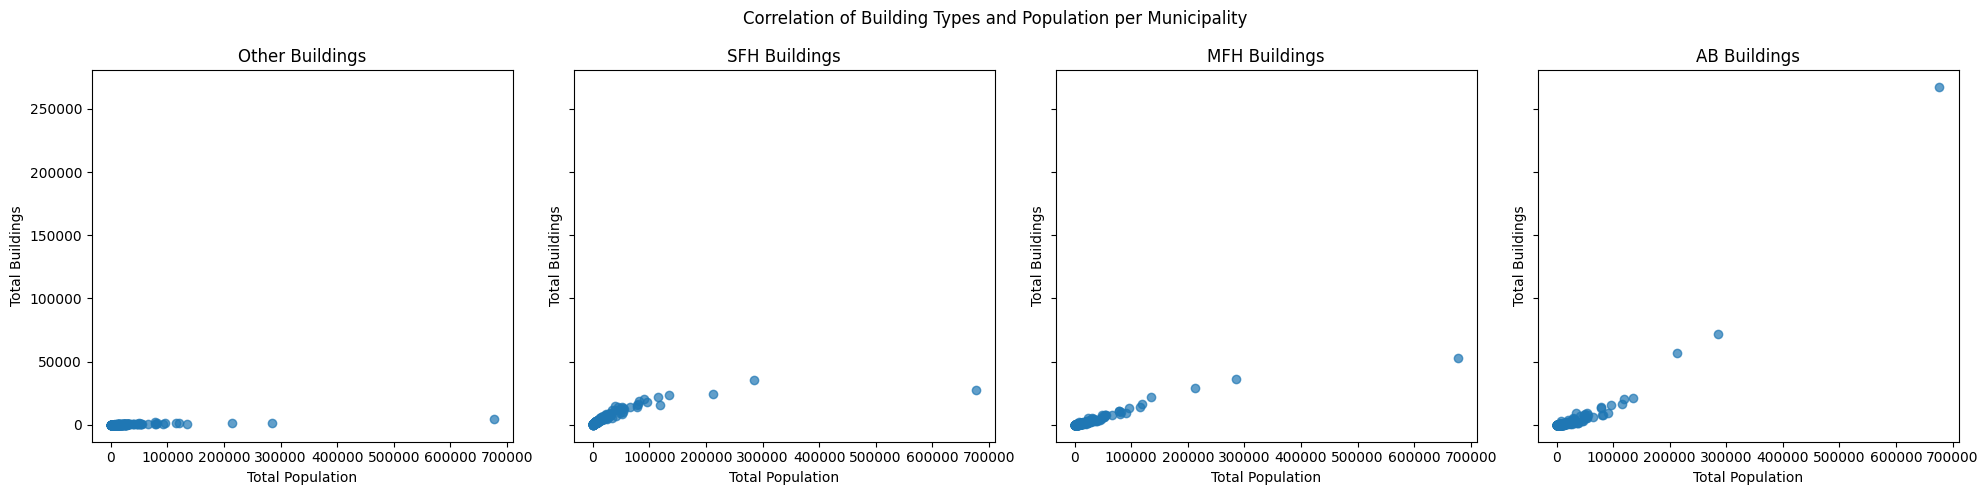

In [51]:
building_columns = [col for col in dw_06266_full_pop.columns if any(prefix in col for prefix in ['Other_', 'SFH_', 'MFH_', 'AB_'])]

# 2. Group columns by building type
building_sums = {
    "Other": dw_06266_full_pop[[col for col in building_columns if col.startswith('Other_')]].sum(axis=1),
    "SFH": dw_06266_full_pop[[col for col in building_columns if col.startswith('SFH_')]].sum(axis=1),
    "MFH": dw_06266_full_pop[[col for col in building_columns if col.startswith('MFH_')]].sum(axis=1),
    "AB": dw_06266_full_pop[[col for col in building_columns if col.startswith('AB_')]].sum(axis=1),
}

# 3. Create scatterplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)  # Updated to 1 row, 4 columns
fig.suptitle('Correlation of Building Types and Population per Municipality')

for i, (building_type, totals) in enumerate(building_sums.items()):
    axes[i].scatter(dw_06266_full_pop['pop_tot'], totals, alpha=0.7)
    axes[i].set_title(f'{building_type} Buildings')
    axes[i].set_xlabel('Total Population')
    axes[i].set_ylabel('Total Buildings')

plt.tight_layout()
plt.show()


It is aslo possible to create a more visually appealing and ineractive plot that will show the relationship between the total number of "Other", AB, MFH and SFH dwellings throughout the municipalities 

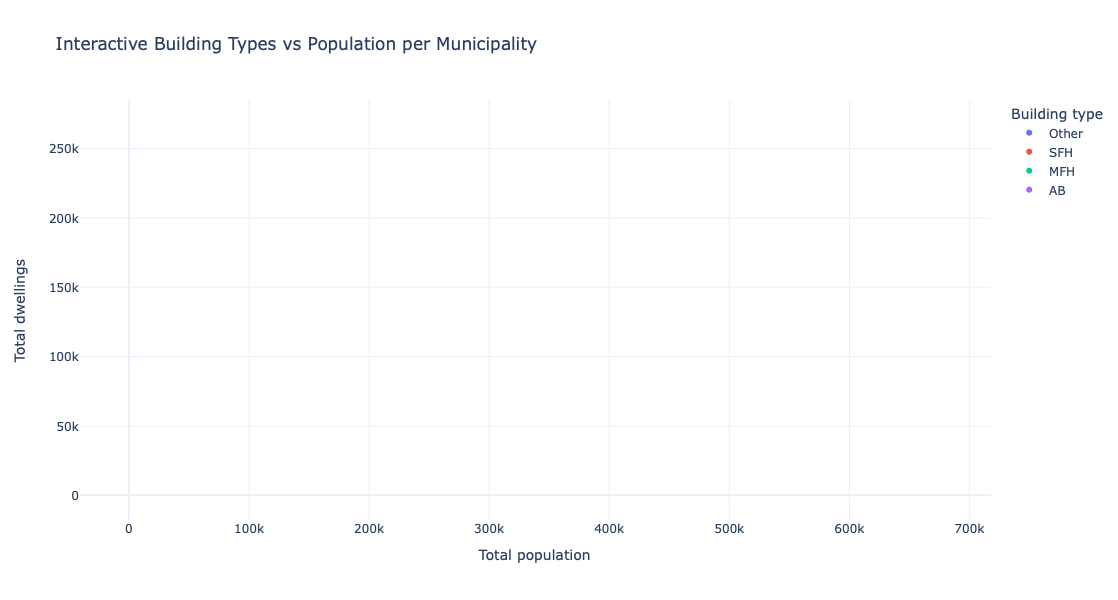

In [52]:
# Prepare data for Plotly
building_columns = [col for col in dw_06266_full_pop.columns if any(prefix in col for prefix in ['Other_', 'SFH_', 'MFH_', 'AB_'])]
dwelling_sums = {
    "Other": dw_06266_full_pop[[col for col in building_columns if col.startswith('Other_')]].sum(axis=1),
    "SFH": dw_06266_full_pop[[col for col in building_columns if col.startswith('SFH_')]].sum(axis=1),
    "MFH": dw_06266_full_pop[[col for col in building_columns if col.startswith('MFH_')]].sum(axis=1),
    "AB": dw_06266_full_pop[[col for col in building_columns if col.startswith('AB_')]].sum(axis=1),
}

# Create a DataFrame for interactive plotting
plot_data = pd.DataFrame({
    "Population": dw_06266_full_pop["pop_tot"],
    "Municipality": dw_06266_full_pop["kommunenav"],
    "Other": dwelling_sums["Other"],
    "SFH": dwelling_sums["SFH"],
    "MFH": dwelling_sums["MFH"],
    "AB": dwelling_sums["AB"],
})

# Melt the data to make it long-format for Plotly
melted_data = plot_data.melt(
    id_vars=["Population", "Municipality"], 
    value_vars=["Other", "SFH", "MFH", "AB"],
    var_name="Building type", 
    value_name="Total dwellings"
)

# Create the interactive plot
fig = px.scatter(
    melted_data,
    x="Population",
    y="Total dwellings",
    color="Building type",
    hover_name="Municipality",
    title="Interactive Building Types vs Population per Municipality",
    labels={"Population": "Total population", "Total dwellings": "Total dwellings"},
    template="plotly_white"
)

# Update layout for better interaction
fig.update_layout(
    height=600,
    width=1000,
    legend_title="Building type",
)

# Show the plot
fig.show()


It is also possible to check if the results from the interactive plot align with the relationship of a number of dwellings per capita per each dwelling type

In [53]:
pd.set_option("display.max_columns", None)  # Show all columns

In [54]:
dw_06266_full_pop["Other_per_capita"] = (
    dw_06266_full_pop[[col for col in dw_06266_full_pop.columns if col.startswith("Other_")]].sum(axis=1)
    / dw_06266_full_pop["pop_tot"]
)
dw_06266_full_pop["SFH_per_capita"] = (
    dw_06266_full_pop[[col for col in dw_06266_full_pop.columns if col.startswith("SFH_")]].sum(axis=1)
    / dw_06266_full_pop["pop_tot"]
)
dw_06266_full_pop["MFH_per_capita"] = (
    dw_06266_full_pop[[col for col in dw_06266_full_pop.columns if col.startswith("MFH_")]].sum(axis=1)
    / dw_06266_full_pop["pop_tot"]
)
dw_06266_full_pop["AB_per_capita"] = (
    dw_06266_full_pop[[col for col in dw_06266_full_pop.columns if col.startswith("AB_")]].sum(axis=1)
    / dw_06266_full_pop["pop_tot"]
)

dw_06266_full_pop

kommunenum                 kommunenav  \
0         4216                   Birkenes   
1         5053                    Inderøy   
2         3440                       Øyer   
3         4014                    Kragerø   
4         4226                 Hægebostad   
..         ...                        ...   
352       3305                  Ringerike   
353       5512  Dielddanuorri - Tjeldsund   
354       4643                      Årdal   
355       3330                        Hol   
356       1871                      Andøy   

                                              geometry  pop_tot  Other_1955  \
0    POLYGON ((101595.610 6518339.130, 101714.390 6...     5093           8   
1    POLYGON ((309171.842 7096129.147, 311210.181 7...     6781           5   
2    POLYGON ((243262.690 6812689.840, 243274.060 6...     4832           4   
3    POLYGON ((181548.000 6546623.340, 181549.370 6...    10396         121   
4    POLYGON ((50960.310 6515113.550, 50967.240 651...     1745           1   
..                                                 ...      ...         ...   
352  POLYGON ((242360.370 6685296.060, 242365.180 6...    30768         182   
353  POLYGON ((564510.020 7599694.630, 564482.550 7...     4028           4   
354  POLYGON ((107464.530 6825564.610, 108033.520 6...     5238          50   
355  POLYGON ((139552.880 6733877.850, 139558.550 6...     4461          15   
356  POLYGON ((530054.510 7627879.600, 530045.410 7...     4543          11   

     Other_1956_1970  Other_1971_1980  Other_1981_1990  Other_1991_2000  \
0                  4                3                4               19   
1                  2                0                1               21   
2                  0                9                0                6   
3                  0                1                4               46   
4                  0                0                0                0   
..               ...              ...              ...              ...   
352               28                9               28                8   
353                1                0                2                2   
354               60               10               17                8   
355                5               27               12                7   
356                9                1                1                1   

     Other_2001_2010  Other_2011_2020  Other_2021_  Unknown  AB_1955  \
0                 14               27            4       21        4   
1                  5                1            1        6        0   
2                 28                4            0       27        5   
3                 31               39            3       26       71   
4                  6                3            0        5        0   
..               ...              ...          ...      ...      ...   
352               64               43            1       74      424   
353                2                3            3        4        0   
354                2               20            1        1      147   
355               39               35            0       23        5   
356                7               11            0       42        0   

     AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  AB_2001_2010  \
0               0             0            22            45            56   
1               0             0            11            26            74   
2               0             4            26            23            25   
3               0           154            13            83           130   
4               0             0             0            14             0   
..            ...           ...           ...           ...           ...   
352           436           643           277           231           362   
353            13             1             8            23             9   
354           294            24             0          

In [55]:
dw_06266_full_pop["Closest_to"] = dw_06266_full_pop[["SFH_per_capita", "MFH_per_capita", "AB_per_capita"]].sub(
    dw_06266_full_pop["Other_per_capita"], axis=0).abs().idxmin(axis=1)

# Count how many rows are closest to each column
summary_statistics = dw_06266_full_pop["Closest_to"].value_counts()
summary_statistics

Closest_to
AB_per_capita     282
MFH_per_capita     71
SFH_per_capita      4
Name: count, dtype: int64

It is noticable that the "Other" dwellings are closer to "AB" in the majority of municipalities, and there are only 4 cases where they are closer to "SFH" 

In [56]:
dw_06266_full_pop[dw_06266_full_pop["Closest_to"] == "SFH_per_capita"]

kommunenum           kommunenav  \
66        0301                 Oslo   
121       4601               Bergen   
125       5001  Trondheim - Tråante   
271       3201                Bærum   

                                              geometry  pop_tot  Other_1955  \
66   POLYGON ((260102.430 6645441.707, 258753.600 6...   676793        1698   
121  POLYGON ((-38244.050 6735474.360, -37471.619 6...   285335         996   
125  POLYGON ((260249.217 7048364.166, 262895.680 7...   213180         717   
271  POLYGON ((243924.060 6658193.500, 243941.130 6...   119494         340   

     Other_1956_1970  Other_1971_1980  Other_1981_1990  Other_1991_2000  \
66               771              575              693              272   
121              148               84               86              177   
125               68               44              112               80   
271              136              210              235              104   

     Other_2001_2010  Other_2011_2020  Other_2021_  Unknown  AB_1955  \
66               382              248           91      204   118228   
121              124              118           10      317    25882   
125              214              106            5      116    11599   
271               87               21           53       36     2265   

     AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  AB_2001_2010  \
66          24835         28062         21010         18184         24911   
121          9749          9734          4134          3113          6427   
125          8140          7613          1575          3394          8305   
271          4012          2064          2830          1563          2643   

     AB_2011_2020  AB_2021_  SFH_1955  SFH_1956_1970  SFH_1971_1980  \
66          25241      6636      9631           2428           3628   
121          9619      3247     11536           5976           4491   
125         12079      4025      4823           4322           3909   
271          4707       704      4988           2559           1963   

     SFH_1981_1990  SFH_1991_2000  SFH_2001_2010  SFH_2011_2020  SFH_2021_  \
66            4927           2552           1562           2440        721   
121           5346           3390           2968           1714        375   
125           5645           2227           1593           1539        320   
271           2746           1525           1042            846        189   

     MFH_1955  MFH_1956_1970  MFH_1971_1980  MFH_1981_1990  MFH_1991_2000  \
66      21667           5274           6067           9385           3735   
121     10951           3676           5766           6238           3273   
125     10608           4302           4188           2767           2258   
271      5825           2308           2706           2920            830   

     MFH_2001_2010  MFH_2011_2020  MFH_2021_  Other_per_capita  \
66            3118           2872        808          0.006989   
121           3568           2027        541          0.006109   
125           2529           2133        683          0.006314   
271            717            937        211          0.009925   

     SFH_per_capita  MFH_per_capita  AB_per_capita      Closest_to  
66         0.041208        0.078201       0.394666  SFH_per_capita  
121        0.125453        0.126308       0.252002  SFH_per_capita  
125        0.114354        0.138231       0.266113  SFH_per_capita  
271        0.132710        0.137697       0.173967  SFH_per_capita

These 4 municipalities are checked above. They are also the ones that are the most populated in Norway, and it means that there are more AB buildings in general, and the amount of "Other" and "SHF" is quite small + the population numbers are higher. 

Now it is possible to use this data to sum the values from "Other" with the corresponding archetypes that they are the closest to. 

In [57]:
# Step 1: Create a copy of the dataset
dw_06266_other_incl = dw_06266_full_pop.copy()

# Step 2: Define the building types to process
building_types = ["AB", "SFH", "MFH"]

# Step 3: Iterate over each building type and update the columns
for building_type in building_types:
    # Filter rows where Closest_to matches the current building type
    closest_rows = dw_06266_other_incl["Closest_to"] == f"{building_type}_per_capita"

    # Identify columns for "Other_" and the current building type
    other_columns = [col for col in dw_06266_other_incl.columns if col.startswith("Other_") and not col.endswith("_per_capita")]
    target_columns = [col for col in dw_06266_other_incl.columns if col.startswith(f"{building_type}_") and not col.endswith("_per_capita")]

    # Sort the columns by year (assuming format like "Other_1955")
    other_columns_sorted = sorted(other_columns, key=lambda x: int(x.split("_")[1]))  # Sort by year
    target_columns_sorted = sorted(target_columns, key=lambda x: int(x.split("_")[1]))  # Sort by year

    # Check that both column groups have the same number of columns
    assert len(target_columns_sorted) == len(other_columns_sorted), f"Mismatch in column structure for {building_type}."

    # Add "Other_" values to the respective target building type for the filtered rows
    for target_col, other_col in zip(target_columns_sorted, other_columns_sorted):
        dw_06266_other_incl.loc[closest_rows, target_col] += dw_06266_other_incl.loc[closest_rows, other_col]

# Step 4: Drop "Other_" columns as they are no longer needed
dw_06266_other_incl.drop(columns=other_columns, inplace=True)

# Step 5: Display the updated dataset
dw_06266_other_incl = dw_06266_other_incl.drop(['kommunenav', 'geometry', 'pop_tot', 'Unknown', 'Other_per_capita','SFH_per_capita','MFH_per_capita','AB_per_capita', 'Closest_to'], axis=1)

dw_06266_other_incl

kommunenum  AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  \
0         4216       12             4             3            26   
1         5053        0             0             0            11   
2         3440        9             0            13            26   
3         4014      192             0           155            17   
4         4226        0             0             0             0   
..         ...      ...           ...           ...           ...   
352       3305      424           436           643           277   
353       5512        4            14             1            10   
354       4643      197           354            34            17   
355       3330       20             7            29            18   
356       1871       11            14             1            19   

     AB_1991_2000  AB_2001_2010  AB_2011_2020  AB_2021_  SFH_1955  \
0              64            70            93        10       523   
1              26            74           169        95       764   
2              29            53            62        24       575   
3             129           161            44        13      1829   
4              14             0            17         0       246   
..            ...           ...           ...       ...       ...   
352           231           362           770       371      3715   
353            25            11            41        13       736   
354            11            88            21         1       531   
355            20            63            44        30       602   
356            27            16            21         0      1025   

     SFH_1956_1970  SFH_1971_1980  SFH_1981_1990  SFH_1991_2000  \
0              140            345            197            108   
1              213            482            377            195   
2              215            418            305            192   
3              413            552            396            167   
4               54            100             93             80   
..             ...            ...            ...            ...   
352           1040           1302           1273            528   
353            183            410            331             93   
354            200            195            291             75   
355            210            520            359            135   
356            426            351            194             67   

     SFH_2001_2010  SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  \
0              180            188         38        14              3   
1              129            196         50        24              4   
2              104             76         19        28              6   
3              234            152         38       290             98   
4               77             56         21         9              2   
..             ...            ...        ...       ...            ...   
352            495            460        108       987            148   
353             93             78          6        14             20   
354             52             26          3       453            136   
355             99             86         22        41             21   
356            139             24          1        49             65   

     MFH_1971_1980  MFH_1981_1990  MFH_1991_2000  MFH_2001_2010  \
0               36             34             18             61   
1                5             23             59             57   
2                6             35             60             59   
3              254            151            101            118   
4                1              2              0             10   
..             ...            ...            ...            ...   
352            615            472            196            434   
353             14             38             49             10   
354             95             30             34             

And now we can check the new values in the same way as before 

In [58]:
av_heat_floor_area_dw.rename(
    columns=lambda col: col.replace("MFH", "AB")
                         .replace("TH", "MFH"),
    inplace=True
)
av_heat_floor_area_dw

Combined  AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  \
0            56.0          53.0          61.0          64.0          58.0   

Combined  AB_2001_2010  AB_2011_2020  AB_2021_  SFH_1955  SFH_1956_1970  \
0                 60.0          68.0      68.0     133.0          139.0   

Combined  SFH_1971_1980  SFH_1981_1990  SFH_1991_2000  SFH_2001_2010  \
0                 144.0          161.0          139.0          142.0   

Combined  SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  MFH_1971_1980  \
0                 152.0      152.0      88.0          101.0          100.0   

Combined  MFH_1981_1990  MFH_1991_2000  MFH_2001_2010  MFH_2011_2020  \
0                  96.0           85.0           88.0           96.0   

Combined  MFH_2021_  
0              96.0

In [59]:
av_broadcasted = pd.concat([av_heat_floor_area_dw] * len(dw_06266_other_incl), ignore_index=True)

# Now ensure column alignment
dw_numeric = dw_06266_other_incl.loc[:, dw_06266_other_incl.columns != 'kommunenum']
av_numeric = av_broadcasted.loc[:, av_broadcasted.columns != 'Combined']

dw_numeric = dw_numeric[av_numeric.columns]

# Perform element-wise multiplication
result_numeric = dw_numeric * av_numeric

# Combine with non-numeric columns
total_heated_area_other_incl = pd.concat([dw_06266_other_incl[['kommunenum']], result_numeric], axis=1)
total_heated_area_other_incl.set_index('kommunenum', inplace=True)
total_heated_area_other_incl

AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  \
kommunenum                                                                    
4216          672.0         212.0         183.0        1664.0        3712.0   
5053            0.0           0.0           0.0         704.0        1508.0   
3440          504.0           0.0         793.0        1664.0        1682.0   
4014        10752.0           0.0        9455.0        1088.0        7482.0   
4226            0.0           0.0           0.0           0.0         812.0   
...             ...           ...           ...           ...           ...   
3305        23744.0       23108.0       39223.0       17728.0       13398.0   
5512          224.0         742.0          61.0         640.0        1450.0   
4643        11032.0       18762.0        2074.0        1088.0         638.0   
3330         1120.0         371.0        1769.0        1152.0        1160.0   
1871          616.0         742.0          61.0        1216.0        1566.0   

            AB_2001_2010  AB_2011_2020  AB_2021_  SFH_1955  SFH_1956_1970  \
kommunenum                                                                  
4216              4200.0        6324.0     680.0   69559.0        19460.0   
5053              4440.0       11492.0    6460.0  101612.0        29607.0   
3440              3180.0        4216.0    1632.0   76475.0        29885.0   
4014              9660.0        2992.0     884.0  243257.0        57407.0   
4226                 0.0        1156.0       0.0   32718.0         7506.0   
...                  ...           ...       ...       ...            ...   
3305             21720.0       52360.0   25228.0  494095.0       144560.0   
5512               660.0        2788.0     884.0   97888.0        25437.0   
4643              5280.0        1428.0      68.0   70623.0        27800.0   
3330              3780.0        2992.0    2040.0   80066.0        29190.0   
1871               960.0        1428.0       0.0  136325.0        59214.0   

            SFH_1971_1980  SFH_1981_1990  SFH_1991_2000  SFH_2001_2010  \
kommunenum                                                               
4216              49680.0        31717.0        15012.0        25560.0   
5053              69408.0        60697.0        27105.0        18318.0   
3440              60192.0        49105.0        26688.0        14768.0   
4014              79488.0        63756.0        23213.0        33228.0   
4226              14400.0        14973.0        11120.0        10934.0   
...                   ...            ...            ...            ...   
3305             187488.0       204953.0        73392.0        70290.0   
5512              59040.0        53291.0        12927.0        13206.0   
4643              28080.0        46851.0        10425.0         7384.0   
3330              74880.0        57799.0        18765.0        14058.0   
1871              50544.0        31234.0         9313.0        19738.0   

            SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  MFH_1971_1980  \
kommunenum                                                                     
4216              28576.0     5776.0    1232.0          303.0         3600.0   
5053              29792.0     7600.0    2112.0          404.0          500.0   
3440              11552.0     2888.0    2464.0          606.0          600.0   
4014              23104.0     5776.0   25520.0         9898.0        25400.0   
4226               8512.0     3192.0     792.0          202.0          100.0   
...                   ...        ...       ...            ...            ...   
3305              69920.0    16416.0   86856.0        14948.0        61500.0   
5512              11856.0      912.0    1232.0         2020.0         1400.0   
4643               3952.0      456.0   39864.0        13736.0         9500.0   
3330              13072.0     3344.0    3608.0         2121.0        11600.0   
1871               3648.0      152.0    4312.0         6565

In [60]:
total_heated_area

4           AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  \
kommunenum                                                                    
3101        44912.0       16589.0       26230.0        9920.0       16414.0   
3103        36456.0       83369.0       53070.0       40192.0       39556.0   
3105        46032.0       39432.0       80154.0       31808.0       24244.0   
3107        46760.0       52894.0       66734.0       29568.0       24418.0   
3110            0.0           0.0           0.0           0.0        1044.0   
...             ...           ...           ...           ...           ...   
5628            0.0           0.0           0.0         256.0         406.0   
5630            0.0           0.0           0.0           0.0           0.0   
5632           56.0           0.0        1647.0          64.0         696.0   
5634          672.0           0.0           0.0         448.0           0.0   
5636            0.0           0.0           0.0           0.0           0.0   

4           AB_2001_2010  AB_2011_2020  AB_2021_   SFH_1955  SFH_1956_1970  \
kommunenum                                                                   
3101             16560.0       28084.0   20060.0   354977.0       155541.0   
3103             71880.0      124644.0   62152.0   412300.0       183480.0   
3105             38460.0       38420.0   33524.0   635208.0       282031.0   
3107             70980.0      168980.0   43860.0  1018780.0       324009.0   
3110              1440.0        5168.0     476.0    78470.0        16124.0   
...                  ...           ...       ...        ...            ...   
5628                 0.0        1904.0       0.0    40831.0        17653.0   
5630                 0.0         136.0       0.0    28329.0        16263.0   
5632               300.0         408.0       0.0    27398.0        23769.0   
5634                 0.0           0.0       0.0    50407.0        16263.0   
5636                 0.0           0.0       0.0    18354.0         5838.0   

4           SFH_1971_1980  SFH_1981_1990  SFH_1991_2000  SFH_2001_2010  \
kommunenum                                                               
3101             170064.0       160678.0        66581.0        83354.0   
3103             169920.0       186277.0       125795.0        99968.0   
3105             345744.0       332787.0        84929.0       101672.0   
3107             349344.0       440979.0       172082.0       161880.0   
3110              31968.0        49427.0        23908.0        37204.0   
...                   ...            ...            ...            ...   
5628              39312.0        44275.0        20989.0        10224.0   
5630              14544.0         2093.0          834.0         1136.0   
5632              29664.0         8533.0         7645.0         1562.0   
5634              28080.0         5152.0         5282.0          852.0   
5636              16704.0        12236.0         5421.0         2982.0   

4           SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  MFH_1971_1980  \
kommunenum                                                                     
3101             100928.0    19608.0  201168.0        43329.0        28100.0   
3103              64296.0    15504.0  163240.0        82517.0       112700.0   
3105              78128.0    24624.0  269456.0       106959.0        94200.0   
3107             152912.0    27968.0  389576.0       105242.0       116900.0   
3110              43472.0     7296.0    1760.0          707.0         1200.0   
...                   ...        ...       ...            ...            ...   
5628              12920.0     3192.0    1496.0          202.0         2600.0   
5630                912.0        0.0    5632.0          303.0          600.0   
5632               1824.0        0.0    2816.0         2424.0          200.0   
5634                608.0      456.0   19096.0         3838.0         3100.0   
5636               2280.0      304

In [61]:
total_heated_area_other_incl_melted = total_heated_area_other_incl.reset_index().melt(id_vars='kommunenum', var_name='archetype', value_name='total_heated_area')
total_heated_area_other_incl_melted

kommunenum  archetype  total_heated_area
0          4216    AB_1955              672.0
1          5053    AB_1955                0.0
2          3440    AB_1955              504.0
3          4014    AB_1955            10752.0
4          4226    AB_1955                0.0
...         ...        ...                ...
8563       3305  MFH_2021_             8064.0
8564       5512  MFH_2021_             2304.0
8565       4643  MFH_2021_                0.0
8566       3330  MFH_2021_              960.0
8567       1871  MFH_2021_                0.0

[8568 rows x 3 columns]

In [62]:
heated_area_other_mi_merged = pd.merge(
    total_heated_area_other_incl_melted,
    mi_area_merged,
    left_on='archetype',
    right_on='Archetype')
heated_area_other_mi_merged['total_material_amounts'] = heated_area_other_mi_merged['Material_intensity'] * heated_area_other_mi_merged['total_heated_area']
final_merge_other_inc = municipal_masks_2024.merge(heated_area_other_mi_merged, left_on='kommunenum', right_on='kommunenum')
final_merge_other_inc

kommunenum kommunenav  \
0           4216   Birkenes   
1           4216   Birkenes   
2           4216   Birkenes   
3           4216   Birkenes   
4           4216   Birkenes   
...          ...        ...   
82819       1871      Andøy   
82820       1871      Andøy   
82821       1871      Andøy   
82822       1871      Andøy   
82823       1871      Andøy   

                                                geometry archetype_x  \
0      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
1      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
2      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
3      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
4      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
...                                                  ...         ...   
82819  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82820  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82821  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82822  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82823  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   

       total_heated_area  Archetype  DB_Area  DB_Basement  DB_total  \
0                  672.0    AB_1955    728.7        155.4     884.1   
1                  672.0    AB_1955    728.7        155.4     884.1   
2                  672.0    AB_1955    728.7        155.4     884.1   
3                  672.0    AB_1955    728.7        155.4     884.1   
4                  672.0    AB_1955    728.7        155.4     884.1   
...                  ...        ...      ...          ...       ...   
82819                0.0  MFH_2021_    386.3        141.7     528.0   
82820                0.0  MFH_2021_    386.3        141.7     528.0   
82821                0.0  MFH_2021_    386.3        141.7     528.0   
82822                0.0  MFH_2021_    386.3        141.7     528.0   
82823                0.0  MFH_2021_    386.3        141.7     528.0   

      archetype_y             Material type         Value  Material_intensity  \
0         AB_1955                    cement  7.622219e+04          104.600237   
1         AB_1955                  concrete  1.302233e+06         1787.063210   
2         AB_1955        concrete surrogate  3.320891e+05          455.728194   
3         AB_1955  construction grade steel  2.216751e+04           30.420632   
4         AB_1955                     glass  5.295722e+03            7.267355   
...           ...                       ...           ...                 ...   
82819   MFH_2021_                insulation  6.105143e+03           15.804150   
82820   MFH_2021_                     other  1.931478e+04           49.999420   
82821   MFH_2021_    wood and wood products  6.949757e+04          179.905695   
82822   MFH_2021_            wood surrogate  4.614783e+03           11.946111   
82823   MFH_2021_                     TOTAL  2.122204e+05          549.366878   

       total_material_amounts  
0                7.029136e+04  
1                1.200906e+06  
2                3.062493e+05  
3                2.044266e+04  
4                4.883663e+03  
...                       ...  
82819            0.000000e+00  
82820            0.000000e+00  
82821            0.000000e+00  
82822            0.000000e+00  
82823            0.000000e+00  

[82824 rows x 14 columns]

In [63]:
ab_sum_olso3 = final_merge_other_inc[
    (final_merge_other_inc["Material type"] == "TOTAL") & 
    (final_merge_other_inc["kommunenav"] == "Oslo") & 
    (final_merge_other_inc["Archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with MFH
mfh_sum_olso3 = final_merge_other_inc[
    (final_merge_other_inc["Material type"] == "TOTAL") & 
    (final_merge_other_inc["kommunenav"] == "Oslo") & 
    (final_merge_other_inc["Archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with SFH
sfh_sum_olso3 = final_merge_other_inc[
    (final_merge_other_inc["Material type"] == "TOTAL") & 
    (final_merge_other_inc["kommunenav"] == "Oslo") & 
    (final_merge_other_inc["Archetype"].str.startswith("SFH"))
].total_material_amounts.sum() / 1000000000

# Print the results
print(f"Sum for AB archetypes: {ab_sum_olso3} Mt")
print(f"Sum for MFH archetypes: {mfh_sum_olso3} Mt")
print(f"Sum for SFH archetypes: {sfh_sum_olso3} Mt")

Sum for AB archetypes: 31.39683380154559 Mt
Sum for MFH archetypes: 4.420604291123194 Mt
Sum for SFH archetypes: 4.3253854610452835 Mt


In [64]:
ab_sum_moss3 = final_merge_other_inc[
    (final_merge_other_inc["Material type"] == "TOTAL") & 
    (final_merge_other_inc["kommunenav"] == "Moss") & 
    (final_merge_other_inc["Archetype"].str.startswith("AB"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with MFH
mfh_sum_moss3 = final_merge_other_inc[
    (final_merge_other_inc["Material type"] == "TOTAL") & 
    (final_merge_other_inc["kommunenav"] == "Moss") & 
    (final_merge_other_inc["Archetype"].str.startswith("MFH"))
].total_material_amounts.sum() / 1000000000

# Filter and calculate the sum for archetypes starting with SFH
sfh_sum_moss3 = final_merge_other_inc[
    (final_merge_other_inc["Material type"] == "TOTAL") & 
    (final_merge_other_inc["kommunenav"] == "Moss") & 
    (final_merge_other_inc["Archetype"].str.startswith("SFH"))
].total_material_amounts.sum() / 1000000000

# Print the results
print(f"Sum for AB archetypes: {ab_sum_moss3} Mt")
print(f"Sum for MFH archetypes: {mfh_sum_moss3} Mt")
print(f"Sum for SFH archetypes: {sfh_sum_moss3} Mt")

Sum for AB archetypes: 0.7193526122912295 Mt
Sum for MFH archetypes: 0.5284765990245083 Mt
Sum for SFH archetypes: 1.1808772195015886 Mt


## Compare datasets with and without Other

Check the variance of data with and without Other dwellings

without Other: final_merge

with other: final_merge_other_inc

In [65]:
final_merge

kommunenum kommunenav  \
0           4216   Birkenes   
1           4216   Birkenes   
2           4216   Birkenes   
3           4216   Birkenes   
4           4216   Birkenes   
...          ...        ...   
82819       1871      Andøy   
82820       1871      Andøy   
82821       1871      Andøy   
82822       1871      Andøy   
82823       1871      Andøy   

                                                geometry archetype_x  \
0      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
1      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
2      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
3      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
4      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
...                                                  ...         ...   
82819  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82820  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82821  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82822  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82823  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   

       total_heated_area  Archetype  DB_Area  DB_Basement  DB_total  \
0                  224.0    AB_1955    728.7        155.4     884.1   
1                  224.0    AB_1955    728.7        155.4     884.1   
2                  224.0    AB_1955    728.7        155.4     884.1   
3                  224.0    AB_1955    728.7        155.4     884.1   
4                  224.0    AB_1955    728.7        155.4     884.1   
...                  ...        ...      ...          ...       ...   
82819                0.0  MFH_2021_    386.3        141.7     528.0   
82820                0.0  MFH_2021_    386.3        141.7     528.0   
82821                0.0  MFH_2021_    386.3        141.7     528.0   
82822                0.0  MFH_2021_    386.3        141.7     528.0   
82823                0.0  MFH_2021_    386.3        141.7     528.0   

      archetype_y             Material type         Value  Material_intensity  \
0         AB_1955                    cement  7.622219e+04          104.600237   
1         AB_1955                  concrete  1.302233e+06         1787.063210   
2         AB_1955        concrete surrogate  3.320891e+05          455.728194   
3         AB_1955  construction grade steel  2.216751e+04           30.420632   
4         AB_1955                     glass  5.295722e+03            7.267355   
...           ...                       ...           ...                 ...   
82819   MFH_2021_                insulation  6.105143e+03           15.804150   
82820   MFH_2021_                     other  1.931478e+04           49.999420   
82821   MFH_2021_    wood and wood products  6.949757e+04          179.905695   
82822   MFH_2021_            wood surrogate  4.614783e+03           11.946111   
82823   MFH_2021_                     TOTAL  2.122204e+05          549.366878   

       total_material_amounts  
0                23430.453066  
1               400302.158947  
2               102083.115380  
3                 6814.221562  
4                 1627.887561  
...                       ...  
82819                0.000000  
82820                0.000000  
82821                0.000000  
82822                0.000000  
82823                0.000000  

[82824 rows x 14 columns]

In [66]:
final_merge_other_inc

kommunenum kommunenav  \
0           4216   Birkenes   
1           4216   Birkenes   
2           4216   Birkenes   
3           4216   Birkenes   
4           4216   Birkenes   
...          ...        ...   
82819       1871      Andøy   
82820       1871      Andøy   
82821       1871      Andøy   
82822       1871      Andøy   
82823       1871      Andøy   

                                                geometry archetype_x  \
0      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
1      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
2      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
3      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
4      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
...                                                  ...         ...   
82819  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82820  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82821  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82822  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82823  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   

       total_heated_area  Archetype  DB_Area  DB_Basement  DB_total  \
0                  672.0    AB_1955    728.7        155.4     884.1   
1                  672.0    AB_1955    728.7        155.4     884.1   
2                  672.0    AB_1955    728.7        155.4     884.1   
3                  672.0    AB_1955    728.7        155.4     884.1   
4                  672.0    AB_1955    728.7        155.4     884.1   
...                  ...        ...      ...          ...       ...   
82819                0.0  MFH_2021_    386.3        141.7     528.0   
82820                0.0  MFH_2021_    386.3        141.7     528.0   
82821                0.0  MFH_2021_    386.3        141.7     528.0   
82822                0.0  MFH_2021_    386.3        141.7     528.0   
82823                0.0  MFH_2021_    386.3        141.7     528.0   

      archetype_y             Material type         Value  Material_intensity  \
0         AB_1955                    cement  7.622219e+04          104.600237   
1         AB_1955                  concrete  1.302233e+06         1787.063210   
2         AB_1955        concrete surrogate  3.320891e+05          455.728194   
3         AB_1955  construction grade steel  2.216751e+04           30.420632   
4         AB_1955                     glass  5.295722e+03            7.267355   
...           ...                       ...           ...                 ...   
82819   MFH_2021_                insulation  6.105143e+03           15.804150   
82820   MFH_2021_                     other  1.931478e+04           49.999420   
82821   MFH_2021_    wood and wood products  6.949757e+04          179.905695   
82822   MFH_2021_            wood surrogate  4.614783e+03           11.946111   
82823   MFH_2021_                     TOTAL  2.122204e+05          549.366878   

       total_material_amounts  
0                7.029136e+04  
1                1.200906e+06  
2                3.062493e+05  
3                2.044266e+04  
4                4.883663e+03  
...                       ...  
82819            0.000000e+00  
82820            0.000000e+00  
82821            0.000000e+00  
82822            0.000000e+00  
82823            0.000000e+00  

[82824 rows x 14 columns]

In [67]:
# Load datasets
old_data = final_merge.copy() # Without "other" dwellings
new_data = final_merge_other_inc.copy()  # With "other" dwellings

# Summarize total material amounts
total_old = old_data['total_material_amounts'].sum()
total_new = new_data['total_material_amounts'].sum()

total_diff = total_new - total_old
percent_change = (total_diff / total_old) * 100

print(f"Total Material Amounts (Old): {total_old:.2f} kg")
print(f"Total Material Amounts (New): {total_new:.2f} kg")
print(f"Absolute Difference: {total_diff:.2f} kg, {total_diff / 1_000_000_000:.2f} Mt")
print(f"Percentage Change: {percent_change:.2f}%\n")


Total Material Amounts (Old): 573272429348.88 kg
Total Material Amounts (New): 585944658310.21 kg
Absolute Difference: 12672228961.33 kg, 12.67 Mt
Percentage Change: 2.21%



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



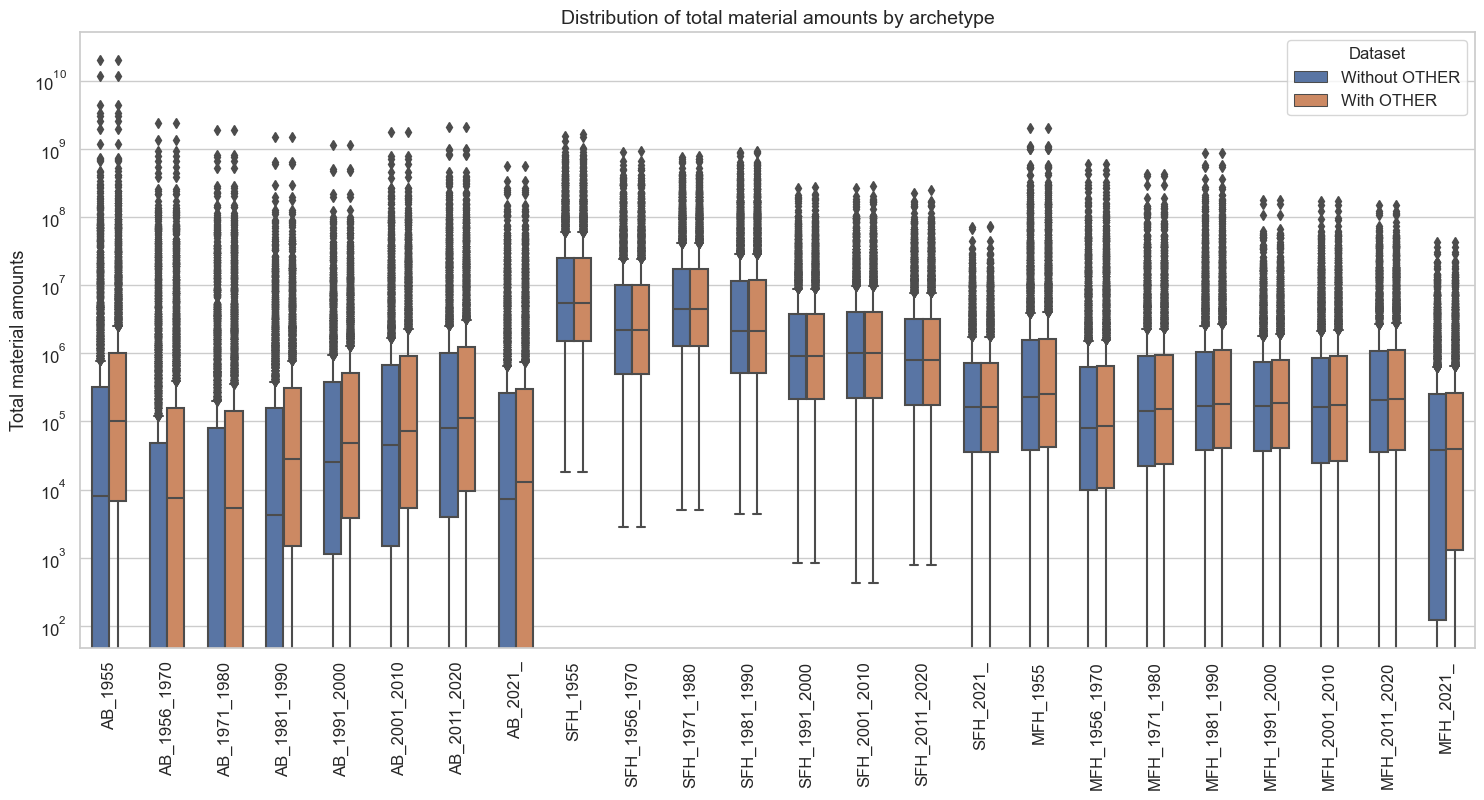

In [68]:
# Aggregate by archetype

# Add dataset labels for differentiation
old_data['Dataset'] = 'Without OTHER'
new_data['Dataset'] = 'With OTHER'

# Concatenate both datasets for visualization
combined_data = pd.concat([old_data, new_data])

# Set plot style
sns.set(style="whitegrid")

# Create box plots to compare the distribution of total material amounts
plt.figure(figsize=(18, 8))  # Increased figure size
sns.boxplot(x='Archetype', y='total_material_amounts', hue='Dataset', data=combined_data, width=0.6)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)  # Increased font size
plt.yticks(fontsize=12)

# Optional: Use log scale if values vary greatly
plt.yscale('log')  # Uncomment this line if needed

plt.title('Distribution of total material amounts by archetype', fontsize=14)
plt.ylabel('Total material amounts', fontsize=13)
plt.xlabel(None)

# Adjust legend position
plt.legend(title='Dataset', loc='upper right', fontsize=12)

# Show plot
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



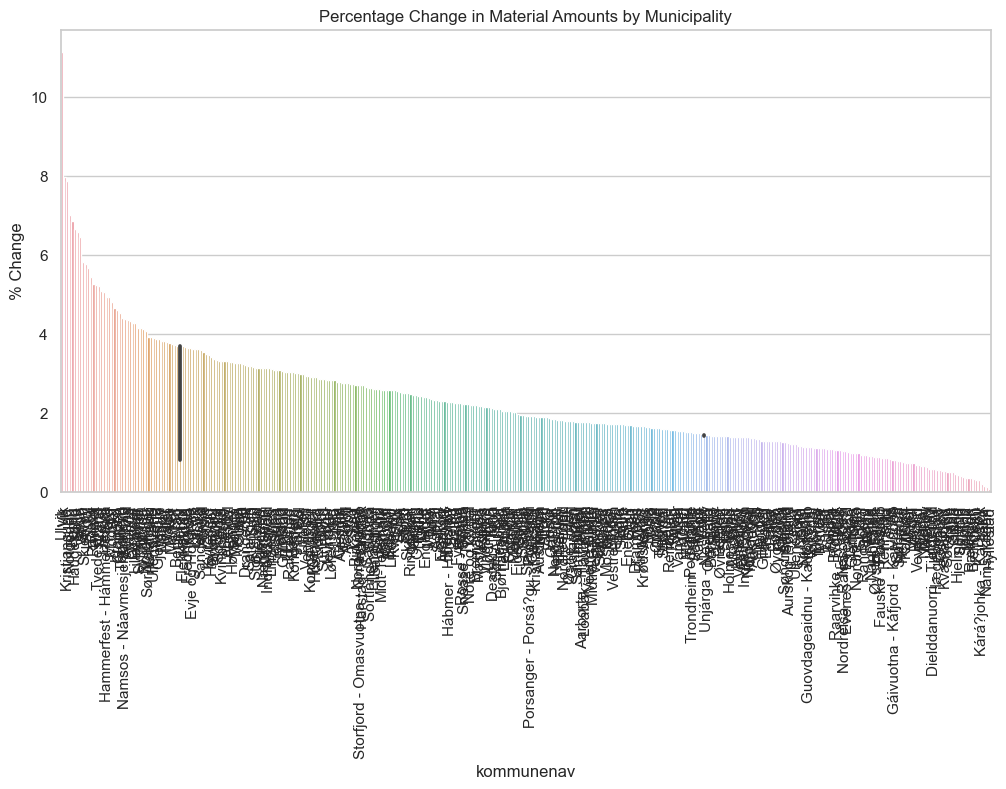

In [69]:
# Aggregate by municipality
muni_old = old_data.groupby(['kommunenum', 'kommunenav'])['total_material_amounts'].sum().reset_index()
muni_new = new_data.groupby(['kommunenum', 'kommunenav'])['total_material_amounts'].sum().reset_index()

muni_comparison = muni_old.merge(muni_new, on=['kommunenum', 'kommunenav'], suffixes=('_old', '_new'))
muni_comparison['diff'] = muni_comparison['total_material_amounts_new'] - muni_comparison['total_material_amounts_old']
muni_comparison['percent_change'] = (muni_comparison['diff'] / muni_comparison['total_material_amounts_old']) * 100

# Municipality-level changes
plt.figure(figsize=(12, 6))
sns.barplot(x='kommunenav', y='percent_change', data=muni_comparison.sort_values('percent_change', ascending=False))
plt.xticks(rotation=90)
plt.title('Percentage Change in Material Amounts by Municipality')
plt.ylabel('% Change')
plt.show()

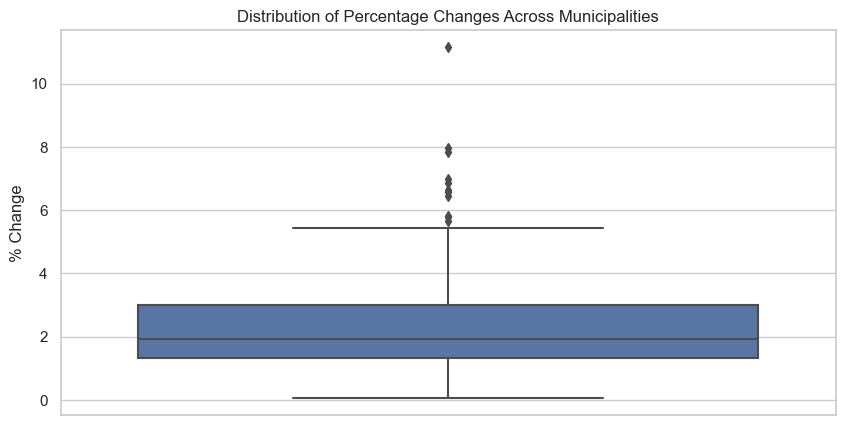

In [70]:
plt.figure(figsize=(10, 5))
sns.boxplot(y=muni_comparison['percent_change'])
plt.title('Distribution of Percentage Changes Across Municipalities')
plt.ylabel('% Change')
plt.show()

In [71]:
# Compute IQR
Q1 = muni_comparison['percent_change'].quantile(0.25)
Q3 = muni_comparison['percent_change'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outlier municipalities
outliers = muni_comparison[(muni_comparison['percent_change'] < lower_bound) | 
                           (muni_comparison['percent_change'] > upper_bound)]

print("Outlier Municipalities:")
print(outliers[['kommunenum', 'kommunenav', 'percent_change']])


Outlier Municipalities:
    kommunenum    kommunenav  percent_change
3         1106     Haugesund        6.645122
24        1505  Kristiansund        7.851981
197       4005      Notodden        6.989507
229       4221         Valle        6.565724
248       4620         Ulvik       11.140385
267       4639           Vik        7.974612
271       4643         Årdal        5.657394
279       4651         Stryn        5.815443
325       5520         Bardu        6.854446
336       5542      Skjervøy        5.766701
355       5634         Vardø        6.437190


In [72]:
dw_06266_full_pop[dw_06266_full_pop["kommunenum"] == "4620"] # Ulvik


kommunenum kommunenav                                           geometry  \
262       4620      Ulvik  POLYGON ((71010.910 6754309.030, 71226.900 675...   

     pop_tot  Other_1955  Other_1956_1970  Other_1971_1980  Other_1981_1990  \
262     1089          15                1               30               26   

     Other_1991_2000  Other_2001_2010  Other_2011_2020  Other_2021_  Unknown  \
262                6               16                0            0       32   

     AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  \
262        0             0             0             0            30   

     AB_2001_2010  AB_2011_2020  AB_2021_  SFH_1955  SFH_1956_1970  \
262            11             7         0       228             56   

     SFH_1971_1980  SFH_1981_1990  SFH_1991_2000  SFH_2001_2010  \
262             71             54             30             16   

     SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  MFH_1971_1980  \
262             19          1         8              0              6   

     MFH_1981_1990  MFH_1991_2000  MFH_2001_2010  MFH_2011_2020  MFH_2021_  \
262             20             11              0              0          0   

     Other_per_capita  SFH_per_capita  MFH_per_capita  AB_per_capita  \
262          0.086318         0.43618        0.041322       0.044077   

        Closest_to  
262  AB_per_capita

In [73]:
dw_06266_full_pop[dw_06266_full_pop["kommunenum"] == "4639"] # Vik

kommunenum kommunenav                                           geometry  \
13       4639        Vik  POLYGON ((22072.980 6793352.870, 22107.630 679...   

    pop_tot  Other_1955  Other_1956_1970  Other_1971_1980  Other_1981_1990  \
13     2547          63                5                0                3   

    Other_1991_2000  Other_2001_2010  Other_2011_2020  Other_2021_  Unknown  \
13                4                1                2            5       46   

    AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  \
13        0             0             0             3            24   

    AB_2001_2010  AB_2011_2020  AB_2021_  SFH_1955  SFH_1956_1970  \
13            10            38         0       445             92   

    SFH_1971_1980  SFH_1981_1990  SFH_1991_2000  SFH_2001_2010  SFH_2011_2020  \
13            150            144            163             62             61   

    SFH_2021_  MFH_1955  MFH_1956_1970  MFH_1971_1980  MFH_1981_1990  \
13          8         4              0              3              0   

    MFH_1991_2000  MFH_2001_2010  MFH_2011_2020  MFH_2021_  Other_per_capita  \
13              5              3             20          5          0.032587   

    SFH_per_capita  MFH_per_capita  AB_per_capita     Closest_to  
13        0.441696        0.015705       0.029446  AB_per_capita

In [74]:
dw_06266_full_pop[dw_06266_full_pop["kommunenum"] == "1505"] # Kristiansund

kommunenum    kommunenav  \
167       1505  Kristiansund   

                                              geometry  pop_tot  Other_1955  \
167  POLYGON ((131073.775 7019767.871, 131042.930 7...    24393         497   

     Other_1956_1970  Other_1971_1980  Other_1981_1990  Other_1991_2000  \
167               26               61               39                8   

     Other_2001_2010  Other_2011_2020  Other_2021_  Unknown  AB_1955  \
167               72               12           10        0      446   

     AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  AB_2001_2010  \
167           102           577            42           108           275   

     AB_2011_2020  AB_2021_  SFH_1955  SFH_1956_1970  SFH_1971_1980  \
167           177        52      1314            452           1027   

     SFH_1981_1990  SFH_1991_2000  SFH_2001_2010  SFH_2011_2020  SFH_2021_  \
167            945            232            339            263         64   

     MFH_1955  MFH_1956_1970  MFH_1971_1980  MFH_1981_1990  MFH_1991_2000  \
167      3144            456            739            306            288   

     MFH_2001_2010  MFH_2011_2020  MFH_2021_  Other_per_capita  \
167            263            313         84          0.029722   

     SFH_per_capita  MFH_per_capita  AB_per_capita     Closest_to  
167        0.190055        0.229287       0.072931  AB_per_capita

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



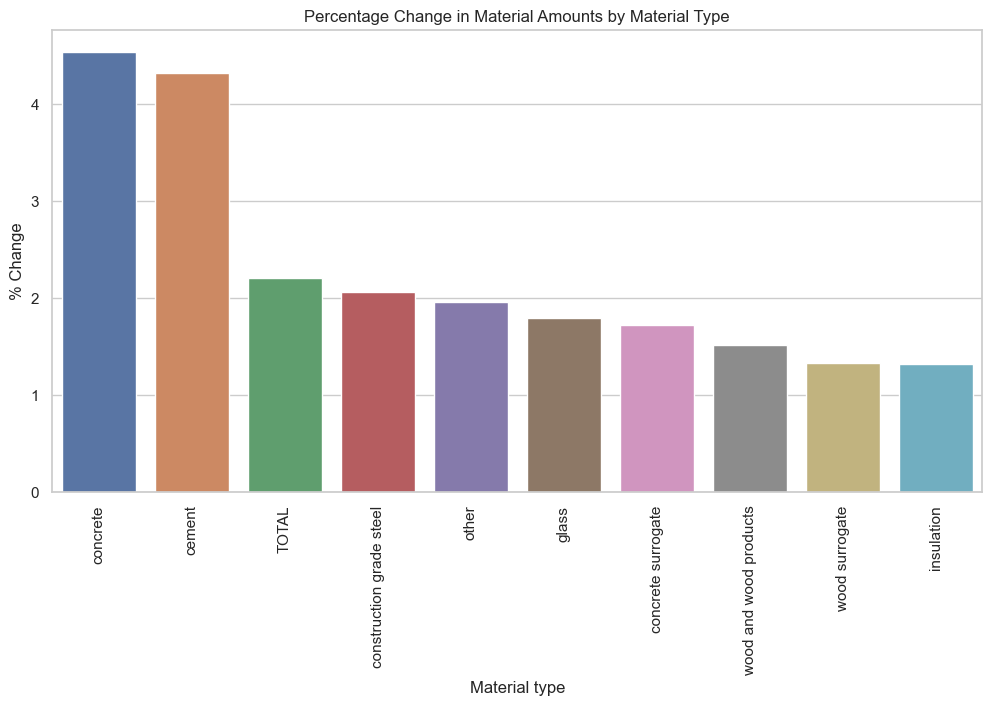

In [75]:
# Aggregate by material type
material_old = old_data.groupby('Material type')['total_material_amounts'].sum().reset_index()
material_new = new_data.groupby('Material type')['total_material_amounts'].sum().reset_index()

material_comparison = material_old.merge(material_new, on='Material type', suffixes=('_old', '_new'))
material_comparison['diff'] = material_comparison['total_material_amounts_new'] - material_comparison['total_material_amounts_old']
material_comparison['percent_change'] = (material_comparison['diff'] / material_comparison['total_material_amounts_old']) * 100

# Material type changes
plt.figure(figsize=(12, 6))
sns.barplot(x='Material type', y='percent_change', data=material_comparison.sort_values('percent_change', ascending=False))
plt.xticks(rotation=90)
plt.title('Percentage Change in Material Amounts by Material Type')
plt.ylabel('% Change')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



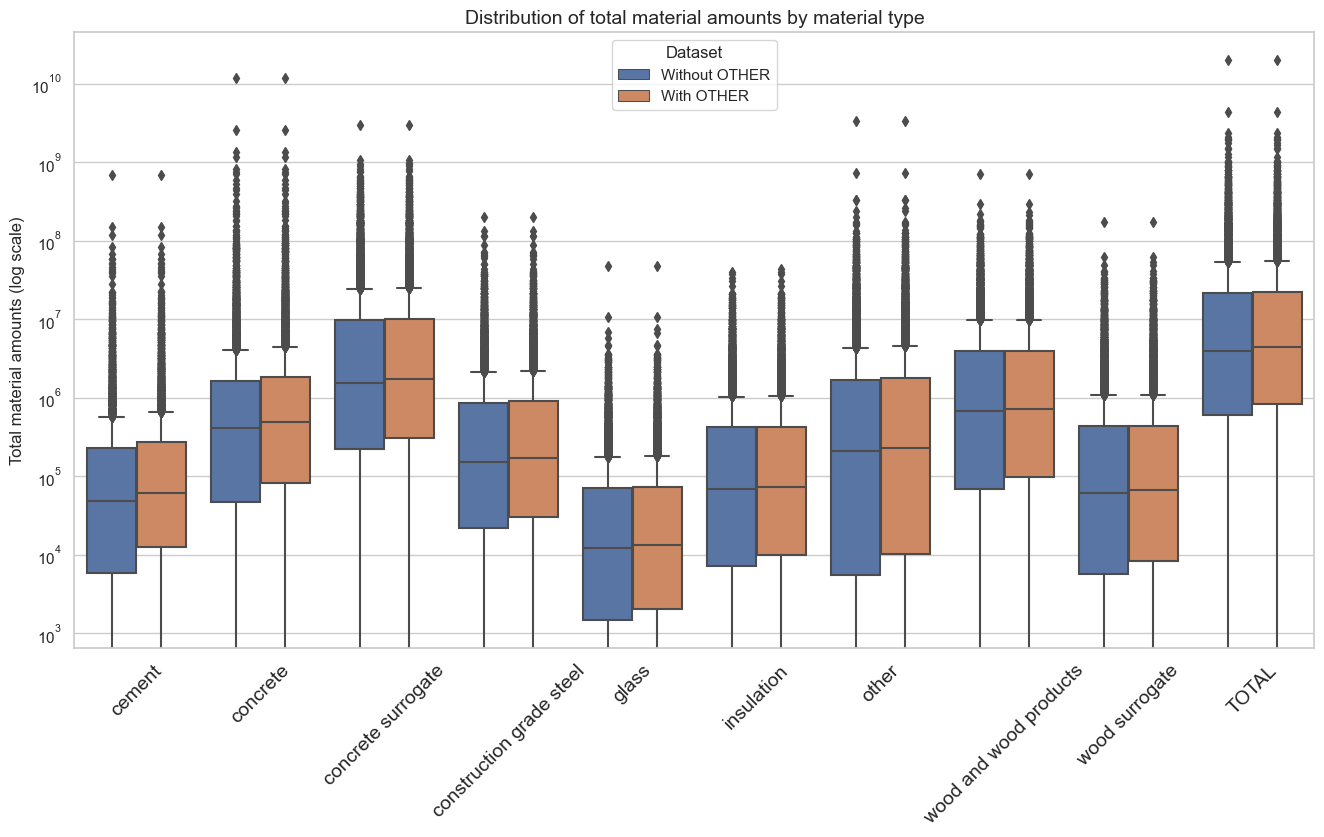

In [76]:
# Add dataset labels for differentiation
old_data['Dataset'] = 'Without OTHER'
new_data['Dataset'] = 'With OTHER'

# Concatenate both datasets for visualization
combined_data = pd.concat([old_data, new_data])

sns.set(style="whitegrid")

# Create a larger figure for better visibility
plt.figure(figsize=(16, 8))  

# Create box plots to compare the distribution of total material amounts by material type
ax = sns.boxplot(x='Material type', y='total_material_amounts', hue='Dataset', data=combined_data)

# Apply log scale if values vary too much
ax.set_yscale("log")  

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14)

# Improve title and labels
plt.title('Distribution of total material amounts by material type', fontsize=14)
plt.ylabel('Total material amounts (log scale)', fontsize=12)
plt.xlabel('')  # Remove x-label if not needed

# Show plot
plt.show()

## Plot of material intensities per capita

These plots are for statistics, they were also checked with the results from Lola's paper

In [77]:
mat_intensity_pop_merge = pd.merge(
    final_merge,                           # Main dataset
    municipalities_with_population[['kommunenum','pop_tot']],  # Columns to join
    on='kommunenum',                       # Common column
    how='left'                             # Preserve all rows from final_merge
)
mat_intensity_pop_merge

kommunenum kommunenav  \
0           4216   Birkenes   
1           4216   Birkenes   
2           4216   Birkenes   
3           4216   Birkenes   
4           4216   Birkenes   
...          ...        ...   
82819       1871      Andøy   
82820       1871      Andøy   
82821       1871      Andøy   
82822       1871      Andøy   
82823       1871      Andøy   

                                                geometry archetype_x  \
0      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
1      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
2      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
3      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
4      POLYGON ((101595.610 6518339.130, 101714.390 6...     AB_1955   
...                                                  ...         ...   
82819  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82820  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82821  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82822  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   
82823  POLYGON ((530054.510 7627879.600, 530045.410 7...   MFH_2021_   

       total_heated_area  Archetype  DB_Area  DB_Basement  DB_total  \
0                  224.0    AB_1955    728.7        155.4     884.1   
1                  224.0    AB_1955    728.7        155.4     884.1   
2                  224.0    AB_1955    728.7        155.4     884.1   
3                  224.0    AB_1955    728.7        155.4     884.1   
4                  224.0    AB_1955    728.7        155.4     884.1   
...                  ...        ...      ...          ...       ...   
82819                0.0  MFH_2021_    386.3        141.7     528.0   
82820                0.0  MFH_2021_    386.3        141.7     528.0   
82821                0.0  MFH_2021_    386.3        141.7     528.0   
82822                0.0  MFH_2021_    386.3        141.7     528.0   
82823                0.0  MFH_2021_    386.3        141.7     528.0   

      archetype_y             Material type         Value  Material_intensity  \
0         AB_1955                    cement  7.622219e+04          104.600237   
1         AB_1955                  concrete  1.302233e+06         1787.063210   
2         AB_1955        concrete surrogate  3.320891e+05          455.728194   
3         AB_1955  construction grade steel  2.216751e+04           30.420632   
4         AB_1955                     glass  5.295722e+03            7.267355   
...           ...                       ...           ...                 ...   
82819   MFH_2021_                insulation  6.105143e+03           15.804150   
82820   MFH_2021_                     other  1.931478e+04           49.999420   
82821   MFH_2021_    wood and wood products  6.949757e+04          179.905695   
82822   MFH_2021_            wood surrogate  4.614783e+03           11.946111   
82823   MFH_2021_                     TOTAL  2.122204e+05          549.366878   

       total_material_amounts  pop_tot  
0                23430.453066     5093  
1               400302.158947     5093  
2               102083.115380     5093  
3                 6814.221562     5093  
4                 1627.887561     5093  
...                       ...      ...  
82819                0.000000     4543  
82820                0.000000     4543  
82821                0.000000     4543  
82822                0.000000     4543  
82823                0.000000     4543  

[82824 rows x 15 columns]

In [78]:
TOTAL_data = mat_intensity_pop_merge[mat_intensity_pop_merge["Material type"] == "TOTAL"]
TOTAL_data = TOTAL_data.drop(columns=["archetype_x", "DB_Area", "DB_Basement", "DB_total", "archetype_y"])
TOTAL_data 

kommunenum kommunenav  \
9           4216   Birkenes   
19          4216   Birkenes   
29          4216   Birkenes   
39          4216   Birkenes   
49          4216   Birkenes   
...          ...        ...   
82783       1871      Andøy   
82793       1871      Andøy   
82803       1871      Andøy   
82813       1871      Andøy   
82823       1871      Andøy   

                                                geometry  total_heated_area  \
9      POLYGON ((101595.610 6518339.130, 101714.390 6...              224.0   
19     POLYGON ((101595.610 6518339.130, 101714.390 6...                0.0   
29     POLYGON ((101595.610 6518339.130, 101714.390 6...                0.0   
39     POLYGON ((101595.610 6518339.130, 101714.390 6...             1408.0   
49     POLYGON ((101595.610 6518339.130, 101714.390 6...             2610.0   
...                                                  ...                ...   
82783  POLYGON ((530054.510 7627879.600, 530045.410 7...             1440.0   
82793  POLYGON ((530054.510 7627879.600, 530045.410 7...             1615.0   
82803  POLYGON ((530054.510 7627879.600, 530045.410 7...             2464.0   
82813  POLYGON ((530054.510 7627879.600, 530045.410 7...                0.0   
82823  POLYGON ((530054.510 7627879.600, 530045.410 7...                0.0   

           Archetype Material type         Value  Material_intensity  \
9            AB_1955         TOTAL  2.211696e+06         3035.125988   
19      AB_1956_1970         TOTAL  2.372068e+06         1788.485072   
29      AB_1971_1980         TOTAL  1.953516e+06         1107.686630   
39      AB_1981_1990         TOTAL  2.033183e+06         1096.883550   
49      AB_1991_2000         TOTAL  1.829627e+06         1093.489623   
...              ...           ...           ...                 ...   
82783  MFH_1981_1990         TOTAL  3.295214e+05          974.338709   
82793  MFH_1991_2000         TOTAL  1.612566e+05          548.865263   
82803  MFH_2001_2010         TOTAL  1.665672e+05          552.644926   
82813  MFH_2011_2020         TOTAL  2.122204e+05          549.366878   
82823      MFH_2021_         TOTAL  2.122204e+05          549.366878   

       total_material_amounts  pop_tot  
9                6.798682e+05     5093  
19               0.000000e+00     5093  
29               0.000000e+00     5093  
39               1.544412e+06     5093  
49               2.854008e+06     5093  
...                       ...      ...  
82783            1.403048e+06     4543  
82793            8.864174e+05     4543  
82803            1.361717e+06     4543  
82813            0.000000e+00     4543  
82823            0.000000e+00     4543  

[8568 rows x 10 columns]

In [79]:
summed_data = TOTAL_data.groupby(['kommunenum', 'kommunenav', 'geometry'], as_index=False).agg({
    'total_material_amounts': 'sum',  # Sum 'total_material_amounts'
    'pop_tot': 'first'  # Keep the first 'pop_tot' for each 'kommunenum'
})
summed_data

kommunenum         kommunenav  \
0         0301               Oslo   
1         1101          Eigersund   
2         1103          Stavanger   
3         1106          Haugesund   
4         1108            Sandnes   
..         ...                ...   
352       5628      Deatnu - Tana   
353       5630           Berlevåg   
354       5632          Båtsfjord   
355       5634              Vardø   
356       5636  Unjárga - Nesseby   

                                              geometry  \
0    POLYGON ((260102.430 6645441.707, 258753.600 6...   
1    POLYGON ((-21958.180 6520966.530, -21956.580 6...   
2    POLYGON ((-29201.128 6570959.109, -29471.170 6...   
3    POLYGON ((-49124.150 6623149.960, -49125.720 6...   
4    POLYGON ((-22245.720 6554013.470, -22251.980 6...   
..                                                 ...   
352  POLYGON ((1001375.840 7845982.420, 1000896.830...   
353  POLYGON ((1037426.140 7940200.490, 1042544.060...   
354  POLYGON ((1035879.380 7877514.130, 1035854.380...   
355  POLYGON ((1093794.100 7917698.950, 1097128.971...   
356  POLYGON ((1000651.810 7841677.460, 1000744.360...   

     total_material_amounts  pop_tot  
0              3.950414e+10   676793  
1              8.026948e+08    15115  
2              6.792662e+09   134458  
3              1.838145e+09    30987  
4              3.305548e+09    80086  
..                      ...      ...  
352            1.928956e+08     2621  
353            7.500088e+07      891  
354            1.167610e+08     2109  
355            1.403552e+08     1969  
356            6.802777e+07      859  

[357 rows x 5 columns]

In [80]:
summed_data["ms_per_capita"] = summed_data["total_material_amounts"]/summed_data["pop_tot"]
summed_data

kommunenum         kommunenav  \
0         0301               Oslo   
1         1101          Eigersund   
2         1103          Stavanger   
3         1106          Haugesund   
4         1108            Sandnes   
..         ...                ...   
352       5628      Deatnu - Tana   
353       5630           Berlevåg   
354       5632          Båtsfjord   
355       5634              Vardø   
356       5636  Unjárga - Nesseby   

                                              geometry  \
0    POLYGON ((260102.430 6645441.707, 258753.600 6...   
1    POLYGON ((-21958.180 6520966.530, -21956.580 6...   
2    POLYGON ((-29201.128 6570959.109, -29471.170 6...   
3    POLYGON ((-49124.150 6623149.960, -49125.720 6...   
4    POLYGON ((-22245.720 6554013.470, -22251.980 6...   
..                                                 ...   
352  POLYGON ((1001375.840 7845982.420, 1000896.830...   
353  POLYGON ((1037426.140 7940200.490, 1042544.060...   
354  POLYGON ((1035879.380 7877514.130, 1035854.380...   
355  POLYGON ((1093794.100 7917698.950, 1097128.971...   
356  POLYGON ((1000651.810 7841677.460, 1000744.360...   

     total_material_amounts  pop_tot  ms_per_capita  
0              3.950414e+10   676793   58369.603940  
1              8.026948e+08    15115   53105.841157  
2              6.792662e+09   134458   50518.835208  
3              1.838145e+09    30987   59319.890883  
4              3.305548e+09    80086   41274.978025  
..                      ...      ...            ...  
352            1.928956e+08     2621   73596.202025  
353            7.500088e+07      891   84176.069467  
354            1.167610e+08     2109   55363.210907  
355            1.403552e+08     1969   71282.462873  
356            6.802777e+07      859   79194.145153  

[357 rows x 6 columns]

/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_28494/422186276.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



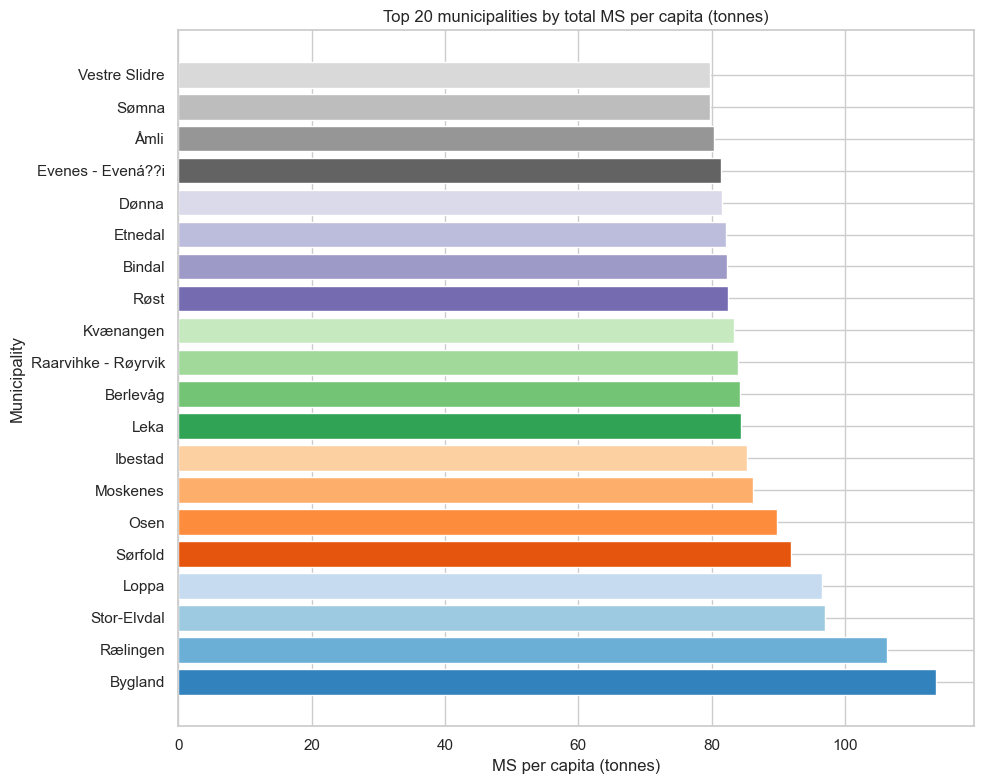

In [81]:

# 1. Sort the summed_data by 'ms_per_capita' in descending order and select the top 20 municipalities
top_20_municipalities = summed_data.sort_values(by="ms_per_capita", ascending=False).head(20)

# 2. Create a horizontal bar chart with 'ms_per_capita' divided by 1000 for tonnes
plt.figure(figsize=(10, 8))
plt.barh(top_20_municipalities["kommunenav"], top_20_municipalities["ms_per_capita"] / 1000, color=plt.cm.get_cmap("tab20c").colors)

# 3. Set labels and title
plt.xlabel("MS per capita (tonnes)")
plt.ylabel("Municipality")
plt.title("Top 20 municipalities by total MS per capita (tonnes)")

# 4. Show the plot
plt.tight_layout()
plt.show()


In [82]:
summed_data["ms_per_capita"].mean()/1000

61.85679968684772

/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_28494/3178396627.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



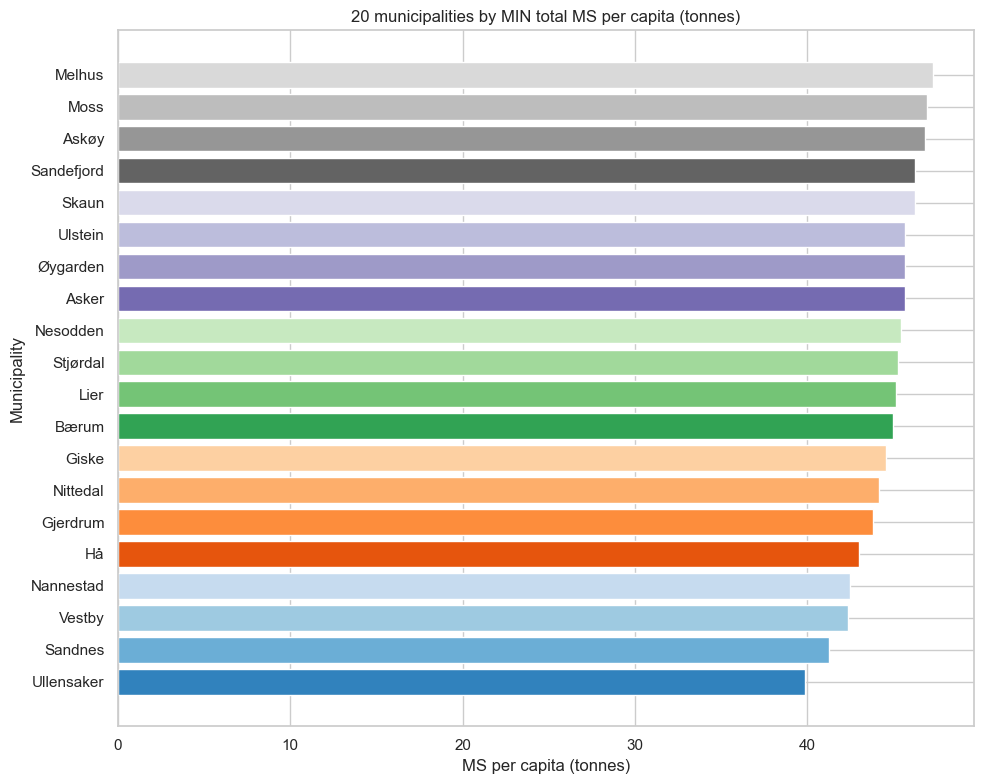

In [83]:
# 1. Sort the summed_data by 'ms_per_capita' in descending order and select the top 20 municipalities
min_20_municipalities = summed_data.sort_values(by="ms_per_capita", ascending=True).head(20)

# 2. Create a horizontal bar chart with 'ms_per_capita' divided by 1000 for tonnes
plt.figure(figsize=(10, 8))
plt.barh(min_20_municipalities["kommunenav"], min_20_municipalities["ms_per_capita"] / 1000, color=plt.cm.get_cmap("tab20c").colors)

# 3. Set labels and title
plt.xlabel("MS per capita (tonnes)")
plt.ylabel("Municipality")
plt.title("20 municipalities by MIN total MS per capita (tonnes)")

# 4. Show the plot
plt.tight_layout()
plt.show()


## Let's make the plots more informative
It will be beneficial to check the distribution of each archetype (SFH, MFH, AB) within the municipality and see of the results make sense and why in populated municipalities such as Moss and Lier the actual MS per capita is lower, I can make an assumption that this is because there is a higher nuber of AB that have a smaller MS per capita since more people live there but less material is used as if all these people were living in SFH separately. 

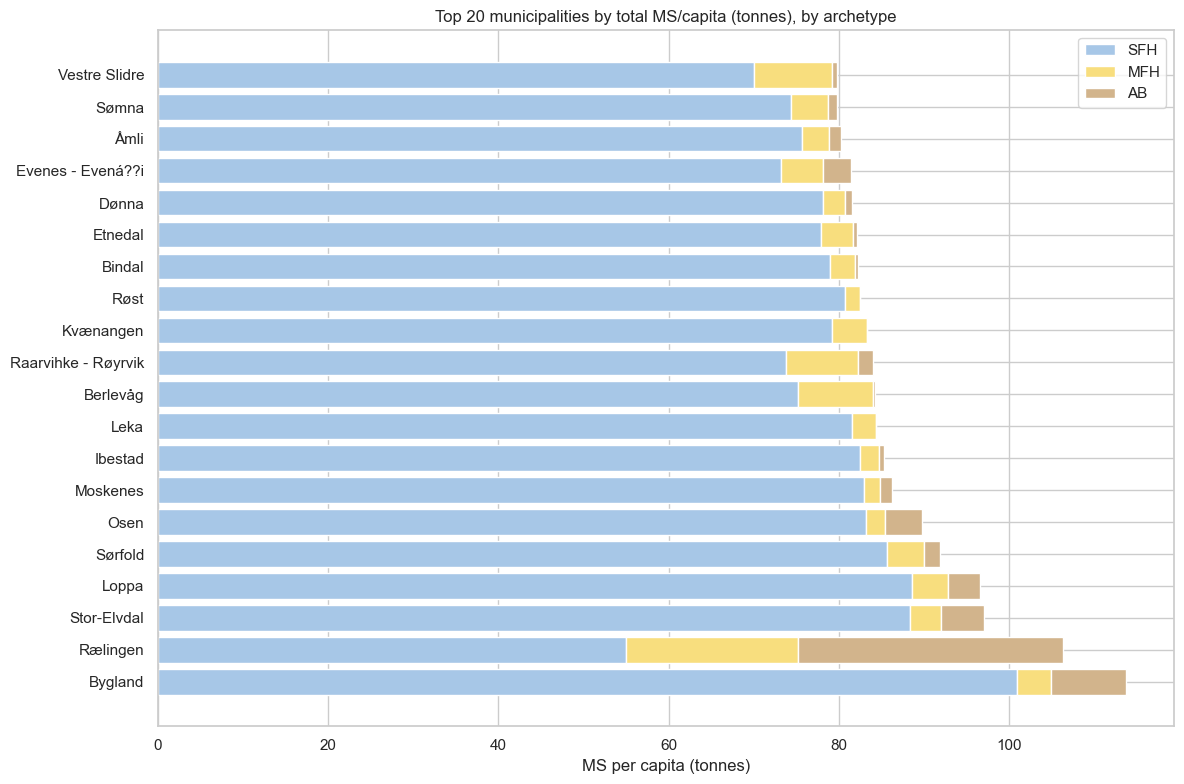

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract the building type (AB, MFH, SFH) from 'Archetype' column
TOTAL_data["Archetype_Type"] = TOTAL_data["Archetype"].str.split("_").str[0]

# 2. Aggregate total_material_amounts for each building type within each municipality
archetype_sums = TOTAL_data.groupby(['kommunenum', 'kommunenav', 'geometry', 'pop_tot', 'Archetype_Type'], as_index=False).agg({
    'total_material_amounts': 'sum'  
})

# 3. Pivot table to reshape the data: separate columns for 'AB', 'MFH', and 'SFH'
pivot_data = archetype_sums.pivot_table(index=['kommunenum', 'kommunenav', 'geometry', 'pop_tot'], 
                                        columns='Archetype_Type', 
                                        values='total_material_amounts', 
                                        fill_value=0).reset_index()

# 4. Calculate per capita values
pivot_data["ms_per_capita"] = pivot_data[['AB', 'MFH', 'SFH']].sum(axis=1) / pivot_data["pop_tot"]
pivot_data["AB_per_capita"] = pivot_data["AB"] / pivot_data["pop_tot"]
pivot_data["MFH_per_capita"] = pivot_data["MFH"] / pivot_data["pop_tot"]
pivot_data["SFH_per_capita"] = pivot_data["SFH"] / pivot_data["pop_tot"]

# 5. Select top 20 municipalities by total material stock per capita
top_20_municipalities = pivot_data.sort_values(by="ms_per_capita", ascending=False).head(20)

# 6. Define colors for MFH, SFH, and AB
colors = ["#A7C7E7", "#F8DE7E", "#D2B48C"]

# 7. Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
y_positions = np.arange(len(top_20_municipalities))

ax.barh(y_positions, top_20_municipalities["SFH_per_capita"] / 1000, color=colors[0], label="SFH")
ax.barh(y_positions, top_20_municipalities["MFH_per_capita"] / 1000, 
        left=top_20_municipalities["SFH_per_capita"] / 1000, color=colors[1], label="MFH")
ax.barh(y_positions, top_20_municipalities["AB_per_capita"] / 1000, 
        left=(top_20_municipalities["SFH_per_capita"] + top_20_municipalities["MFH_per_capita"]) / 1000, 
        color=colors[2], label="AB")

# 8. Labels and formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(top_20_municipalities["kommunenav"])
ax.set_xlabel("MS per capita (tonnes)")
ax.set_title("Top 20 municipalities by total MS/capita (tonnes), by archetype")
ax.legend()

plt.tight_layout()
plt.show()


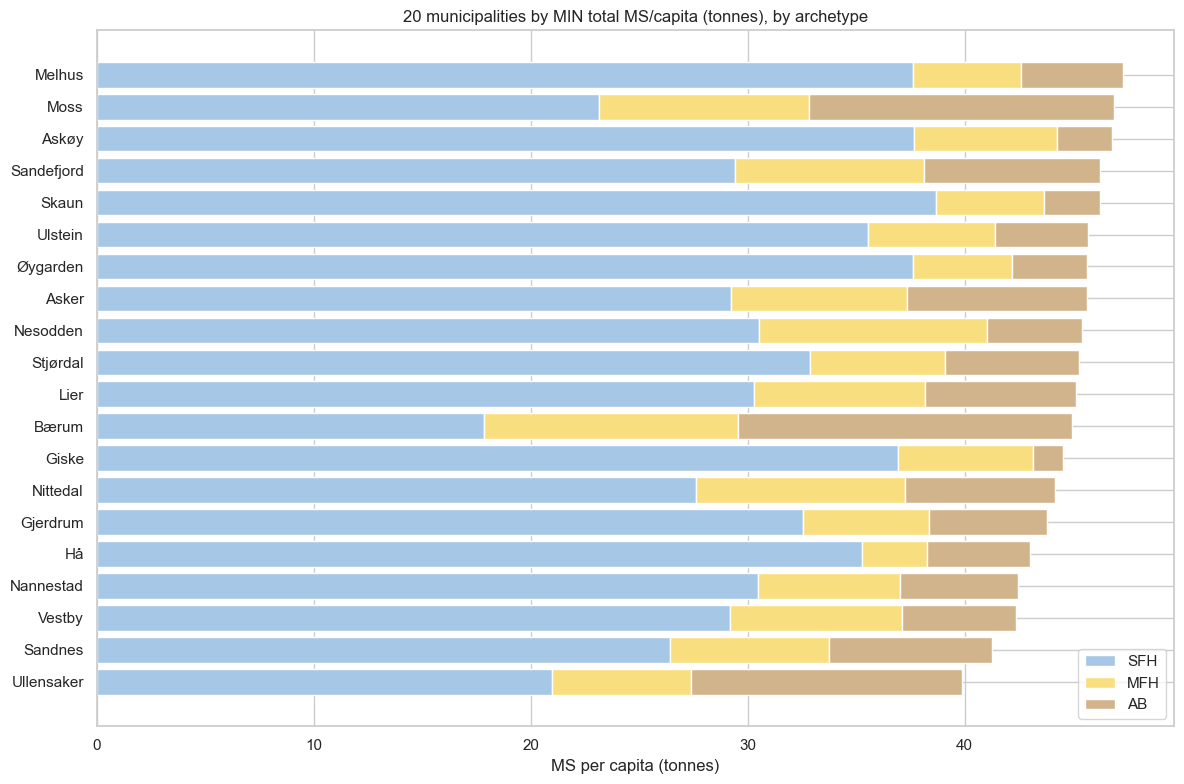

In [85]:
min_20_municipalities = pivot_data.sort_values(by="ms_per_capita", ascending=True).head(20)

# 6. Define colors for MFH, SFH, and AB
colors = ["#A7C7E7", "#F8DE7E", "#D2B48C"]

# 7. Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
y_positions = np.arange(len(min_20_municipalities))

ax.barh(y_positions, min_20_municipalities["SFH_per_capita"] / 1000, color=colors[0], label="SFH")
ax.barh(y_positions, min_20_municipalities["MFH_per_capita"] / 1000, 
        left=min_20_municipalities["SFH_per_capita"] / 1000, color=colors[1], label="MFH")
ax.barh(y_positions, min_20_municipalities["AB_per_capita"] / 1000, 
        left=(min_20_municipalities["SFH_per_capita"] + min_20_municipalities["MFH_per_capita"]) / 1000, 
        color=colors[2], label="AB")

# 8. Labels and formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(min_20_municipalities["kommunenav"])
ax.set_xlabel("MS per capita (tonnes)")
ax.set_title("20 municipalities by MIN total MS/capita (tonnes), by archetype")
ax.legend()

plt.tight_layout()
plt.show()


/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_28494/2339627274.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



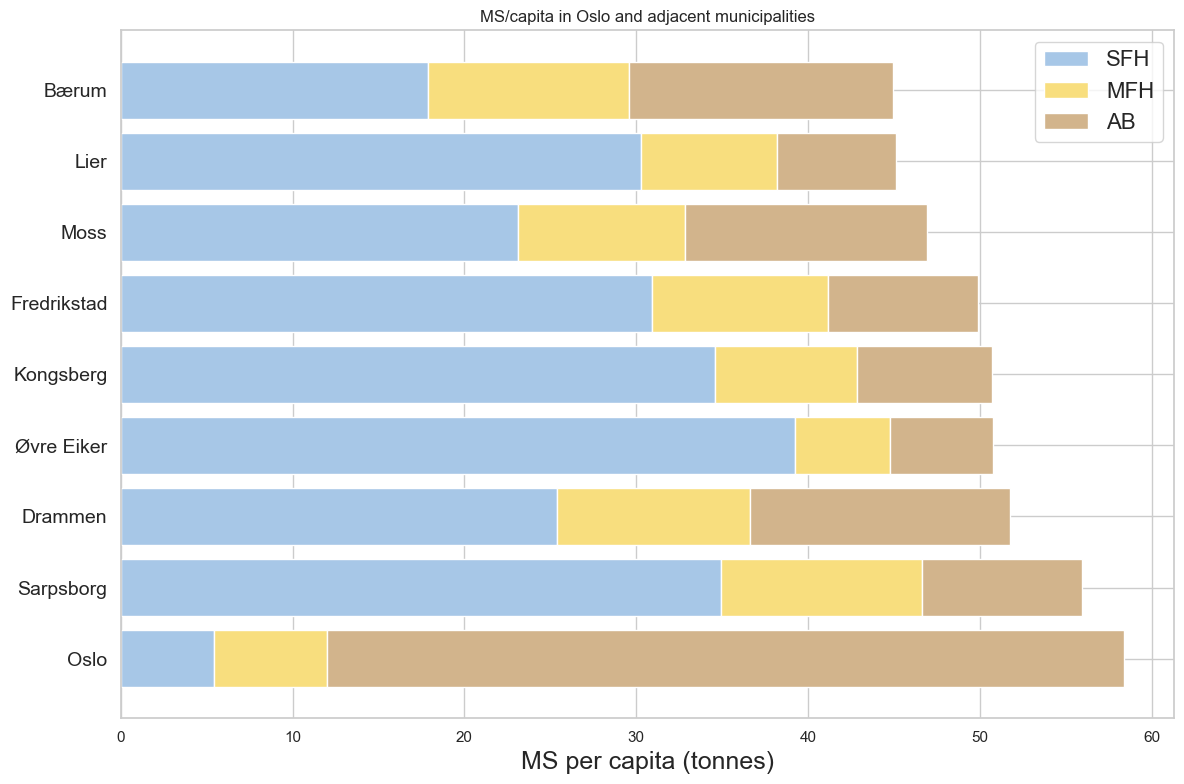

In [86]:
# Define the list of municipality codes for Oslo and adjacent municipalities (with leading zeros)
oslo_and_adj_codes = ["0301", "3103", "3105", "3107", "3301", "3303", "3312", "3201", "3314"]

# Ensure kommunenum in pivot_data is a string with leading zeros
pivot_data["kommunenum"] = pivot_data["kommunenum"].astype(str).str.zfill(4)

# Filter the dataset for the selected municipalities
oslo_and_adj = pivot_data[pivot_data["kommunenum"].isin(oslo_and_adj_codes)]

# Sort municipalities by total MS per capita
oslo_and_adj["total_ms_per_capita"] = (
    oslo_and_adj["SFH_per_capita"] + oslo_and_adj["MFH_per_capita"] + oslo_and_adj["AB_per_capita"]
)
oslo_and_adj = oslo_and_adj.sort_values(by="total_ms_per_capita", ascending=False)

# Define pastel colors for MFH, SFH, and AB
colors = ["#A7C7E7", "#F8DE7E", "#D2B48C"]

# Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
y_positions = np.arange(len(oslo_and_adj))

# Plot bars for each archetype

ax.barh(y_positions, oslo_and_adj["SFH_per_capita"] / 1000, color=colors[0], label="SFH")
ax.barh(y_positions, oslo_and_adj["MFH_per_capita"] / 1000, 
        left=oslo_and_adj["SFH_per_capita"] / 1000, color=colors[1], label="MFH")
ax.barh(y_positions, oslo_and_adj["AB_per_capita"] / 1000, 
        left=(oslo_and_adj["SFH_per_capita"] + oslo_and_adj["MFH_per_capita"]) / 1000, 
        color=colors[2], label="AB")

# Labels and formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(oslo_and_adj["kommunenav"], size = 14)
ax.set_xlabel("MS per capita (tonnes)", size = 18)
ax.set_title("MS/capita in Oslo and adjacent municipalities")
ax.legend(fontsize = 16)

plt.tight_layout()
plt.show()



Add some plots: 

- MS per km2 (kilotonnes/km2) 
- boxplot MS/capita (add color to show the size of municipalities), use quantiles 
- dwellings/capita per archetype
- mean floor area/ capita


To plot MS per km2, check the CRS of the geodata column, change it if necessary

In [87]:
TOTAL_data.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [88]:
TOTAL_data = TOTAL_data.to_crs(epsg=25833)

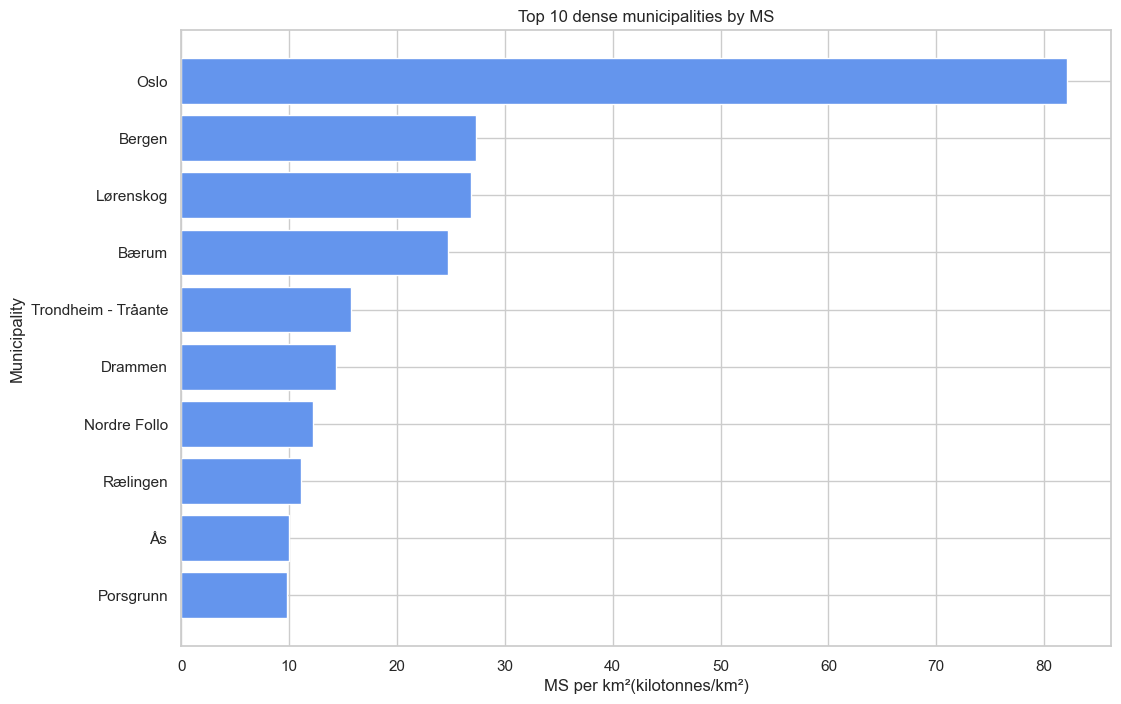

In [89]:
TOTAL_data["area_km2"] = TOTAL_data["geometry"].area / 1e6  # Convert from m² to km²
TOTAL_data["ms_density"] = TOTAL_data["total_material_amounts"] / TOTAL_data["area_km2"] / 1000000 # Convert to kilotonnes
top_10_dense = TOTAL_data.groupby(["kommunenum", "kommunenav"], as_index=False)["ms_density"].sum()
top_10_dense = top_10_dense.sort_values(by="ms_density", ascending=False).head(10)
plt.figure(figsize=(12, 8))
plt.barh(top_10_dense["kommunenav"], top_10_dense["ms_density"], color="cornflowerblue")
    
plt.xlabel("MS per km²(kilotonnes/km²)")
plt.ylabel("Municipality")
plt.title("Top 10 dense municipalities by MS")
plt.gca().invert_yaxis()  # Ensures the highest density is on top
plt.show()

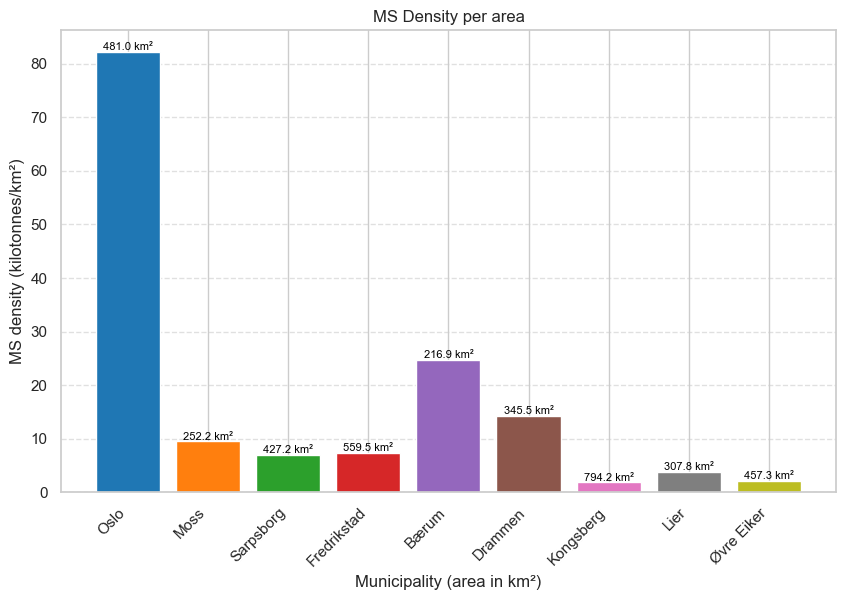

In [90]:
oslo_and_adj2 = TOTAL_data[TOTAL_data["kommunenum"].isin(oslo_and_adj_codes)]

# Group by municipality and sum material stock density
oslo_and_adj_grouped = oslo_and_adj2.groupby(["kommunenum", "kommunenav",  "area_km2"], as_index=False).agg({
    "ms_density": "sum"
})

# Set a color palette
palette = sns.color_palette("tab10", len(oslo_and_adj_grouped))

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    oslo_and_adj_grouped["kommunenav"], 
    oslo_and_adj_grouped["ms_density"], 
    color=palette
)

# Add x-axis labels (area size)
plt.xticks(rotation=45, ha="right")
for bar, area in zip(bars, oslo_and_adj_grouped["area_km2"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{area:.1f} km²", 
             ha="center", va="bottom", fontsize=8, color="black")

# Labels and title
plt.xlabel("Municipality (area in km²)")
plt.ylabel("MS density (kilotonnes/km²)")
plt.title("MS Density per area")

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

For plots dwellings/capita per archetype, mean floor area/ capita use the 3 following datasets

In [91]:
dw_06266_full_pop

kommunenum                 kommunenav  \
0         4216                   Birkenes   
1         5053                    Inderøy   
2         3440                       Øyer   
3         4014                    Kragerø   
4         4226                 Hægebostad   
..         ...                        ...   
352       3305                  Ringerike   
353       5512  Dielddanuorri - Tjeldsund   
354       4643                      Årdal   
355       3330                        Hol   
356       1871                      Andøy   

                                              geometry  pop_tot  Other_1955  \
0    POLYGON ((101595.610 6518339.130, 101714.390 6...     5093           8   
1    POLYGON ((309171.842 7096129.147, 311210.181 7...     6781           5   
2    POLYGON ((243262.690 6812689.840, 243274.060 6...     4832           4   
3    POLYGON ((181548.000 6546623.340, 181549.370 6...    10396         121   
4    POLYGON ((50960.310 6515113.550, 50967.240 651...     1745           1   
..                                                 ...      ...         ...   
352  POLYGON ((242360.370 6685296.060, 242365.180 6...    30768         182   
353  POLYGON ((564510.020 7599694.630, 564482.550 7...     4028           4   
354  POLYGON ((107464.530 6825564.610, 108033.520 6...     5238          50   
355  POLYGON ((139552.880 6733877.850, 139558.550 6...     4461          15   
356  POLYGON ((530054.510 7627879.600, 530045.410 7...     4543          11   

     Other_1956_1970  Other_1971_1980  Other_1981_1990  Other_1991_2000  \
0                  4                3                4               19   
1                  2                0                1               21   
2                  0                9                0                6   
3                  0                1                4               46   
4                  0                0                0                0   
..               ...              ...              ...              ...   
352               28                9               28                8   
353                1                0                2                2   
354               60               10               17                8   
355                5               27               12                7   
356                9                1                1                1   

     Other_2001_2010  Other_2011_2020  Other_2021_  Unknown  AB_1955  \
0                 14               27            4       21        4   
1                  5                1            1        6        0   
2                 28                4            0       27        5   
3                 31               39            3       26       71   
4                  6                3            0        5        0   
..               ...              ...          ...      ...      ...   
352               64               43            1       74      424   
353                2                3            3        4        0   
354                2               20            1        1      147   
355               39               35            0       23        5   
356                7               11            0       42        0   

     AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  AB_2001_2010  \
0               0             0            22            45            56   
1               0             0            11            26            74   
2               0             4            26            23            25   
3               0           154            13            83           130   
4               0             0             0            14             0   
..            ...           ...           ...           ...           ...   
352           436           643           277           231           362   
353            13             1             8            23             9   
354           294            24             0          

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



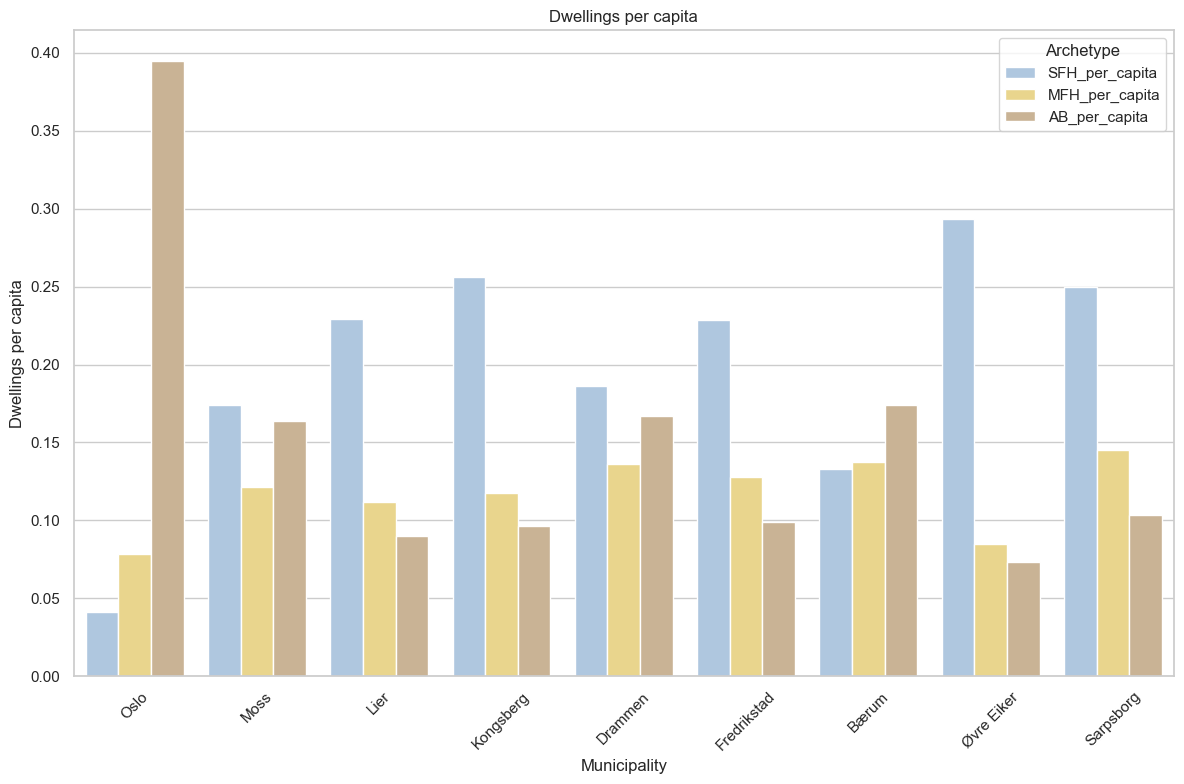

In [92]:
oslo_and_adj3 = dw_06266_full_pop[dw_06266_full_pop["kommunenum"].isin(oslo_and_adj_codes)]

oslo_and_adj_melted = oslo_and_adj3.melt(
    id_vars=["kommunenum", "kommunenav"],
    value_vars=["SFH_per_capita", "MFH_per_capita", "AB_per_capita"],
    var_name="Archetype",
    value_name="Dwellings_per_capita"
)
colors = ["#A7C7E7", "#F8DE7E", "#D2B48C"]

plt.figure(figsize=(12, 8))
sns.barplot(
    data=oslo_and_adj_melted,
    x="kommunenav",
    y="Dwellings_per_capita",
    hue="Archetype",
    palette=colors
)

# Labels and formatting
plt.xlabel("Municipality")
plt.ylabel("Dwellings per capita")
plt.title("Dwellings per capita")
plt.xticks(rotation=45)
plt.legend(title="Archetype")

plt.tight_layout()
plt.show()

In [103]:
pop_11023 = pd.read_excel("/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_11023_2024_raw.xlsx")
pop_11023

11023: Residents, by region, age, year of construction, contents, year and type of building  \
0                                                   NaN                                            
1                                                   NaN                                            
2                                                   NaN                                            
3                                                   NaN                                            
4                                            31 Østfold                                            
...                                                 ...                                            
3051                                          Database:                                            
3052                                      External PROD                                            
3053                                                NaN                                            
3054                           Internal reference code:                                            
3055                                           Personer                                            

        Unnamed: 1 Unnamed: 2       Unnamed: 3      Unnamed: 4  \
0              NaN        NaN              NaN             NaN   
1              NaN        NaN          Persons             NaN   
2              NaN        NaN             2024             NaN   
3              NaN        NaN  Dwellings total  Detached house   
4     Years, total      Total           306354          180460   
...            ...        ...              ...             ...   
3051           NaN        NaN              NaN             NaN   
3052           NaN        NaN              NaN             NaN   
3053           NaN        NaN              NaN             NaN   
3054           NaN        NaN              NaN             NaN   
3055           NaN        NaN              NaN             NaN   

                    Unnamed: 5  \
0                          NaN   
1                          NaN   
2                          NaN   
3     House with two dwellings   
4                        35718   
...                        ...   
3051                       NaN   
3052                       NaN   
3053                       NaN   
3054                       NaN   
3055                       NaN   

                                             Unnamed: 6  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3     Row house, linked house and house with 3 or 4 ...   
4                                                 39154   
...                                                 ...   
3051                                                NaN   
3052                                                NaN   
3053                                                NaN   
3054                                                NaN   
3055                                                NaN   

                   Unnamed: 7                  Unnamed: 8  
0                         NaN                         NaN  
1                         NaN                         NaN  
2                         NaN                         NaN  
3     Multi-dwelling building  Other residential building  
4                       41858                        9164  
...                       ...                         ...  
3051                      NaN                         NaN  
3052                      NaN                         NaN  
3053                      NaN                         NaN  
3054                      NaN                         NaN  
3055                      NaN                         NaN  

[3056 rows x 9 columns]

In [93]:
total_heated_area

4           AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  AB_1991_2000  \
kommunenum                                                                    
3101        44912.0       16589.0       26230.0        9920.0       16414.0   
3103        36456.0       83369.0       53070.0       40192.0       39556.0   
3105        46032.0       39432.0       80154.0       31808.0       24244.0   
3107        46760.0       52894.0       66734.0       29568.0       24418.0   
3110            0.0           0.0           0.0           0.0        1044.0   
...             ...           ...           ...           ...           ...   
5628            0.0           0.0           0.0         256.0         406.0   
5630            0.0           0.0           0.0           0.0           0.0   
5632           56.0           0.0        1647.0          64.0         696.0   
5634          672.0           0.0           0.0         448.0           0.0   
5636            0.0           0.0           0.0           0.0           0.0   

4           AB_2001_2010  AB_2011_2020  AB_2021_   SFH_1955  SFH_1956_1970  \
kommunenum                                                                   
3101             16560.0       28084.0   20060.0   354977.0       155541.0   
3103             71880.0      124644.0   62152.0   412300.0       183480.0   
3105             38460.0       38420.0   33524.0   635208.0       282031.0   
3107             70980.0      168980.0   43860.0  1018780.0       324009.0   
3110              1440.0        5168.0     476.0    78470.0        16124.0   
...                  ...           ...       ...        ...            ...   
5628                 0.0        1904.0       0.0    40831.0        17653.0   
5630                 0.0         136.0       0.0    28329.0        16263.0   
5632               300.0         408.0       0.0    27398.0        23769.0   
5634                 0.0           0.0       0.0    50407.0        16263.0   
5636                 0.0           0.0       0.0    18354.0         5838.0   

4           SFH_1971_1980  SFH_1981_1990  SFH_1991_2000  SFH_2001_2010  \
kommunenum                                                               
3101             170064.0       160678.0        66581.0        83354.0   
3103             169920.0       186277.0       125795.0        99968.0   
3105             345744.0       332787.0        84929.0       101672.0   
3107             349344.0       440979.0       172082.0       161880.0   
3110              31968.0        49427.0        23908.0        37204.0   
...                   ...            ...            ...            ...   
5628              39312.0        44275.0        20989.0        10224.0   
5630              14544.0         2093.0          834.0         1136.0   
5632              29664.0         8533.0         7645.0         1562.0   
5634              28080.0         5152.0         5282.0          852.0   
5636              16704.0        12236.0         5421.0         2982.0   

4           SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  MFH_1971_1980  \
kommunenum                                                                     
3101             100928.0    19608.0  201168.0        43329.0        28100.0   
3103              64296.0    15504.0  163240.0        82517.0       112700.0   
3105              78128.0    24624.0  269456.0       106959.0        94200.0   
3107             152912.0    27968.0  389576.0       105242.0       116900.0   
3110              43472.0     7296.0    1760.0          707.0         1200.0   
...                   ...        ...       ...            ...            ...   
5628              12920.0     3192.0    1496.0          202.0         2600.0   
5630                912.0        0.0    5632.0          303.0          600.0   
5632               1824.0        0.0    2816.0         2424.0          200.0   
5634                608.0      456.0   19096.0         3838.0         3100.0   
5636               2280.0      304

In [94]:
summed_data

kommunenum         kommunenav  \
0         0301               Oslo   
1         1101          Eigersund   
2         1103          Stavanger   
3         1106          Haugesund   
4         1108            Sandnes   
..         ...                ...   
352       5628      Deatnu - Tana   
353       5630           Berlevåg   
354       5632          Båtsfjord   
355       5634              Vardø   
356       5636  Unjárga - Nesseby   

                                              geometry  \
0    POLYGON ((260102.430 6645441.707, 258753.600 6...   
1    POLYGON ((-21958.180 6520966.530, -21956.580 6...   
2    POLYGON ((-29201.128 6570959.109, -29471.170 6...   
3    POLYGON ((-49124.150 6623149.960, -49125.720 6...   
4    POLYGON ((-22245.720 6554013.470, -22251.980 6...   
..                                                 ...   
352  POLYGON ((1001375.840 7845982.420, 1000896.830...   
353  POLYGON ((1037426.140 7940200.490, 1042544.060...   
354  POLYGON ((1035879.380 7877514.130, 1035854.380...   
355  POLYGON ((1093794.100 7917698.950, 1097128.971...   
356  POLYGON ((1000651.810 7841677.460, 1000744.360...   

     total_material_amounts  pop_tot  ms_per_capita  
0              3.950414e+10   676793   58369.603940  
1              8.026948e+08    15115   53105.841157  
2              6.792662e+09   134458   50518.835208  
3              1.838145e+09    30987   59319.890883  
4              3.305548e+09    80086   41274.978025  
..                      ...      ...            ...  
352            1.928956e+08     2621   73596.202025  
353            7.500088e+07      891   84176.069467  
354            1.167610e+08     2109   55363.210907  
355            1.403552e+08     1969   71282.462873  
356            6.802777e+07      859   79194.145153  

[357 rows x 6 columns]

In [95]:
av_heated_area_capita = pd.merge(total_heated_area, summed_data, on="kommunenum")
av_heated_area_capita

kommunenum  AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  \
0         3101  44912.0       16589.0       26230.0        9920.0   
1         3103  36456.0       83369.0       53070.0       40192.0   
2         3105  46032.0       39432.0       80154.0       31808.0   
3         3107  46760.0       52894.0       66734.0       29568.0   
4         3110      0.0           0.0           0.0           0.0   
..         ...      ...           ...           ...           ...   
352       5628      0.0           0.0           0.0         256.0   
353       5630      0.0           0.0           0.0           0.0   
354       5632     56.0           0.0        1647.0          64.0   
355       5634    672.0           0.0           0.0         448.0   
356       5636      0.0           0.0           0.0           0.0   

     AB_1991_2000  AB_2001_2010  AB_2011_2020  AB_2021_   SFH_1955  \
0         16414.0       16560.0       28084.0   20060.0   354977.0   
1         39556.0       71880.0      124644.0   62152.0   412300.0   
2         24244.0       38460.0       38420.0   33524.0   635208.0   
3         24418.0       70980.0      168980.0   43860.0  1018780.0   
4          1044.0        1440.0        5168.0     476.0    78470.0   
..            ...           ...           ...       ...        ...   
352         406.0           0.0        1904.0       0.0    40831.0   
353           0.0           0.0         136.0       0.0    28329.0   
354         696.0         300.0         408.0       0.0    27398.0   
355           0.0           0.0           0.0       0.0    50407.0   
356           0.0           0.0           0.0       0.0    18354.0   

     SFH_1956_1970  SFH_1971_1980  SFH_1981_1990  SFH_1991_2000  \
0         155541.0       170064.0       160678.0        66581.0   
1         183480.0       169920.0       186277.0       125795.0   
2         282031.0       345744.0       332787.0        84929.0   
3         324009.0       349344.0       440979.0       172082.0   
4          16124.0        31968.0        49427.0        23908.0   
..             ...            ...            ...            ...   
352        17653.0        39312.0        44275.0        20989.0   
353        16263.0        14544.0         2093.0          834.0   
354        23769.0        29664.0         8533.0         7645.0   
355        16263.0        28080.0         5152.0         5282.0   
356         5838.0        16704.0        12236.0         5421.0   

     SFH_2001_2010  SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  \
0          83354.0       100928.0    19608.0  201168.0        43329.0   
1          99968.0        64296.0    15504.0  163240.0        82517.0   
2         101672.0        78128.0    24624.0  269456.0       106959.0   
3         161880.0       152912.0    27968.0  389576.0       105242.0   
4          37204.0        43472.0     7296.0    1760.0          707.0   
..             ...            ...        ...       ...            ...   
352        10224.0        12920.0     3192.0    1496.0          202.0   
353         1136.0          912.0        0.0    5632.0          303.0   
354         1562.0         1824.0        0.0    2816.0         2424.0   
355          852.0          608.0      456.0   19096.0         3838.0   
356         2982.0         2280.0      304.0     792.0            0.0   

     MFH_1971_1980  MFH_1981_1990  MFH_1991_2000  MFH_2001_2010  \
0          28100.0        21600.0        13430.0        41624.0   
1         112700.0        68928.0        29920.0        49016.0   
2          94200.0        38784.0        19975.0        58960.0   
3         116900.0        88512.0        55335.0        89408.0   
4           1200.0         1920.0         2295.0        11704.0   
..             ...            ...            ...            ...   
352         2600.0         2400.0         1020.0         1408.0   
353          600.0          768.0            0.0            0.0   
354          200.0         3456.0         1360.0 

In [96]:
# Select columns that start with SFH, MFH, and AB
sfh_cols = [col for col in av_heated_area_capita.columns if col.startswith("SFH")]
mfh_cols = [col for col in av_heated_area_capita.columns if col.startswith("MFH")]
ab_cols = [col for col in av_heated_area_capita.columns if col.startswith("AB")]

# Compute total heated area for each archetype
av_heated_area_capita["total_SFH_area"] = av_heated_area_capita[sfh_cols].sum(axis=1)
av_heated_area_capita["total_MFH_area"] = av_heated_area_capita[mfh_cols].sum(axis=1)
av_heated_area_capita["total_AB_area"] = av_heated_area_capita[ab_cols].sum(axis=1)

av_heated_area_capita["average_area_SFH"] = av_heated_area_capita["total_SFH_area"] / av_heated_area_capita["pop_tot"]
av_heated_area_capita["average_area_MFH"] = av_heated_area_capita["total_MFH_area"] / av_heated_area_capita["pop_tot"]
av_heated_area_capita["average_area_AB"] = av_heated_area_capita["total_AB_area"] / av_heated_area_capita["pop_tot"]

av_heated_area_capita.replace([np.inf, -np.inf], np.nan, inplace=True)

av_heated_area_capita

kommunenum  AB_1955  AB_1956_1970  AB_1971_1980  AB_1981_1990  \
0         3101  44912.0       16589.0       26230.0        9920.0   
1         3103  36456.0       83369.0       53070.0       40192.0   
2         3105  46032.0       39432.0       80154.0       31808.0   
3         3107  46760.0       52894.0       66734.0       29568.0   
4         3110      0.0           0.0           0.0           0.0   
..         ...      ...           ...           ...           ...   
352       5628      0.0           0.0           0.0         256.0   
353       5630      0.0           0.0           0.0           0.0   
354       5632     56.0           0.0        1647.0          64.0   
355       5634    672.0           0.0           0.0         448.0   
356       5636      0.0           0.0           0.0           0.0   

     AB_1991_2000  AB_2001_2010  AB_2011_2020  AB_2021_   SFH_1955  \
0         16414.0       16560.0       28084.0   20060.0   354977.0   
1         39556.0       71880.0      124644.0   62152.0   412300.0   
2         24244.0       38460.0       38420.0   33524.0   635208.0   
3         24418.0       70980.0      168980.0   43860.0  1018780.0   
4          1044.0        1440.0        5168.0     476.0    78470.0   
..            ...           ...           ...       ...        ...   
352         406.0           0.0        1904.0       0.0    40831.0   
353           0.0           0.0         136.0       0.0    28329.0   
354         696.0         300.0         408.0       0.0    27398.0   
355           0.0           0.0           0.0       0.0    50407.0   
356           0.0           0.0           0.0       0.0    18354.0   

     SFH_1956_1970  SFH_1971_1980  SFH_1981_1990  SFH_1991_2000  \
0         155541.0       170064.0       160678.0        66581.0   
1         183480.0       169920.0       186277.0       125795.0   
2         282031.0       345744.0       332787.0        84929.0   
3         324009.0       349344.0       440979.0       172082.0   
4          16124.0        31968.0        49427.0        23908.0   
..             ...            ...            ...            ...   
352        17653.0        39312.0        44275.0        20989.0   
353        16263.0        14544.0         2093.0          834.0   
354        23769.0        29664.0         8533.0         7645.0   
355        16263.0        28080.0         5152.0         5282.0   
356         5838.0        16704.0        12236.0         5421.0   

     SFH_2001_2010  SFH_2011_2020  SFH_2021_  MFH_1955  MFH_1956_1970  \
0          83354.0       100928.0    19608.0  201168.0        43329.0   
1          99968.0        64296.0    15504.0  163240.0        82517.0   
2         101672.0        78128.0    24624.0  269456.0       106959.0   
3         161880.0       152912.0    27968.0  389576.0       105242.0   
4          37204.0        43472.0     7296.0    1760.0          707.0   
..             ...            ...        ...       ...            ...   
352        10224.0        12920.0     3192.0    1496.0          202.0   
353         1136.0          912.0        0.0    5632.0          303.0   
354         1562.0         1824.0        0.0    2816.0         2424.0   
355          852.0          608.0      456.0   19096.0         3838.0   
356         2982.0         2280.0      304.0     792.0            0.0   

     MFH_1971_1980  MFH_1981_1990  MFH_1991_2000  MFH_2001_2010  \
0          28100.0        21600.0        13430.0        41624.0   
1         112700.0        68928.0        29920.0        49016.0   
2          94200.0        38784.0        19975.0        58960.0   
3         116900.0        88512.0        55335.0        89408.0   
4           1200.0         1920.0         2295.0        11704.0   
..             ...            ...            ...            ...   
352         2600.0         2400.0         1020.0         1408.0   
353          600.0          768.0            0.0            0.0   
354          200.0         3456.0         1360.0 

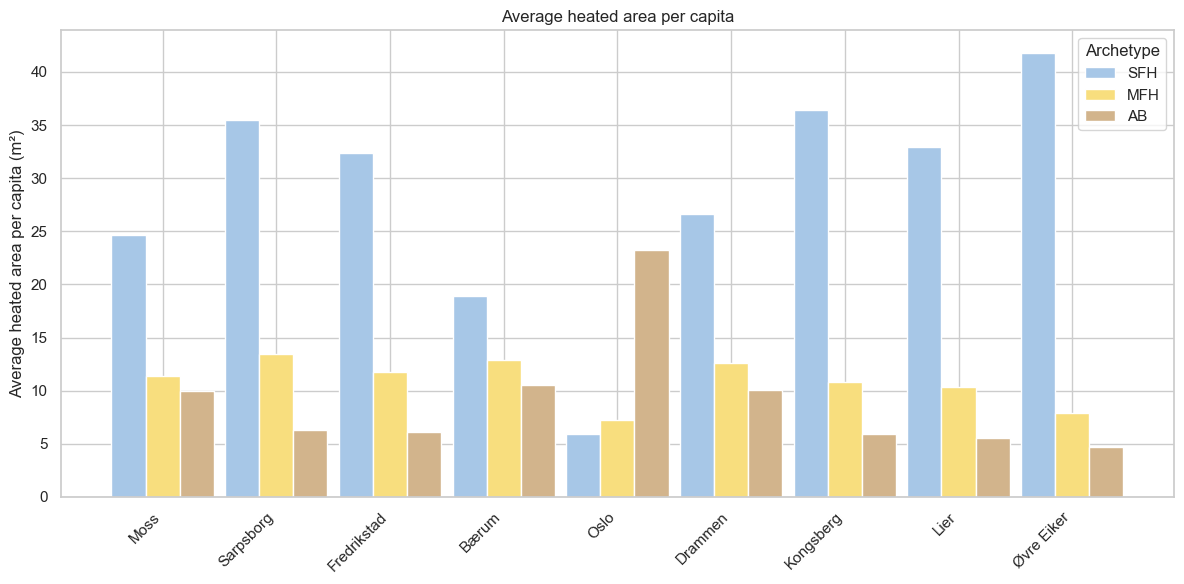

In [97]:
oslo_and_adj4 = av_heated_area_capita[av_heated_area_capita["kommunenum"].isin(oslo_and_adj_codes)]

# Define bar width and positions
x_labels = oslo_and_adj4["kommunenav"]
x = np.arange(len(x_labels))  # X-axis positions
width = 0.3  # Bar width

# Define pastel colors for SFH, MFH, and AB
colors = ["#A7C7E7", "#F8DE7E", "#D2B48C"]

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each type of dwelling
ax.bar(x - width, oslo_and_adj4["average_area_SFH"], width, color=colors[0], label="SFH")
ax.bar(x, oslo_and_adj4["average_area_MFH"], width, color=colors[1], label="MFH")
ax.bar(x + width, oslo_and_adj4["average_area_AB"], width, color=colors[2], label="AB")

# Set labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha="right")
ax.set_ylabel("Average heated area per capita (m²)")
ax.set_title("Average heated area per capita")
ax.legend(title="Archetype")

plt.tight_layout()
plt.show()


For the next part, it is necessary to export a table final_merge

In [99]:
final_merge.drop(["geometry", "archetype_x", "archetype_y"], axis=1, inplace=True)

In [100]:
final_merge.to_csv("Output/final_merge_for_LCA.csv", index=False)

In [19]:
total_heated_area_melted.to_csv("Output/total_heated_area.csv")